# Deriving multi-Gaussian approximations to Sersic profiles

This notebook demonstrates how to derive optimal parameters for Gaussian mixture model approximations to the Sersic (1963, 1968) function commonly used to model galaxy radial surface brightness profiles.

The main motivation behind doing this is that a Gaussian convolved with a Gaussian has an analytic solution - namely, another Gaussian - and so Gaussian mixture galaxy models convolved with Gaussian mixture PSF models are simple and fast to evaluate.
There are some other advantages that won't be detailed here. The only serious disadvantage is the introduction of 'wiggles' in the profile and therefore roughly sinusoidal variations in the second derivative.

The approach here is similar to Hogg & Lang (2013), but that paper did not publish weights for entire useful range of Sersic indices 0.5 <= n < 8. In practice we usually only go up to n=6.3 as this is the upper limit supported in GalSim.

For convenience, after this we'll refer to multi-Gaussian approximations (i.e. Gaussian mixture models) as MGAs for short.

In [4]:
# Setup; multiprofit gets imported later for verification plots

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp

%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

## Define useful functions

Here we'll define functions for a unit Sersic profile, and for optimizing the weights in an MGA for a chi-square like objective function.

The fitting functions allow for matching the profile over a limited range after re-normalization - the justification for this will be explained later.

Note that the size unit is always Re, and Re = FWHM/2 ~ 1.17741 sigma; the weight is just a fraction for convenience.

In [32]:
# Surface brightness of a unit flux Sersic profile
def sersic(r, n, re):
    bn = sp.stats.gamma.ppf(0.5, 2*n)
    g_factor = sp.special.gamma(2*n)
    flux = np.power(re, 2)*2*np.pi*n*g_factor*np.exp(bn)/np.power(bn, 2*n)
    ir = np.exp(-bn*(np.power(r/re, 1./n)-1.))
    return ir/flux


# Compute chisq as log difference in 2D binned flux
# i.e. not really chisq since it's a sum of squares but without any error
# Rangefit allows re-normalizing the model to match data normalization within the specified range
# Otherwise, the model and data are normalized from r=0 to infinity
def chisq_sersic(params, x, y, weightsbins, rangefit=None, rdivreslog=None,
                 plotdata=False, plotmodel=False, returnall=False):
    ymodel = np.zeros(len(x))
    weights, res = paramstoweightres(params, rdivreslog)
    for weight, re in zip(weights, res):
        ymodel += weight*sersic(x, 0.5, re)
    if plotdata:
        plt.plot(x, np.log10(y/(weightsbins if weightsbins is not None else 1.)))
    if plotmodel:
        plt.plot(x, np.log10(ymodel))
    if weightsbins is not None:
        ymodel *= weightsbins
        if plotmodel:
            print(np.sum(y), np.sum(ymodel))
    if weightsbins is not None:
        if rangefit is not None:
            ymodel = ymodel[rangefit]
            ymodel *= np.sum(y[rangefit])/np.sum(ymodel)
        chisq = np.log10(np.sum(((y if rangefit is None else y[rangefit])-ymodel)**2))
        if returnall:
            return chisq, ymodel
        return chisq


# Take a parameter vector for fitting and split into sizes and weights
def paramstoweightres(params, rdivreslog=None):
    if rdivreslog is not None:
        paramsnew = np.concatenate([params, rdivreslog])
    else:
        paramsnew = params
    nsplit = (len(paramsnew)+1)//2
    weights = np.zeros(nsplit)
    res = np.zeros(nsplit)
    total = 1.0
    for i in range(nsplit):
        if i < (nsplit-1):
            weight = sp.special.expit(paramsnew[i])
            weights[i] = total*weight
            total *= (1.0-weight)
        res[i] = 10**paramsnew[i+nsplit-1]
    weights[nsplit-1] = 1-np.sum(weights)
    return weights, res


# Take sizes and weights of Gaussians and mash them into a single parameter vector (e.g. for minimization)
def weightrestoparams(weights, res, rdivreslog=None):
    paramweights = []
    paramres = []
    total = 1.0
    for weight, re in zip(weights, res):
        paramweights.append(sp.special.logit(weight/total))
        total -= weight
        if rdivreslog is None:
            paramres.append(np.log10(re))
    return paramweights[:-1] + paramres


# Fit optimals weights for given values of n, given radial bins, the area of each bin, optional sigmas on the bins (i.e. how to weight each bin when fitting)
# Can specify a fitting method, whether and how many of the values to plot, a threshold to add an extra component, the initial weight of the added component,
# whether the added component should be bigger than the biggest or smaller than the smallest current component
# funcrangefit:   A function that takes radii and n and returns a restricted range of radii to fit (that depends on n)
# funcrdivreslog: A function that returns radii for a given n and fixes them so that only the weights are fit (useful for fitting values of n close to 0.5)
def fitweights(nvals, radii, areasq, weightssigmas={}, methods=['BFGS'], plot=True, plotnth=1, plotvals=None, addthreshhold=None,
               weightinit=1e-3, refacinit=1.1, addbig=None, funcrangefit=None, funcrdivreslog=None, sort=True):
    for nvalsi, weightsvars in nvals:
        params = weightrestoparams(weightsvars[0], weightsvars[1], funcrdivreslog) if weightsvars is not None else None
        for i, n in enumerate(nvalsi):
            plotn = plot and (((i+1) % plotnth == 0) or (plotvals is not None and n in plotvals))
            y = sersic(radii, n, 1)*areasq
            paramsbytype = {}
            rangefit = funcrangefit(radii, n) if funcrangefit is not None else None
            rdivreslog = funcrdivreslog(n) if funcrdivreslog is not None else None
            if params is not None:
                paramsbytype['Init'] = params
            if n in weightssigmas:
                weightsvars = weightssigmas[n]
                paramsbytype['Existing'] = weightrestoparams(
                    weightsvars[0][::-1], np.sqrt(weightsvars[1][::-1])*gaussian_sigma_to_re)
            plotdata = plotn
            chisqmin = np.Inf
            for name, paramsi in paramsbytype.items():
                chisq = chisq_sersic(paramsi, radii, y, areasq, rangefit, rdivreslog,
                                     plotdata=plotdata, plotmodel=plotn)
                print(name, ' chisq =', chisq)
                if chisq < chisqmin:
                    params = paramsi
                plotdata = False
            print('ws, re:', paramstoweightres(params, rdivreslog))
            for method in methods:
                fit = sp.optimize.minimize(chisq_sersic, params, args=(radii, y, areasq, rangefit, rdivreslog),
                                           tol=1e-5, options={'disp': True, }, method=method)
                params = fit['x']
            print(fit['fun'], fit['x'])
            chisq = chisq_sersic(params, radii, y, areasq, rangefit, rdivreslog, plotmodel=plotn)
            if plotn:
                plt.xlabel('$r/r_{eff}$')
                plt.ylabel('log10(surface density)')
                plt.tight_layout()
                for axis in ['x', 'y']:
                    plt.autoscale(enable=True, axis=axis, tight=True)
                plt.legend(['Data'] + list(paramsbytype.keys()) + ['Best'])
            weights, res = paramstoweightres(params, rdivreslog)
            if sort:
                idxsort = np.argsort(res)[::-1]
                weights = np.array(weights)[idxsort]
                res = np.array(res)[idxsort]
            print('n={}: ('.format(n))
            for arr, prefix, postfix in [(weights, 'normalize(', ')'), (res, '', '')]:
                print('    ' + prefix + 'np.array([' + ', '.join(
                    ['{:.10e}'.format(x) for x in arr]) + '])' + postfix + ',')
            print('),')
            if addthreshhold is not None and chisq > addthreshhold:
                # Add a small component if n < 1.5; big if n > 1.5 by default
                cond = n > 1.5 if addbig is None else addbig 
                weights *= 1.0-weightinit
                weights = np.insert(weights, 0, weightinit) if cond else np.append(weights, weightinit)
                res = np.insert(res, 0, refacinit*res[0]) if cond else np.append(res, res[-1]/refacinit)
                params = weightrestoparams(weights, res)
                print('new w, r:', weights, res)
            if plotn:
                plt.show()
                

def normalize(array):
    array /= np.sum(array)
    return array

## Define the fit range and plot the Sersic profile for reference

We choose to fit out to R/Re = 12 rather than the more typical limit of R/Re=8 commonly used in SDSS. This allows the fits to better match the n>4 profiles at R/Re > 4. Massive elliptical galaxies often do have very extended outer profiles with large Sersic indices (see papers by Kormendy & co. on Virgo galaxies), so we do want to reproduce the shape at large radii. Eventually, the MGA profile will truncate more quickly than a Sersic profile as only the outer Gaussian contributes to the flux, but that's fine - we don't really trust the extrapolation at such large radii unless there's very deep data to constrain it.

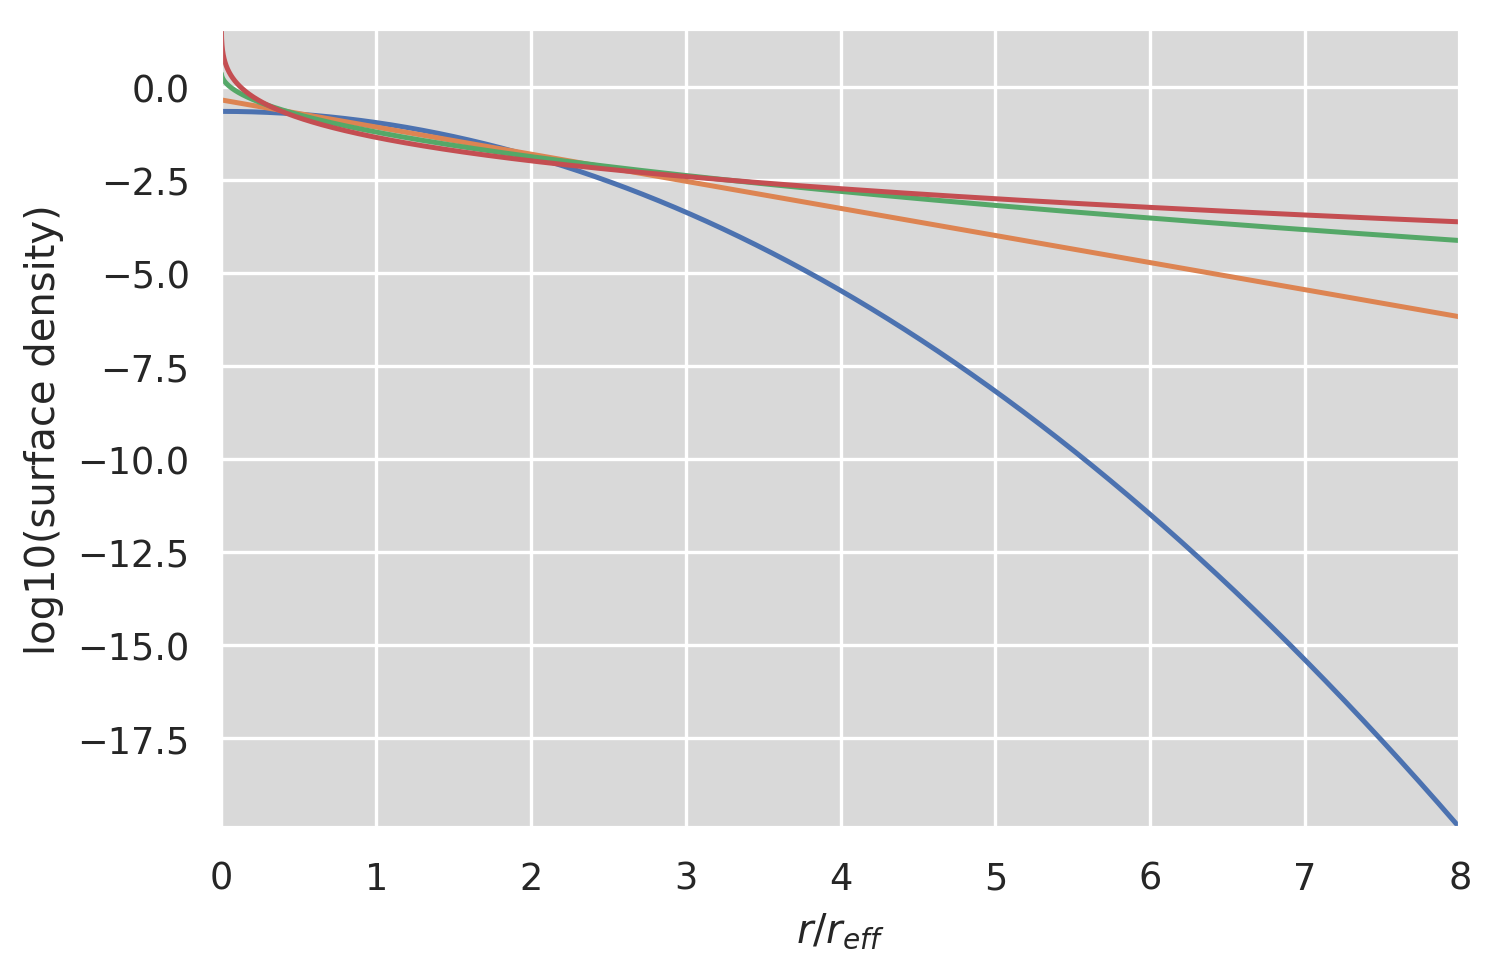

In [7]:
order = 8

nbinsperre = 2000
remax = 12
redge = np.linspace(0, remax, nbinsperre*remax+1)
rmid = (redge[1:] + redge[:-1])/2.
rsq = redge**2
areasq = np.pi*(rsq[1:] - rsq[:-1])

idxsplot = range(8*nbinsperre)

for n in [0.5, 1, 2, 4]:
    sns.lineplot(rmid[idxsplot], np.log10(sersic(rmid[idxsplot], n, 1)))
plt.tight_layout()
for axis in ['x', 'y']:
    plt.autoscale(enable=True, axis=axis, tight=True)
plt.xlabel('$r/r_{eff}$')
plt.ylabel('log10(surface density)')
plt.show()

## Carefully fit MGA weights/sizes for n < 1

This section begins fitting the optimal weights and sizes of the MGA.

The trickiest part of this problem is finding optimal weights for an MGA with N components as n -> 0.5. Of course, you only need a single component to reproduce n=0.5 exactly, and for n=0.5 + a small epsilon, you need only two Gaussians - one slightly smaller and one slightly larger - for a good approximation. As n grows, the minimal N for a good fit grows too. There are essentially two options, then - either grow N gradually with increasing n, or keep N fixed and hope that the weights change smoothly down to n=0.5. Unfortunately, the latter option is practically quite difficult as many of the best-fit weights asymptote to zero but are very noisy, which is a problem if we want to smoothly interpolate the weights for any value of N (see below). That leaves the first option of gradually adding components.

After some experimentation, two things are apparent. First, as n->0.5, the best-fit model tends to two components of (weight, size) = (1-delta, 1+eps), (delta, 0.716). Why that specifical value of 0.716, I'm not sure.

Secondly, adding components while maintaining a smooth variation in the weights and sizes becomes tricky, because the best-fit solutions for an MGA with N and N-1 components can be significantly different. The solution here is to ensure delta n is large enough when incrementing N such that the weights still change smoothly. However, it turns out that the weights derived here through a combination of working from n=0.5 up and from n=1 down (meeting in the middle) don't change smoothly enough to be useable for interpolation and fitting - see the plots further below.

Thirdly, there were only two things, but there's no legend in the plots so it should be mentioned that blue is true profile, orange is the initial guess, and green is the final best fit.

Note that it's impossible to fit n < 0.5 profiles with an MGA without spatially offsetting the components. Note that as n <= 0, the Sersic profile approaches a step function. This isn't a very useful approximation for most 'normal' galaxies, but it can be a useful approximation of parts of barred/ring galaxies, so we will revisit this issue later.

1.0000000144581254 1.000000014229467
Init  chisq = -7.588745391812752
ws, re: (array([0.98, 0.02]), array([1.01, 0.9 ]))
         Current function value: -12.124435
         Iterations: 21
         Function evaluations: 612
         Gradient evaluations: 120
-12.1244350827063 [ 5.63857896e+00  5.35362016e-04 -1.45058260e-01]
1.0000000144581254 1.0000000144537895
n=0.501: (
    normalize(np.array([9.9645469317e-01, 3.5453068336e-03])),
    np.array([1.0012334767e+00, 7.1604734662e-01]),
),


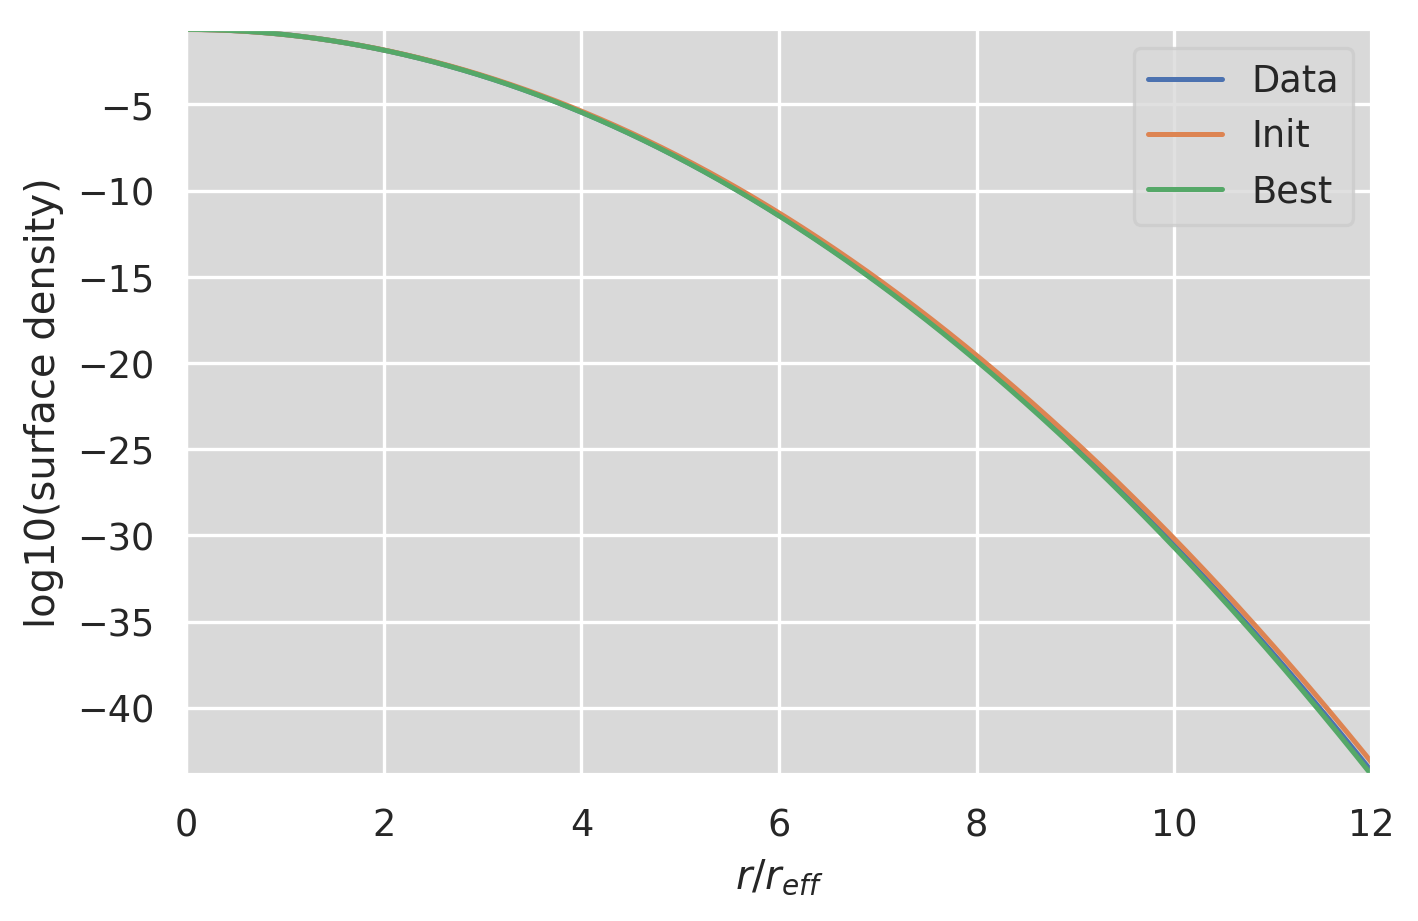

1.0000000145642924 1.0000000147654382
Init  chisq = -7.7362581434074595
ws, re: (array([0.87013735, 0.12619086, 0.00367179]), array([1.03392488, 0.81955231, 0.42170644]))
         Current function value: -11.998273
         Iterations: 207
         Function evaluations: 2336
         Gradient evaluations: 332
-11.99827306304458 [-2.89964115e+00  6.66790914e+00 -8.51519166e-02  5.29272520e-03
 -3.75584400e-01]
1.0000000145642924 1.0000000145537353
n=0.507: (
    normalize(np.array([9.4662548327e-01, 5.2171305034e-02, 1.2032116992e-03])),
    np.array([1.0122615136e+00, 8.2195507899e-01, 4.2112943705e-01]),
),


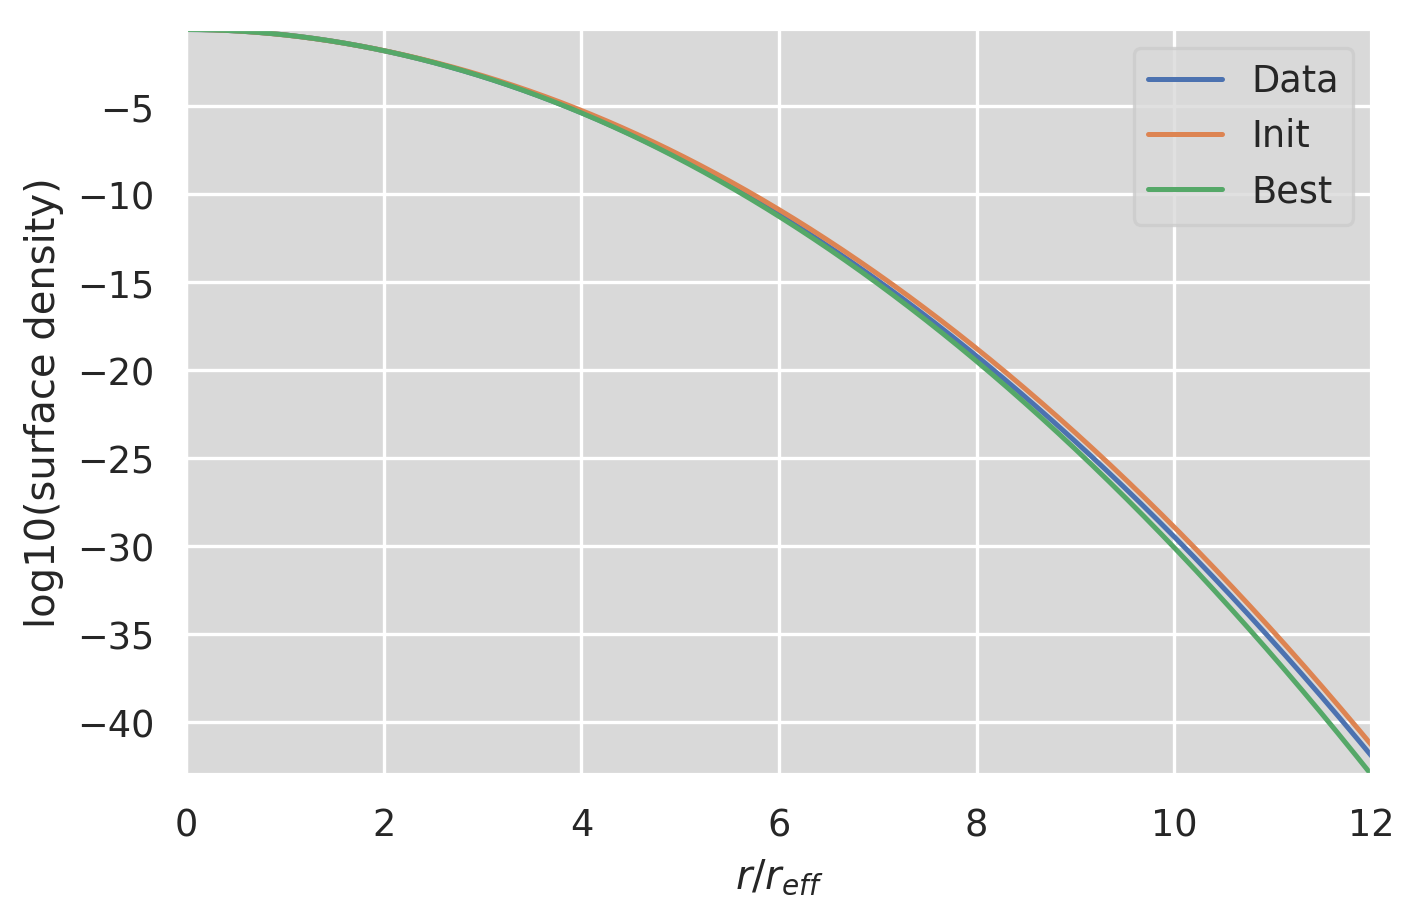

Init  chisq = -7.117390029086779
ws, re: (array([0.07790019, 0.31264016, 0.33937179, 0.1839253 , 0.06541804,
       0.01709507, 0.00326612, 0.00038332]), array([2.17045661, 1.47679133, 0.99494464, 0.65054022, 0.40699848,
       0.23877605, 0.12631553, 0.05405815]))
         Current function value: -11.155304
         Iterations: 52
         Function evaluations: 2035
         Gradient evaluations: 119
-11.15530445544733 [-2.42262005 -0.59808414  0.30058746  0.82079262  1.1970379   1.5809865
  2.17308776  0.31341845  0.15498436 -0.01022075 -0.1900277  -0.38993527
 -0.6181705  -0.89132524 -1.2559645 ]
n=0.95: (
    normalize(np.array([8.1463988478e-02, 3.2588016643e-01, 3.4053182287e-01, 1.7507607194e-01, 5.9172627261e-02, 1.4824795210e-02, 2.7387840554e-03, 3.1174375934e-04])),
    np.array([2.0578724478e+00, 1.4288424938e+00, 9.7674061971e-01, 6.4561304442e-01, 4.0744100447e-01, 2.4089595025e-01, 1.2843244753e-01, 5.5467104900e-02]),
),
1.0000000242164144 1.0000000264952646
Init  chisq

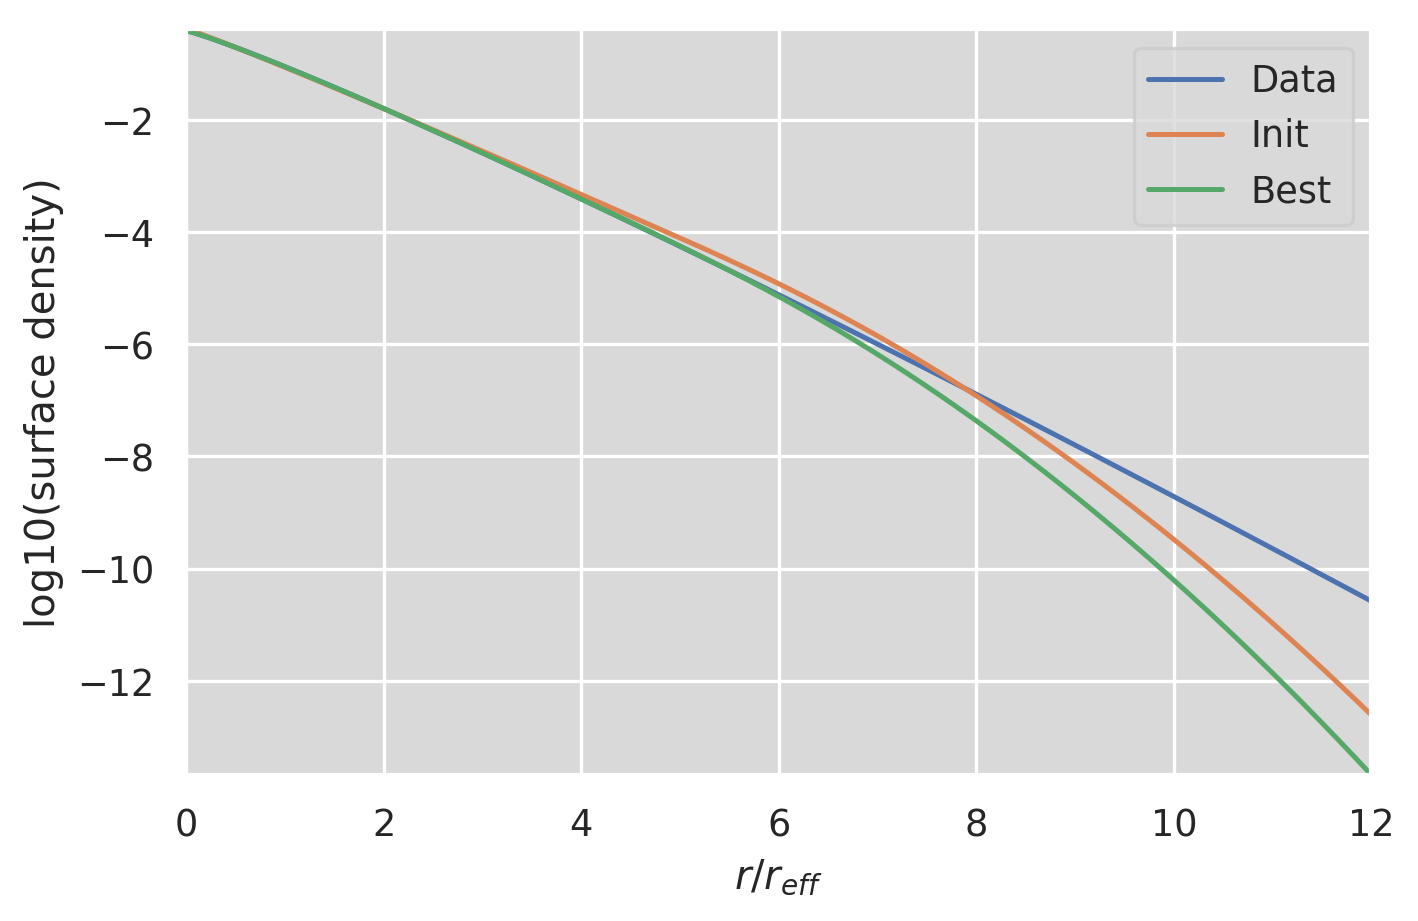

Init  chisq = -7.02552013403142
ws, re: (array([8.29449271e-02, 3.37371657e-01, 3.42939773e-01, 1.67551154e-01,
       5.37364254e-02, 1.28983283e-02, 2.30324447e-03, 2.54490187e-04]), array([1.95369467, 1.38804896, 0.96460162, 0.64520876, 0.41099448,
       0.24500806, 0.13172635, 0.05747899]))
         Current function value: -11.694331
         Iterations: 90
         Function evaluations: 2833
         Gradient evaluations: 166
-11.69433132400764 [-2.32226401 -0.44187223  0.4681851   0.96304997  1.30273284  1.65849114
  2.23790881  0.26461024  0.12594596 -0.02514642 -0.19482256 -0.38686318
 -0.60809025 -0.8740841  -1.23021408]
n=0.85: (
    normalize(np.array([8.9295774481e-02, 3.5635395908e-01, 3.4089997162e-01, 1.5448081819e-01, 4.6367378483e-02, 1.0586207953e-02, 1.8215633357e-03, 1.9432685769e-04])),
    np.array([1.8391207336e+00, 1.3364292193e+00, 9.4374264293e-01, 6.3852430856e-01, 4.1033335262e-01, 2.4655269337e-01, 1.3363367181e-01, 5.8855346344e-02]),
),
1.000000021676465

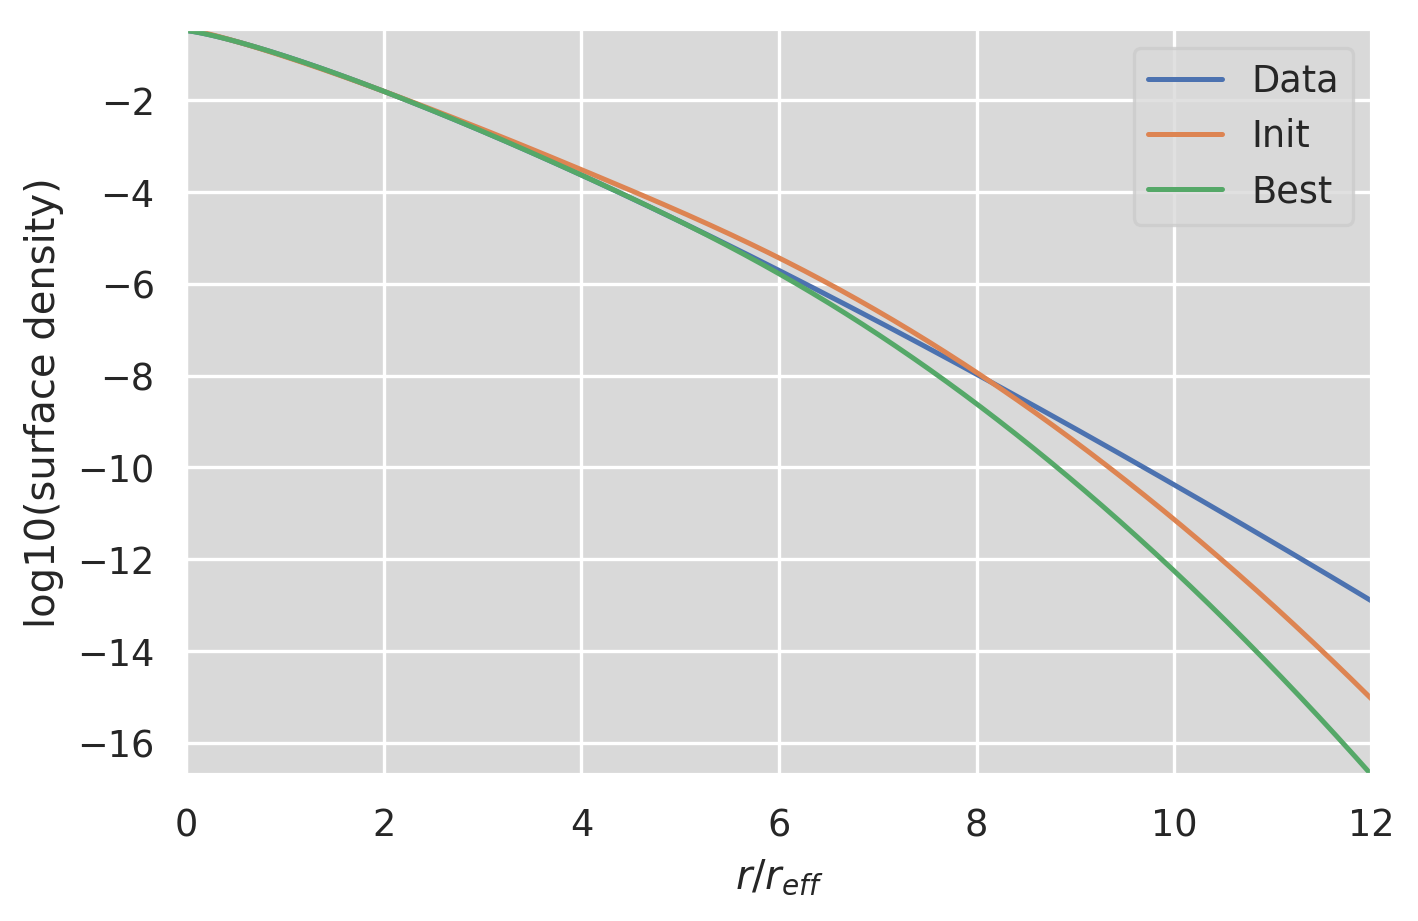

Init  chisq = -6.921481313230024
ws, re: (array([9.73594083e-02, 3.76326328e-01, 3.36086098e-01, 1.40674951e-01,
       3.94391161e-02, 8.55248272e-03, 1.41568155e-03, 1.45933879e-04]), array([1.72513705, 1.28585566, 0.92536514, 0.63459678, 0.41183005,
       0.24949254, 0.13638471, 0.06072822]))
         Current function value: -12.377141
         Iterations: 114
         Function evaluations: 3038
         Gradient evaluations: 178
-12.377141103157182 [-2.25211141 -0.27404148  0.66694483  1.1294116   1.42115378  1.74346593
  2.30884375  0.21213991  0.09788909 -0.03532965 -0.19276266 -0.37599953
 -0.58974059 -0.84797218 -1.19414293]
n=0.75: (
    normalize(np.array([9.5167494628e-02, 3.9081090139e-01, 3.3967509760e-01, 1.3175893673e-01, 3.4305106271e-02, 7.0494262755e-03, 1.1215789620e-03, 1.1145813102e-04])),
    np.array([1.6298210027e+00, 1.2528211963e+00, 9.2187141234e-01, 6.4156009607e-01, 4.2072708303e-01, 2.5719315745e-01, 1.4191484230e-01, 6.3952433382e-02]),
),
1.000000018785

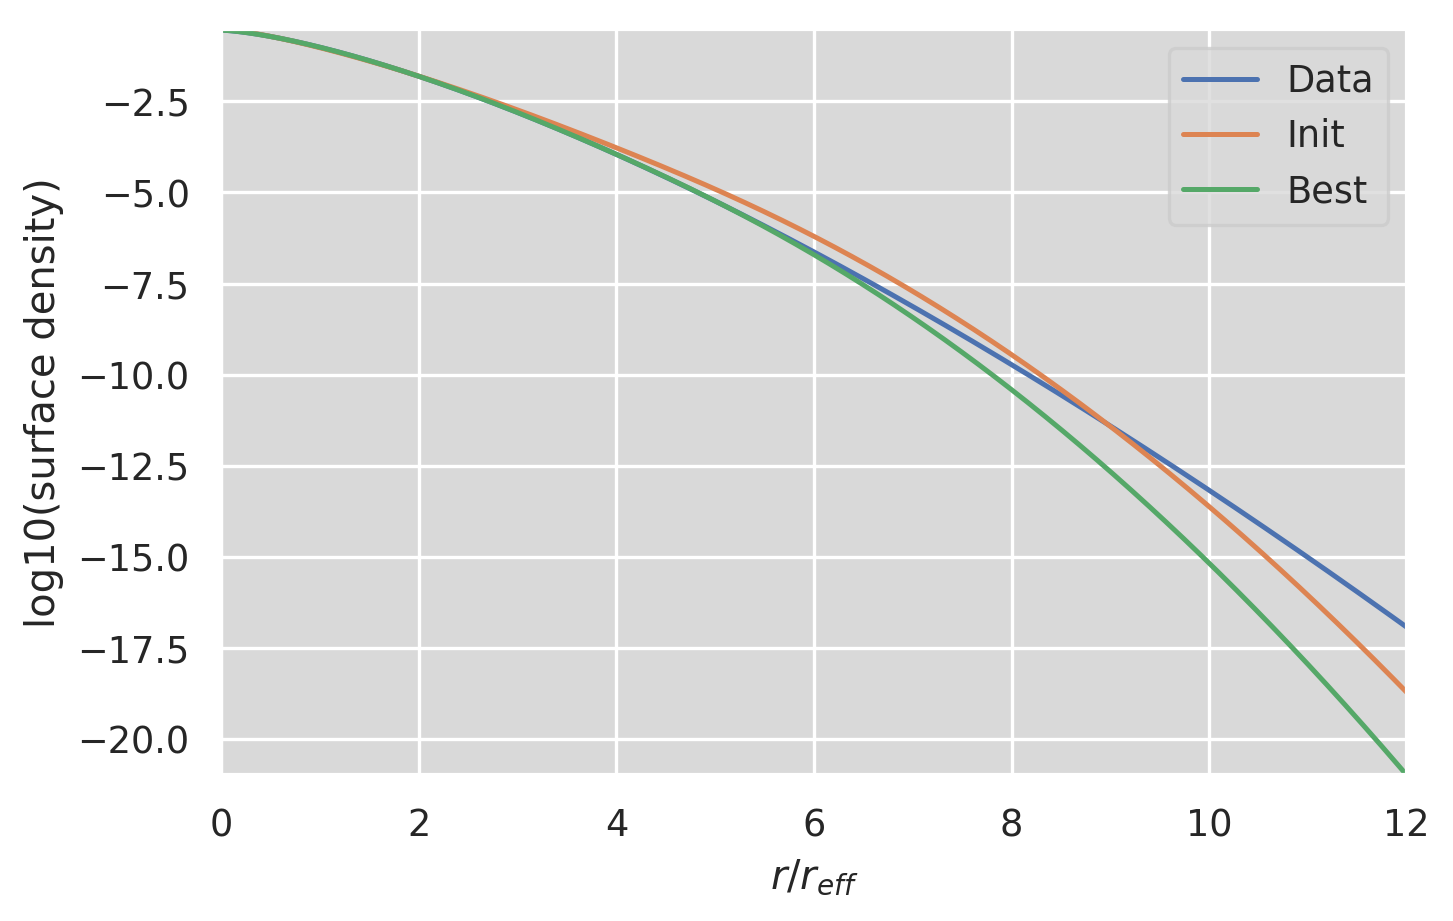

1.000000017532151 1.0000000182584923
Init  chisq = -6.812053504566393
ws, re: (array([0.11587736, 0.44937374, 0.31933869, 0.09418614, 0.01847811,
       0.00274596]), array([1.50858404, 1.18270647, 0.87020347, 0.5908365 , 0.36842091,
       0.2062253 ]))
         Current function value: -11.749242
         Iterations: 143
         Function evaluations: 2612
         Gradient evaluations: 200
-11.749242425948415 [-1.03647729  0.8126692   1.57987729  1.93635539  2.45160893  0.12351295
  0.01643889 -0.13169752 -0.32689105 -0.57317194 -0.90712598]
1.000000017532151 1.0000000174458115
n=0.65: (
    normalize(np.array([2.6183027504e-01, 5.1131393105e-01, 1.8810590649e-01, 3.3865510527e-02, 4.4969433749e-03, 3.8743351832e-04])),
    np.array([1.3289631973e+00, 1.0385774455e+00, 7.3841834696e-01, 4.7109549871e-01, 2.6719483672e-01, 1.2384372936e-01]),
),


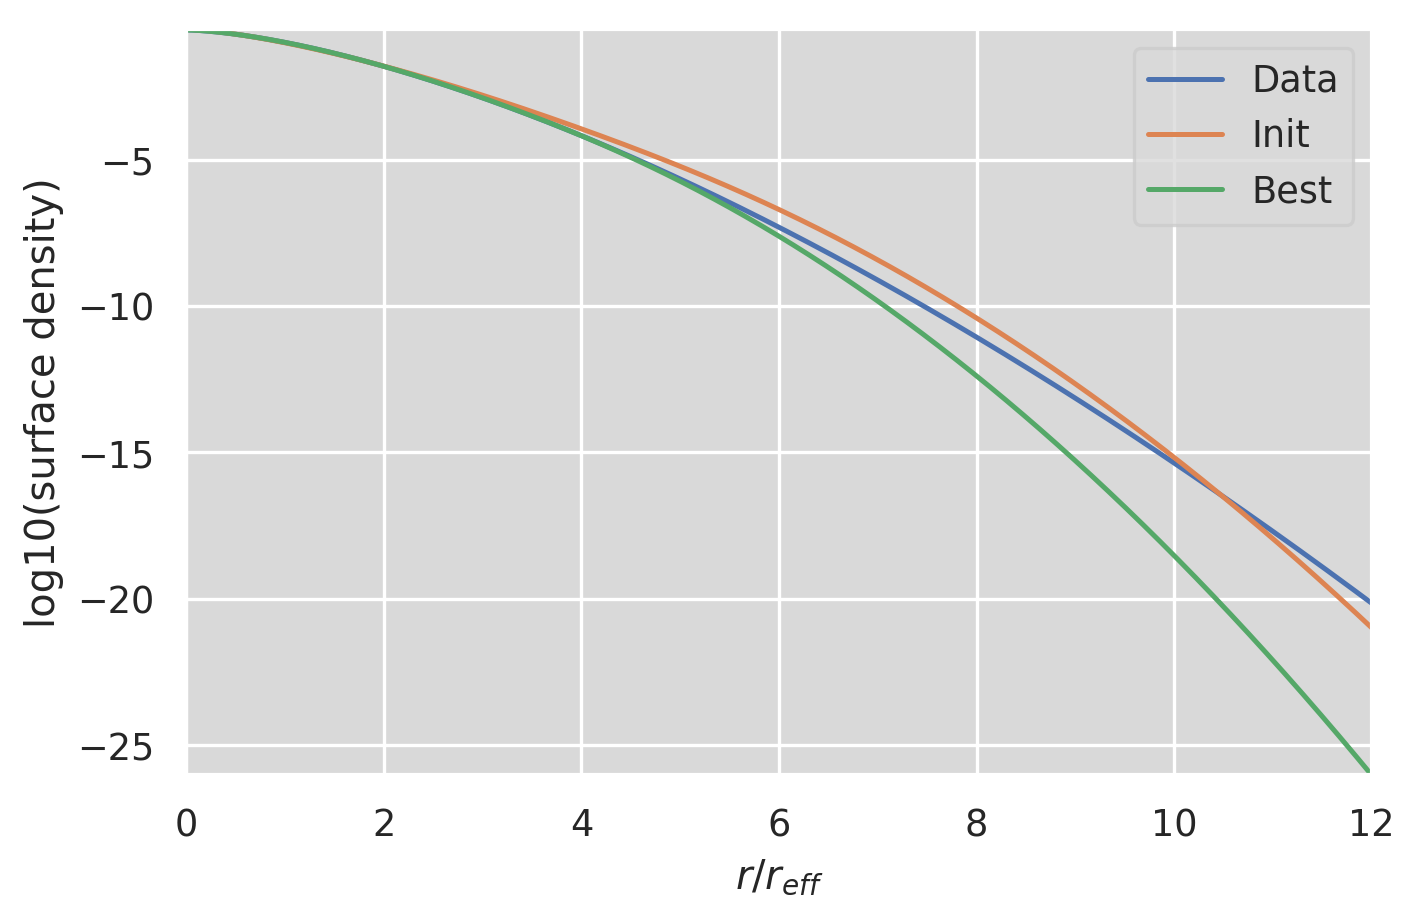

Init  chisq = -7.6095141772703165
ws, re: (array([0.40998043, 0.48679061, 0.09050881, 0.01203523, 0.00068493]), array([1.195 , 0.9656, 0.67  , 0.45  , 0.208 ]))
         Current function value: -11.443792
         Iterations: 47
         Function evaluations: 1211
         Gradient evaluations: 109
-11.443792062155998 [-0.34143151  1.51220842  2.13986148  2.59408027  0.08122373 -0.02055728
 -0.18595349 -0.42055999 -0.74691955]
n=0.6: (
    normalize(np.array([4.1546178873e-01, 4.7896375027e-01, 9.4459324448e-02, 1.0342408068e-02, 7.7272848509e-04])),
    np.array([1.2056568803e+00, 9.5376794968e-01, 6.5169818599e-01, 3.7969948423e-01, 1.7909375620e-01]),
),
1.0000000159710858 1.00000001632613
Init  chisq = -7.481980375282093
ws, re: (array([0.41546179, 0.47896375, 0.09445932, 0.01034241, 0.00077273]), array([1.20565688, 0.95376795, 0.65169819, 0.37969948, 0.17909376]))
         Current function value: -11.763399
         Iterations: 81
         Function evaluations: 1584
         Gradi

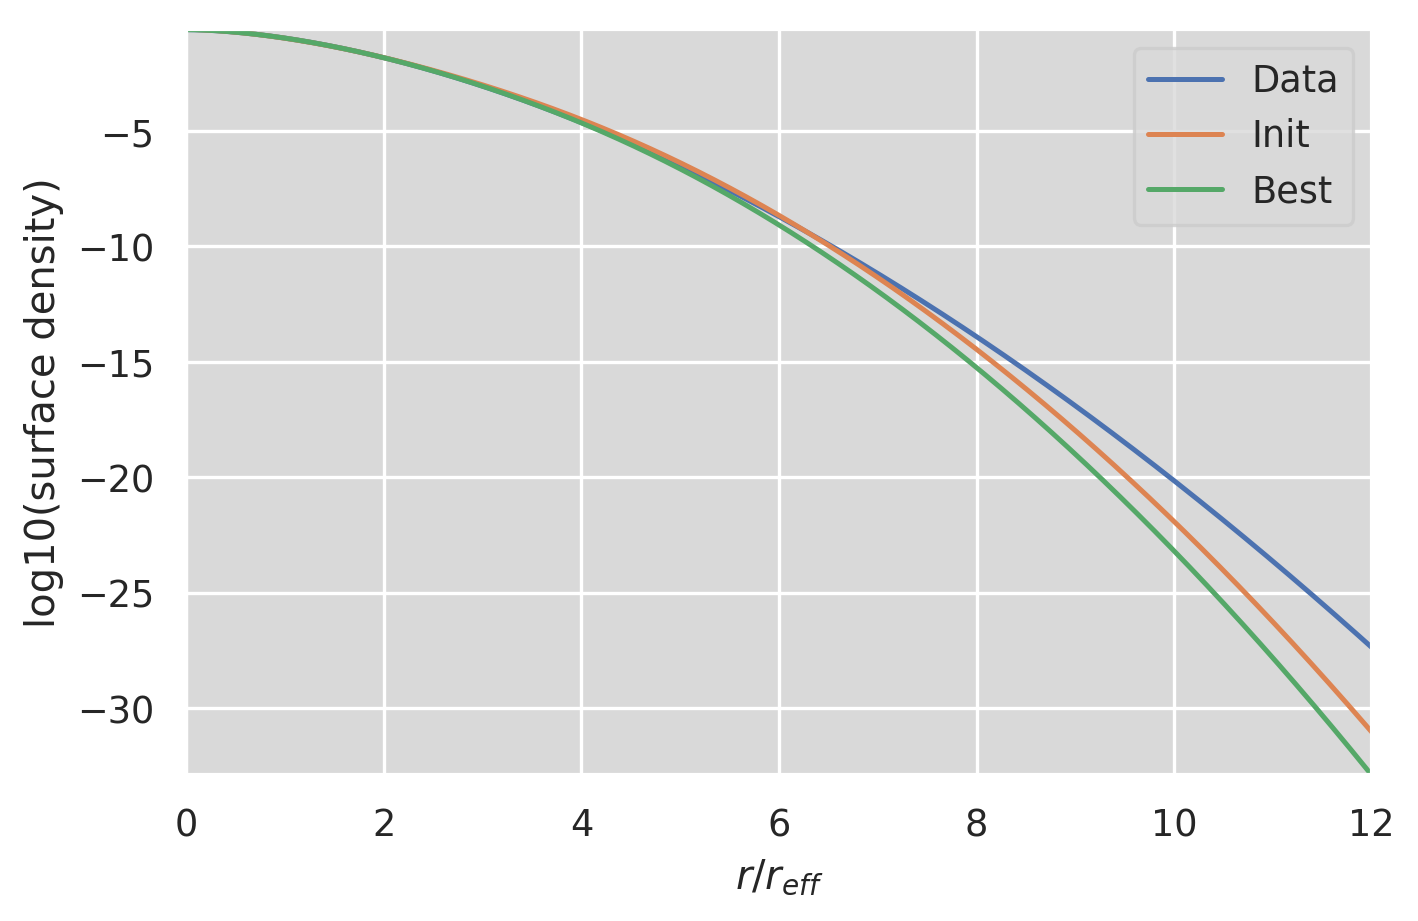

Init  chisq = -7.452188946154672
ws, re: (array([0.45627441, 0.4580142 , 0.07727318, 0.00786766, 0.00057055]), array([1.16834676, 0.94363227, 0.65093086, 0.38085302, 0.18069825]))
         Current function value: -12.151353
         Iterations: 97
         Function evaluations: 2013
         Gradient evaluations: 182
-12.151352723716515 [ 0.05535496  1.89423432  2.30636739  2.66082724  0.05289775 -0.03031657
 -0.18894567 -0.42170119 -0.74379745]
n=0.56: (
    normalize(np.array([5.1383520859e-01, 4.2259270295e-01, 5.7812648759e-02, 5.3832054183e-03, 3.7623428159e-04])),
    np.array([1.1295299365e+00, 9.3257427802e-01, 6.4722357532e-01, 3.7870305436e-01, 1.8038588490e-01]),
),
Init  chisq = -6.391817710965432
ws, re: (array([0.31176674, 0.50952197, 0.15184782, 0.02387212, 0.00299134]), array([1.26358302, 1.00696536, 0.72107801, 0.46050732, 0.26211134]))
         Current function value: -12.387044
         Iterations: 232
         Function evaluations: 3752
         Gradient evaluations

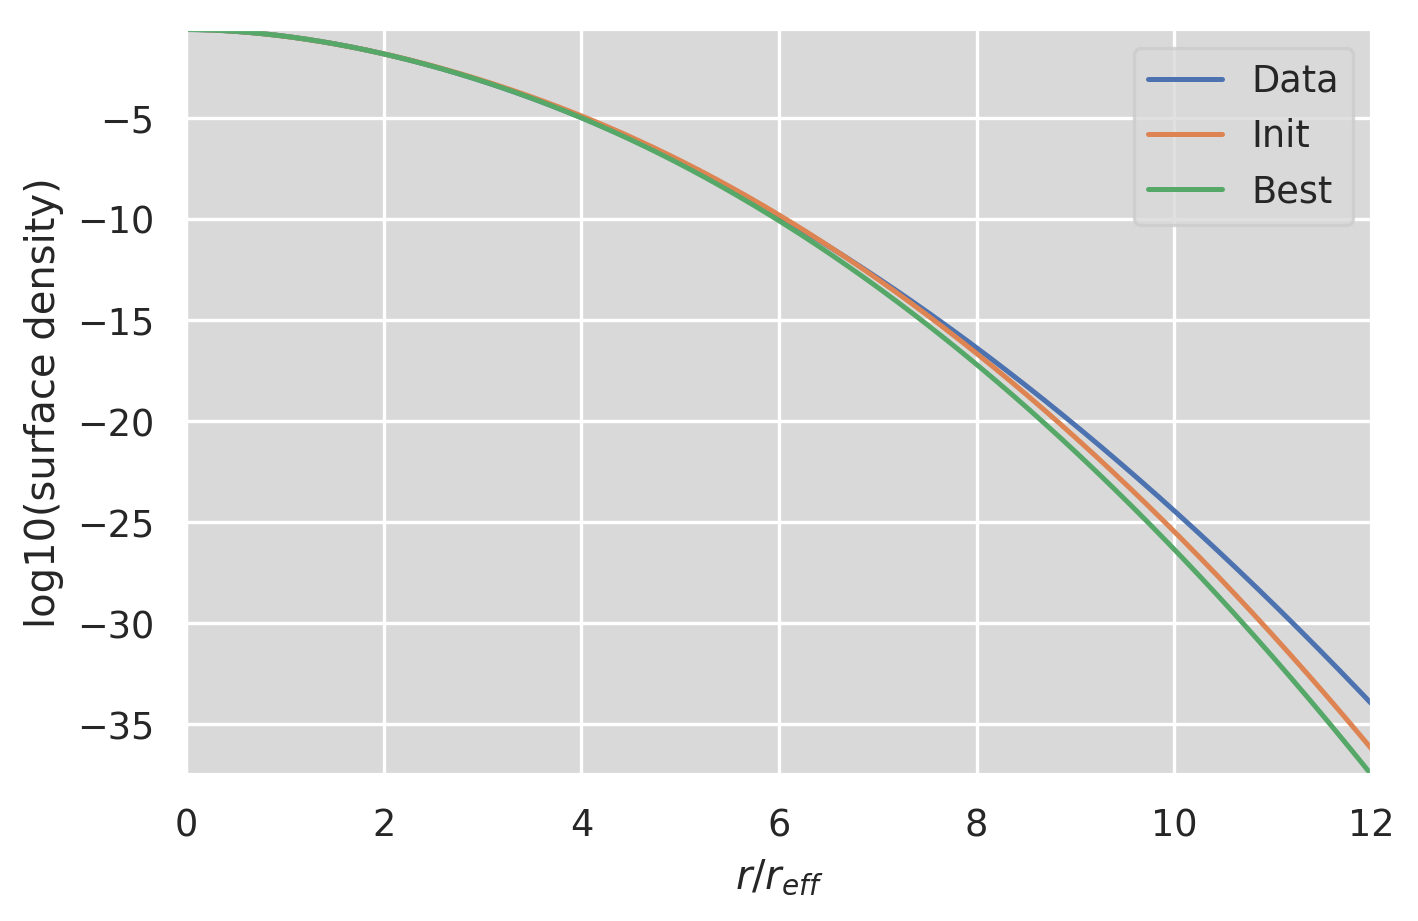

Init  chisq = -8.605663213534255
ws, re: (array([5.99198291e-01, 3.59488014e-01, 3.77713613e-02, 3.31450699e-03,
       2.27827024e-04]), array([1.08885318, 0.92149653, 0.64439709, 0.379284  , 0.18209937]))
         Current function value: -12.821095
         Iterations: 72
         Function evaluations: 2267
         Gradient evaluations: 205
-12.821095163184612 [ 0.53124641  2.25566855  2.3862771   2.68376608  0.03266247 -0.03731978
 -0.19304865 -0.42346368 -0.74166593]
n=0.535: (
    normalize(np.array([6.2977376980e-01, 3.3510596744e-01, 3.2162253723e-02, 2.7688795476e-03, 1.8912949458e-04])),
    np.array([1.0781085002e+00, 9.1765666119e-01, 6.4113774567e-01, 3.7716928873e-01, 1.8127339665e-01]),
),
1.000000014984337 1.0000000150648582
Init  chisq = -8.597601421155877
ws, re: (array([6.29773770e-01, 3.35105967e-01, 3.21622537e-02, 2.76887955e-03,
       1.89129495e-04]), array([1.0781085 , 0.91765666, 0.64113775, 0.37716929, 0.1812734 ]))
         Current function value: -12.99704

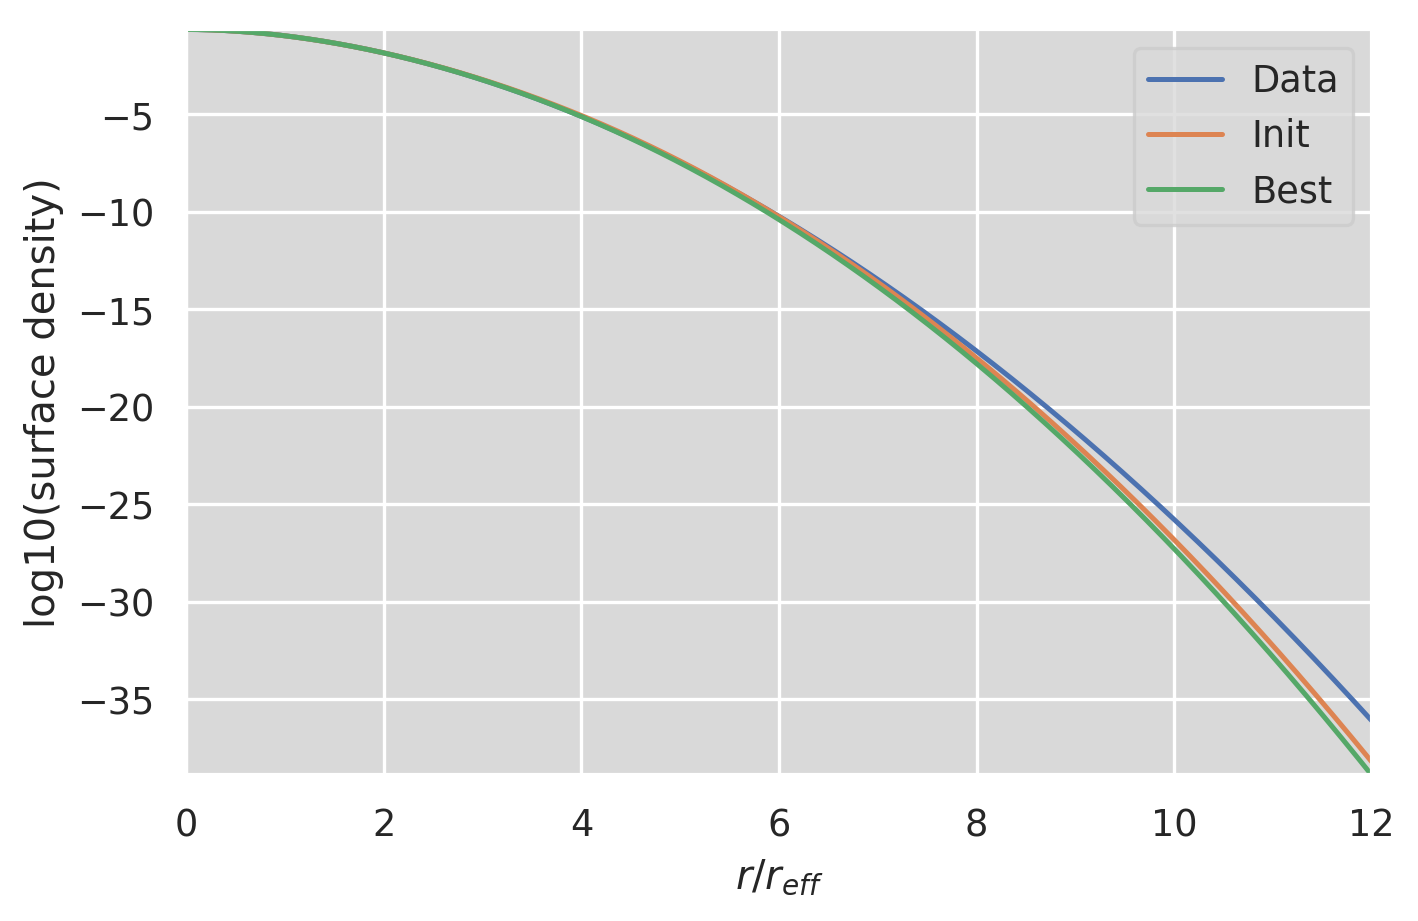

Init  chisq = -8.034436622248457
ws, re: (array([0.59933484, 0.35956993, 0.03777997, 0.00331526]), array([1.08885318, 0.92149653, 0.64439709, 0.379284  ]))
         Current function value: -11.866127
         Iterations: 73
         Function evaluations: 1191
         Gradient evaluations: 131
-11.86612675237935 [ 1.03949797  2.74177944  2.94245234  0.0252867  -0.05665531 -0.25646952
 -0.57025258]
n=0.53: (
    normalize(np.array([7.3875312820e-01, 2.4542769471e-01, 1.5026724116e-02, 7.9245297099e-04])),
    np.array([1.0599532357e+00, 8.7769714840e-01, 5.5402642897e-01, 2.6899699021e-01]),
),
1.000000014891245 1.0000000149610702
Init  chisq = -8.58937138783239
ws, re: (array([0.73875313, 0.24542769, 0.01502672, 0.00079245]), array([1.05995324, 0.87769715, 0.55402643, 0.26899699]))
         Current function value: -12.063909
         Iterations: 50
         Function evaluations: 1254
         Gradient evaluations: 138
-12.063908737481464 [ 1.20455043  2.8321562   2.95494346  0.02134281

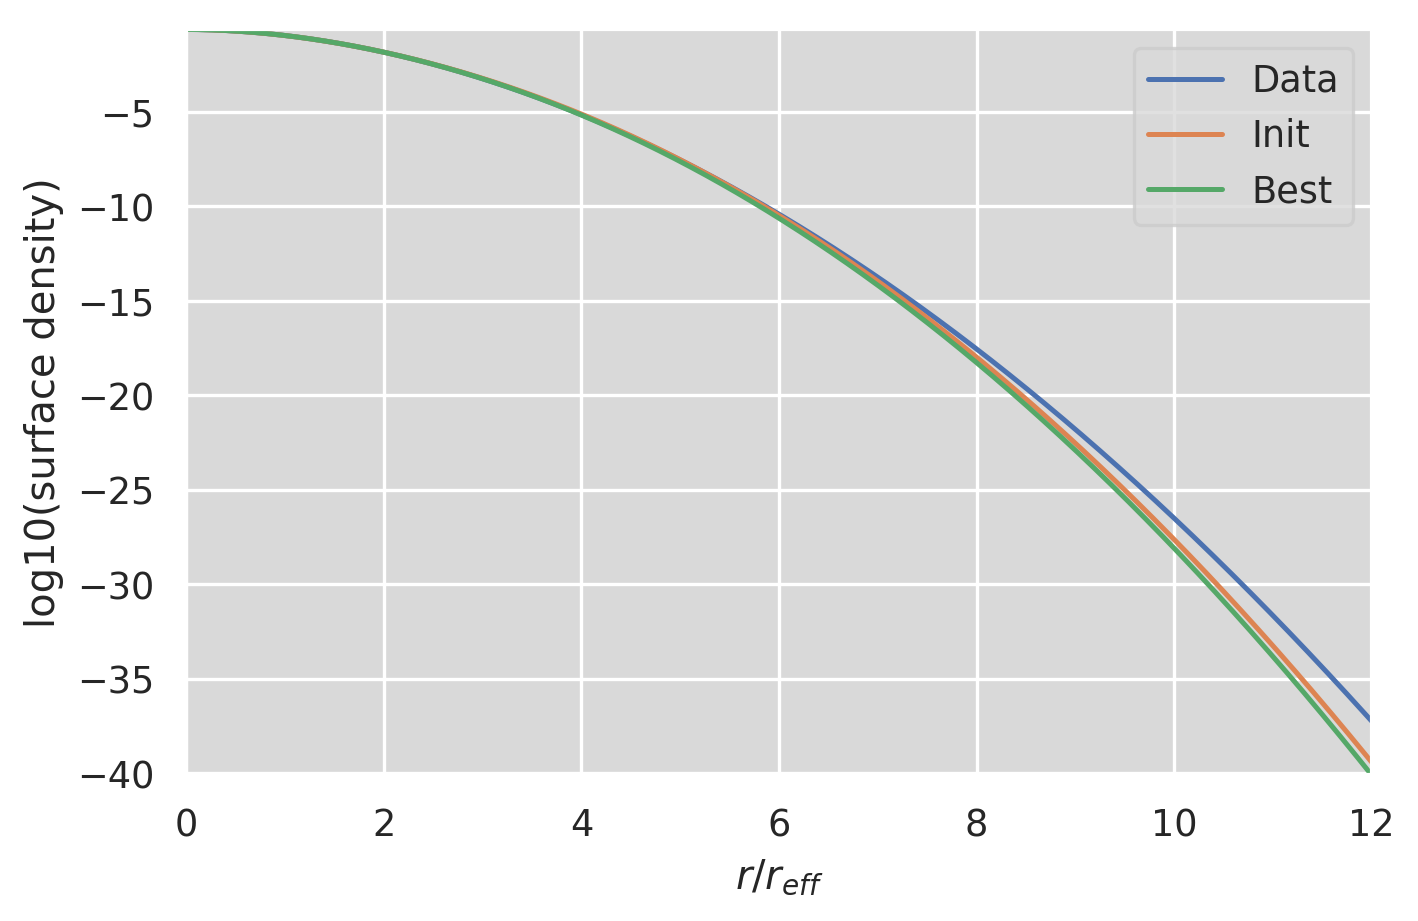

Init  chisq = -8.581147263182615
ws, re: (array([7.69333291e-01, 2.17839091e-01, 1.21926071e-02, 6.35010550e-04]), array([1.05037121, 0.87604763, 0.55238713, 0.26838442]))
         Current function value: -12.298731
         Iterations: 48
         Function evaluations: 992
         Gradient evaluations: 109
-12.29873135983647 [ 1.40175766  2.92573599  2.96500193  0.0173523  -0.05789957 -0.25827789
 -0.57114444]
n=0.52: (
    normalize(np.array([8.0246265385e-01, 1.8748350391e-01, 9.5608797516e-03, 4.9296249415e-04])),
    np.array([1.0407640924e+00, 8.7518613346e-01, 5.5172430276e-01, 2.6844514757e-01]),
),
1.0000000147080328 1.0000000147850436
Init  chisq = -8.572849964440458
ws, re: (array([8.02462654e-01, 1.87483504e-01, 9.56087975e-03, 4.92962494e-04]), array([1.04076409, 0.87518613, 0.5517243 , 0.26844515]))
         Current function value: -12.591653
         Iterations: 62
         Function evaluations: 1569
         Gradient evaluations: 173
-12.591653387057086 [ 1.66793065  3

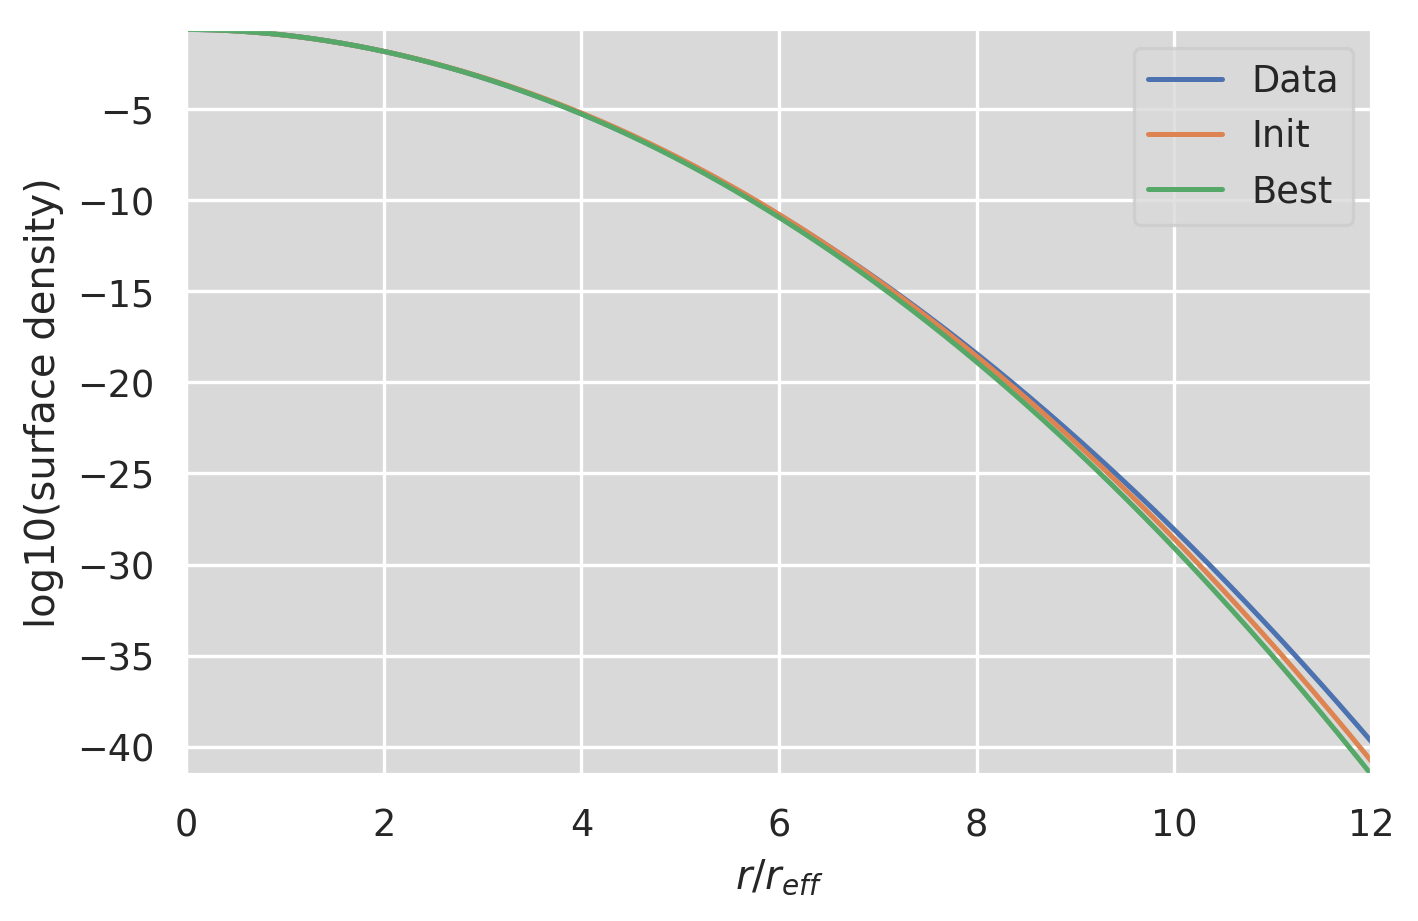

In [8]:
# np.round(10**np.linspace(np.log10(0.5005), np.log10(6.3), num=200), 4)
# First attempt to manually finagle a smooth spline with free weights and radii while gradually removing components
# It does not work very well

# These initial parameters are not terribly important
nvals = [
    (
        np.array([0.501]),
        (normalize(np.array([0.98, 0.02])), np.array([1.01, 0.9])),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
nvals = [
    (
        np.array([0.507]),
        (
    normalize(np.array([8.7013734755e-01, 1.2619085952e-01, 3.6717929279e-03])),
    np.array([1.0339248832e+00, 8.1955230658e-01, 4.2170643991e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
# The rest of these required working backwards and repeatedly re-starting guesses to produce a smooth spline
nvals = [
    (
        np.array([0.95, 0.9, 0.85, 0.8, 0.75]),
        (
	normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
	np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([0.70]),
        (
    normalize(np.array([1.0845562525e-01, 4.0294151495e-01, 3.2729844440e-01, 1.2246687144e-01, 3.1333936150e-02, 6.3893051250e-03, 1.0137209694e-03])),
    np.array([1.6116987996e+00, 1.2333069456e+00, 9.0359039048e-01, 6.2645430811e-01, 4.0957694795e-01, 2.5288574221e-01, 1.3272691536e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
nvals = [
    (
        np.array([0.65]),
        (
    normalize(np.array([1.1584759935e-01, 4.4925832966e-01, 3.1925666847e-01, 9.4161947089e-02, 1.8473365773e-02, 2.7452558180e-03])),
    np.array([1.5085840400e+00, 1.1827064676e+00, 8.7020346704e-01, 5.9083650141e-01, 3.6842090584e-01, 2.0622530253e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
nvals = [
    (
        np.array([0.6, 0.58, 0.56]),
        (
            normalize(np.array([4.19e-01        , 4.975e-01       , 9.25e-02        , 1.23e-02        , 7.0e-04])),
            np.array([1.195e+00       , 9.656e-01       , 6.7e-01       , 4.5e-01       , 2.08e-01        ]),
        )
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([0.55, 0.54, 0.535, 0.53]),
        (
    normalize(np.array([3.1168895061e-01, 5.0939483801e-01, 1.5180993252e-01, 2.3866167881e-02, 2.9905915132e-03])),
    np.array([1.2635830241e+00, 1.0069653570e+00, 7.2107800516e-01, 4.6050732036e-01, 2.6211133918e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([0.53, 0.525, 0.52, 0.515]),
        (
    normalize(np.array([5.9919829101e-01, 3.5948801370e-01, 3.7771361281e-02, 3.3145069862e-03])),
    np.array([1.0888531764e+00, 9.2149653125e-01, 6.4439708848e-01, 3.7928399702e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)

## Why can't you just fit N components down to n=0.5?

You can try, but it doesn't work well below n=0.6 as the smallest component(s) gradually reduce their weights to near-zero values. Once this happens, it becomes very difficult to ensure smooth changes in the best-fit weight even given small changes in n - the best-fit weights are essentially 'noisy'.

In [ ]:
# Now try to work backwards in finely-spaced bins from n=1 with eight components and see where it breaks down
nspaced = np.linspace(1, 0.5, num=100, endpoint=False)
nvals = [
    (
        nspaced,
        (
	normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
	np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, plotnth=10)

## Fitting weights with fixed, linearly-extrapolated sizes for n < 1

In the plots at the end of this notebook, it's clear that the best-fit *sizes* change nearly linearly from about n=1 to n=0.7. With appropriate choices for the slope of r vs n for each Gaussian, it's possible to fit smoothly-varying weights even for N=8.

In [ ]:
# Let's try one more approach. From n=0.7 to n=1, log(n) vs log(rdivre) for the sigmaspline is nearly linear, so just fix those and only fit the weights
x100 = np.log10(np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01,
                          4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02]))
x70 = np.log10(np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01,
                         4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]))
w70 =     normalize(np.array([1.1646435020e-01, 4.2739124945e-01, 3.1922751878e-01, 1.0653680383e-01,
                              2.4816881868e-02, 4.7669777519e-03, 7.2686739303e-04, 6.9350722705e-05])),
slopes = (x100-x70)/-np.log10(0.7)
print(slopes)
# That did not actually work well below n<0.7, which was the whole point, so let's try again
x50 = np.array([0])
slopes[:len(x50)] = (x100[:len(x50)]-x50)/-np.log10(0.5/1.0)
slopes[4] = 0
print(slopes)

class RadiusExtrapolator:
    # Straight n=0.7 slopes
    # delta = np.array([1.11799858, 0.89465879, 0.49097738,  0.21019219, 0.19796296, -0.07311309, -0.49345005, -0.88741601])
    # Adjusted slopes
    # delta = np.array([1.21540882, 1.20028606, 0.68721482, 0.66704026, 0.45818359, 0.19252795, -0.67281483, -1.29645156])
    delta = np.array([1.11799858, 0.7, 0.35, 0.2, 0., -0.2, -0.4, -0.6])
    #xref = np.log10(np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01, 4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]))
    xref = np.log10(np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02]))
    nref = 1.0
    @staticmethod
    def r(nsersic):
        return(RadiusExtrapolator.xref + RadiusExtrapolator.delta*np.log10(nsersic/RadiusExtrapolator.nref))

for n in [1, 0.75, 0.5]:
    print(n, 10**RadiusExtrapolator.r(n))

nvals = [
    (
        np.array([
            1.0, 0.975, 0.95, 0.925, 0.9, 0.875, 0.85, 0.825, 0.8,
            0.775, 0.75, 0.725, 0.7, 0.675, 0.65, 0.625, 0.6, 0.59,
            0.58, 0.57, 0.56, 0.55, 0.545, 0.54, 0.535, 0.53, 0.525,
            0.52, 0.518, 0.516, 0.514, 0.512, 0.51, 0.509, 0.508,
            0.507, 0.506, 0.505, 0.504, 0.503, 0.502, 0.501, 0.5
        ]),
        (
	normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
	np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, funcrdivreslog=RadiusExtrapolator.r, plotnth=np.Inf, plotvals=[1., 0.85, 0.7, 0.6, 0.55, 0.53, 0.52, 0.51, 0.505, 0.501])

## Fitting large n profiles

Up to n=2.5, we continue from the exponential solution. Beyond n=2.5, it becomes very difficult to fit the outer profile because more of the Gaussian components trend to tiny sizes. By masking the inner bins, we can limit this issue and ensure a nearly constant central surface brightness. In the real universe, most massive nearby ellipticals don't have the steep cusp of an n>4 profile - only the outer part is well-approximated by an n>4 profile. Kormendy & co. discuss this at length in a number of papers, hypothesizing that the shallow inner cores are due to massive black holes scattering stars and scouring the inner regions of stars. It could be possible that higher-redshift ellipticals and/or recent merger remnants do have very cuspy centers, but these are probably merger-induced and distinct enough from the rest of the galaxy that they should be considered a separate component.

In [ ]:
# Fit for n>1. It works well enough up to n=2
# For n>2, the steep cusp requires components to migrate in further and further, degrading the quality of the fit at R/Re > 4
# Since we aren't convinced that real galaxies are that cuspy, we skip fitting a small fraction of the interior profile
# The arbitrary fraction I picked scales as a sinusoid from 0 at n=1 to 0.5*0.12 at n=4 and caps at 0.12 at n=7.
# The sinusoidal function is a reasonable choice for its continuous derivatives
def funcrangefitn(radii, n):
    nbins = len(radii)
    facn = (np.sin((n-4)/6*np.pi)+1.)/2.
    # np.int(np.floor(nbins*(1-facn/3.)))
    ranges = [np.int(np.round(facn*nbins/100.)), nbins]
    print(ranges)
    return range(ranges[0], ranges[1])

# Close to np.round(10**np.linspace(np.log10(0.5005), np.log10(6.3), num=100), 4)

nvals = [
    (
        np.array([
            1., 1.025, 1.05, 1.075, 1.10, 1.135, 1.165, 1.2, 1.225, 1.25, 1.275,
            1.3, 1.333, 1.367, 1.4, 1.433, 1.467, 1.5, 1.55, 1.6, 1.65, 1.7,
            1.75, 1.8, 1.85, 1.9 , 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3,
            2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9,
            2.95, 3., 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5,
            3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4., 4.1, 4.2,
            4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5., 5.1, 5.2, 5.3, 5.4, 5.5,
            5.6, 5.7, 5.8, 5.9, 6., 6.15, 6.3, 6.45, 6.6, 6.75, 7, 7.25, 7.5,
            7.75, 8,
        ]),
        (
            normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01,
                                6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
            np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01,
                      2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, funcrangefit=funcrangefitn, plotnth=np.Inf, plotvals=[1., 1.2, 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 6., 7., 8.])

### 4-Component Sersic MGA

Unsurprisingly, 4 Gaussians is not enough to accurately approximate a Sersic profile as you'll see below, but it's useful as a starting point for free MG fits.

In [ ]:
# Despite my best efforts, free weights and sizes don't work for N=4 either:
nvals = [
    (
        np.array([
            0.53, 0.525, 0.52,
        ]),
        (
    normalize(np.array([5.9919829101e-01, 3.5948801370e-01, 3.7771361281e-02, 3.3145069862e-03])),
    np.array([1.0888531764e+00, 9.2149653125e-01, 6.4439708848e-01, 3.7928399702e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=3)
nvals = [
    (
        np.array([
            0.518, 0.516, 0.514, 0.512, 0.51,
        ]),
        (
    normalize(np.array([8.0246265385e-01, 1.8748350391e-01, 9.5608797516e-03, 4.9296249415e-04])),
    np.array([1.0407640924e+00, 8.7518613346e-01, 5.5172430276e-01, 2.6844514757e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([
            0.509, 0.508, 0.507, 0.506, 0.505, 0.504, 0.503, 0.502, 0.501, 0.5
        ]),
        (
            normalize(np.array([8.8519826027e-01, 1.1005198944e-01, 4.5203904184e-03, 2.2935986869e-04])),
            np.array([1.0208738812e+00, 8.7334319737e-01, 5.4919444425e-01, 2.6792742286e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=3)

In [ ]:
# Fit for n < 1. Use a fixed radius for n<0.6
nvals = [
    (
        np.array([
            0.975, 0.95, 0.925, 0.9, 0.875, 0.85, 0.825, 0.8,
            0.775, 0.75, 0.725, 0.7, 0.675, 0.65, 0.625, 0.6,
        ]),
        (
    normalize(np.array([3.2466847784e-01, 4.7803210251e-01, 1.7258586760e-01, 2.4713552046e-02])),
    np.array([1.7007792632e+00, 9.7809127671e-01, 5.1487137336e-01, 2.1966932363e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=4)

def radiuslogextrapmgfour(n):
    return np.log10(np.array([1.0, 0.868, 0.556, 0.272]) + 10*(n-0.5)*(
        np.array([1.1815216222e+00, 8.9789169364e-01, 5.5712450495e-01, 2.6664192455e-01]) -
        np.array([1.0, 0.868, 0.556, 0.272])))

for n in [0.6, 0.55, 0.5]:
    print(n, 10**radiuslogextrapmgfour(n))
    
nvals = [
    (
        np.array([
            0.59, 0.58, 0.57, 0.56, 0.55, 0.545, 0.54, 0.535, 0.53,
            0.525, 0.52, 0.518, 0.516, 0.514, 0.512, 0.51, 0.509,
            0.508, 0.507, 0.506, 0.505, 0.504, 0.503, 0.502, 0.501, 0.5
        ]),
        (
            normalize(
                np.array([5.1668620161e-01, 4.2422360341e-01, 5.5463315784e-02, 3.6268791954e-03])),
            np.array([1.1815216222e+00, 8.9789169364e-01, 5.5712450495e-01, 2.6664192455e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiuslogextrapmgfour, plotnth=5)

In [ ]:
# Fit the softened Sersic from n=1 to n=8
nvals = [
    (
        np.array([
            1., 1.025, 1.05, 1.075, 1.10, 1.135, 1.165, 1.2, 1.225, 1.25, 1.275,
            1.3, 1.333, 1.367, 1.4, 1.433, 1.467, 1.5, 1.55, 1.6, 1.65, 1.7,
            1.75, 1.8, 1.85, 1.9 , 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3,
            2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9,
            2.95, 3., 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5,
            3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4., 4.1, 4.2,
            4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5., 5.1, 5.2, 5.3, 5.5, 5.5,
            5.6, 5.7, 5.8, 5.9, 6., 6.15, 6.3, 6.45, 6.6, 6.75, 7, 7.25, 7.5,
            7.75, 8,
        ]),
        (
            normalize(np.array([3.2466847784e-01, 4.7803210251e-01, 1.7258586760e-01, 2.4713552046e-02])),
            np.array([1.7007792632e+00, 9.7809127671e-01, 5.1487137336e-01, 2.1966932363e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrangefit=funcrangefitn, plotnth=np.Inf, plotvals=[1., 1.2, 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 6., 7., 8.])

# To grep only the weights from the fit log:
# grep -C 2 normalize file.txt | grep [\(\)] | sed "s/n=//g"
# In reverse order add: | awk '{a[i++]=$0} END {for (j=i-1; j>=0;) { print a[j-3]; print a[j-2]; print a[j-1]; print a[j]; j-=4;}}'

## The graveyard of failed ideas

These are best-fit weights from the unsuccesful attempts - keeping both the weights and sizes free and either dropping components manually or keeping N=8 fixed and hoping for the best. We'll plot these up later along with the more successful fixed size below n=1 approach.

In [9]:
# Test out various spline weighting methods
# This first one is S-M-R-T I mean S-M-A-R-T
weightvarssmrtrev = {
    1.0: (
        normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
        np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
    ),
    0.95: (
        normalize(np.array([8.1403269909e-02, 3.2580644822e-01, 3.4058504404e-01, 1.7513222856e-01, 5.9192552167e-02, 1.4829085839e-02, 2.7394820156e-03, 3.1188925295e-04])),
        np.array([2.0580646746e+00, 1.4290161052e+00, 9.7686981214e-01, 6.4569266618e-01, 4.0748443014e-01, 2.4091847021e-01, 1.2844509011e-01, 5.5475573206e-02]),
    ),
    0.9: (
        normalize(np.array([8.3272428552e-02, 3.3761909938e-01, 3.4261897732e-01, 1.6737529882e-01, 5.3685032163e-02, 1.2877296215e-02, 2.2983216755e-03, 2.5354586925e-04])),
        np.array([1.9527835416e+00, 1.3873099285e+00, 9.6414763955e-01, 6.4496927062e-01, 4.1081182437e-01, 2.4485938373e-01, 1.3161541508e-01, 5.7397686985e-02]),
    ),
    0.85: (
        normalize(np.array([8.8648139071e-02, 3.5515361752e-01, 3.4150494943e-01, 1.5534344140e-01, 4.6674515325e-02, 1.0649023584e-02, 1.8309459995e-03, 1.9536767345e-04])),
        np.array([1.8404078380e+00, 1.3380994716e+00, 9.4543542703e-01, 6.3983409725e-01, 4.1113219993e-01, 2.4697493906e-01, 1.3384622629e-01, 5.8963889270e-02]),
    ),
    0.8: (
        normalize(np.array([9.5687123517e-02, 3.7600373993e-01, 3.3791793777e-01, 1.4102874894e-01, 3.9315698812e-02, 8.4969058837e-03, 1.4050252856e-03, 1.4481985933e-04])),
        np.array([1.7282573092e+00, 1.2882067554e+00, 9.2633448695e-01, 6.3439449883e-01, 4.1120486913e-01, 2.4896361205e-01, 1.3607248303e-01, 6.0593077676e-02]),
    ),
    0.75: (
        normalize(np.array([1.0845562525e-01, 4.0294151495e-01, 3.2729844440e-01, 1.2246687144e-01, 3.1333936150e-02, 6.3893051250e-03, 1.0137209694e-03, 1.0058171985e-04])),
        np.array([1.6116987996e+00, 1.2333069456e+00, 9.0359039048e-01, 6.2645430811e-01, 4.0957694795e-01, 2.5288574221e-01, 1.3272691536e-01, 6.1993912159e-02]),
    ),
    0.7: (
        normalize(np.array([1.1584759935e-01, 4.4925832966e-01, 3.1925666847e-01, 9.4161947089e-02, 1.8473365773e-02, 2.7452558180e-03, 2.5683384766e-04, 0])),
        np.array([1.5085840400e+00, 1.1827064676e+00, 8.7020346704e-01, 5.9083650141e-01, 3.6842090584e-01, 2.0622530253e-01, 9.4309343285e-02, 6.3000000000e-02]),
    ),
    0.65: (
        normalize(np.array([2.6183027504e-01, 5.1131393105e-01, 1.8810590649e-01, 3.3865510527e-02, 4.4969433749e-03, 3.8743351832e-04, 0, 0])),
        np.array([1.3289631973e+00, 1.0385774455e+00, 7.3841834696e-01, 4.7109549871e-01, 2.6719483672e-01, 1.2384372936e-01, 3.0000000000e-02, -1]),
    ),
    0.60: (
        normalize(np.array([4.1546178873e-01, 4.7896375027e-01, 9.4459324448e-02, 1.0342408068e-02, 7.7272848509e-04, 0, 0, 0])),
        np.array([1.2056568803e+00, 9.5376794968e-01, 6.5169818599e-01, 3.7969948423e-01, 1.7909375620e-01, 4.0e-2, -1, -1]),
    ),
    #0.58: (
    #    normalize(np.array([4.5627440940e-01, 4.5801419853e-01, 7.7273178826e-02, 7.8676616590e-03, 5.7055159001e-04, 0, 0, 0])),
    #    np.array([1.1683467566e+00, 9.4363227290e-01, 6.5093086112e-01, 3.8085301923e-01, 1.8069824796e-01, -1, -1, -1]),
    #),
    0.56: (
        normalize(np.array([5.1383520859e-01, 4.2259270295e-01, 5.7812648759e-02, 5.3832054183e-03, 3.7623428159e-04, 0, 0, 0])),
        np.array([1.1295299365e+00, 9.3257427802e-01, 6.4722357532e-01, 3.7870305436e-01, 1.8038588490e-01, -1, -1, -1]),
    ),
    0.55: (
        normalize(np.array([5.5214529709e-01, 3.9529450455e-01, 4.7928536367e-02, 4.3319689703e-03, 2.9969302520e-04, 0, 0, 0])),
        np.array([1.1094018518e+00, 9.2705543556e-01, 6.4619989426e-01, 3.7926137736e-01, 1.8130968040e-01, -1, -1, -1]),
    ),
    0.54: (
        normalize(np.array([5.9919829101e-01, 3.5948801370e-01, 3.7771361281e-02, 3.3145069862e-03, 2.2782702383e-04, 0, 0, 0])),
        np.array([1.0888531764e+00, 9.2149653125e-01, 6.4439708848e-01, 3.7928399702e-01, 1.8209937478e-01, -1, -1, -1]),
    ),
    0.535: (
        normalize(np.array([6.3126439025e-01, 3.3392767586e-01, 3.1879935445e-02, 2.7407850764e-03, 1.8721337590e-04, 0, 0, 0])),
        np.array([1.0779584267e+00, 9.1705503997e-01, 6.4002041507e-01, 3.7627159296e-01, 1.8081161389e-01, -1, -1, -1]),
    ),
    0.515: (
        normalize(np.array([8.4097559276e-01, 1.5169627279e-01, 6.9714772900e-03, 3.5665715873e-04, 0, 0, 0, 0])),
        np.array([1.0309116597e+00, 8.7408078966e-01, 5.5036185175e-01, 2.6808638784e-01, 1.60e-01, -1, -1, -1]),
    ),
    0.507: (
        normalize(np.array([9.4662548327e-01, 5.2171305034e-02, 1.2032116992e-03, 0, 0, 0, 0, 0])),
        np.array([1.0122615136e+00, 8.2195507899e-01, 4.2112943705e-01, 1.5e-1, -1, -1, -1, -1]),
    ),
    0.501: (
        normalize(np.array([9.9645469317e-01, 3.5453068336e-03, 0, 0, 0, 0, 0, 0])),
        np.array([1.0012334877e+00, 7.1605157116e-01, 3.2e-1, -1, -1, -1, -1, -1]),
    ),
}
weightvarssmrt = {key: weightvarssmrtrev[key] for key in list(weightvarssmrtrev.keys())[::-1]}

weightvarslinrev = {
    1.0: (
        normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
        np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
    ),
    0.995: (
        normalize(np.array([7.8446183932e-02, 3.1406434947e-01, 3.3932384870e-01, 1.8296223981e-01, 6.4764639051e-02, 1.6854415782e-02, 3.2090104756e-03, 3.7531277364e-04])),
        np.array([2.1583165776e+00, 1.4713798133e+00, 9.9276532523e-01, 6.4986444561e-01, 4.0693622906e-01, 2.3891710322e-01, 1.2647686885e-01, 5.4168977602e-02]),
    ),
    0.99: (
        normalize(np.array([7.8748882011e-02, 3.1527662000e-01, 3.3948179457e-01, 1.8216089349e-01, 6.4173199336e-02, 1.6633815653e-02, 3.1566703056e-03, 3.6812463680e-04])),
        np.array([2.1471476039e+00, 1.4667048040e+00, 9.9104503426e-01, 6.4944861490e-01, 4.0703634466e-01, 2.3916382111e-01, 1.2670689594e-01, 5.4317404722e-02]),
    ),
    0.985: (
        normalize(np.array([7.8994186452e-02, 3.1641620349e-01, 3.3968469926e-01, 1.8140525885e-01, 6.3605998603e-02, 1.6424599579e-02, 3.1076505756e-03, 3.6140318626e-04])),
        np.array([2.1362142657e+00, 1.4622314919e+00, 9.8948045158e-01, 6.4914027013e-01, 4.0722153691e-01, 2.3947910549e-01, 1.2698412679e-01, 5.4487684484e-02]),
    ),
    0.98: (
        normalize(np.array([7.8389101272e-02, 3.1638765311e-01, 3.4043547772e-01, 1.8156010509e-01, 6.3463387972e-02, 1.6329208096e-02, 3.0783508966e-03, 3.5671584639e-04])),
        np.array([2.1282781338e+00, 1.4604809912e+00, 9.9010354726e-01, 6.5040118063e-01, 4.0839544944e-01, 2.4033837843e-01, 1.2751651151e-01, 5.4759268657e-02]),
    ),
    0.975: (
        normalize(np.array([7.8492259575e-02, 3.1733990238e-01, 3.4064424822e-01, 1.8096336632e-01, 6.3017149586e-02, 1.6156519811e-02, 3.0357224100e-03, 3.5083170430e-04])),
        np.array([2.1178361862e+00, 1.4564466460e+00, 9.8896894906e-01, 6.5051832346e-01, 4.0890150279e-01, 2.4083944712e-01, 1.2788064118e-01, 5.4971854773e-02]),
    ),
    0.97: (
        normalize(np.array([7.8803523011e-02, 3.1858245887e-01, 3.4085154814e-01, 1.8013538246e-01, 6.2376851464e-02, 1.5922265126e-02, 2.9838701624e-03, 3.4410076591e-04])),
        np.array([2.1066586105e+00, 1.4517852082e+00, 9.8724682936e-01, 6.5003217856e-01, 4.0891261440e-01, 2.4105316221e-01, 1.2812638619e-01, 5.5135777007e-02]),
    ),
    0.965: (
        normalize(np.array([7.9652906813e-02, 3.2064939074e-01, 3.4068122966e-01, 1.7869038231e-01, 6.1466919163e-02, 1.5610725907e-02, 2.9134649523e-03, 3.3498045458e-04])),
        np.array([2.0937412212e+00, 1.4454149529e+00, 9.8410731982e-01, 6.4852336195e-01, 4.0824832753e-01, 2.4081266904e-01, 1.2808520606e-01, 5.5176596936e-02]),
    ),
    0.96: (
        normalize(np.array([8.0576453325e-02, 3.2290280030e-01, 3.4043969613e-01, 1.7709543098e-01, 6.0518663358e-02, 1.5295811356e-02, 2.8452778659e-03, 3.2586667691e-04])),
        np.array([2.0807024304e+00, 1.4388256059e+00, 9.8071976898e-01, 6.4685562505e-01, 4.0752304916e-01, 2.4056824190e-01, 1.2805531444e-01, 5.5198631668e-02]),
    ),
    0.955: (
        normalize(np.array([8.1040966768e-02, 3.2441065469e-01, 3.4047060583e-01, 1.7607117085e-01, 5.9838132967e-02, 1.5058095207e-02, 2.7915913744e-03, 3.1878231861e-04])),
        np.array([2.0692003931e+00, 1.4337627137e+00, 9.7867808047e-01, 6.4620077939e-01, 4.0746271722e-01, 2.4072384138e-01, 1.2824200177e-01, 5.5335703966e-02]),
    ),
    0.95: (
        normalize(np.array([8.1450263763e-02, 3.2585428363e-01, 3.4053884485e-01, 1.7509555332e-01, 5.9182670718e-02, 1.4827402200e-02, 2.7392015200e-03, 3.1177999432e-04])),
        np.array([2.0579132805e+00, 1.4288880244e+00, 9.7678450884e-01, 6.4564909129e-01, 4.0746517450e-01, 2.4090898319e-01, 1.2843833062e-01, 5.5469238331e-02]),
    ),
    0.945: (
        normalize(np.array([8.0838455136e-02, 3.2567038291e-01, 3.4122816179e-01, 1.7534334294e-01, 5.9123091044e-02, 1.4767026054e-02, 2.7206010931e-03, 3.0893902196e-04])),
        np.array([2.0497666873e+00, 1.4271898496e+00, 9.7773166817e-01, 6.4732448277e-01, 4.0900680557e-01, 2.4205144694e-01, 1.2917105921e-01, 5.5858036130e-02]),
    ),
    0.94: (
        normalize(np.array([8.1026477351e-02, 3.2706329786e-01, 3.4151639944e-01, 1.7442331104e-01, 5.8463968941e-02, 1.4536816076e-02, 2.6680176172e-03, 3.0171168430e-04])),
        np.array([2.0392493702e+00, 1.4227973744e+00, 9.7605089889e-01, 6.4682602711e-01, 4.0901861837e-01, 2.4223611781e-01, 1.2935204729e-01, 5.5949712693e-02]),
    ),
    0.935: (
        normalize(np.array([8.2608793996e-02, 3.3016404617e-01, 3.4076708635e-01, 1.7218633093e-01, 5.7242376406e-02, 1.4152019485e-02, 2.5875593775e-03, 2.9178728688e-04])),
        np.array([2.0244694038e+00, 1.4145791883e+00, 9.7135282044e-01, 6.4417273119e-01, 4.0759862723e-01, 2.4155666697e-01, 1.2909300116e-01, 5.5910480934e-02]),
    ),
    0.93: (
        normalize(np.array([8.3195200740e-02, 3.3186613072e-01, 3.4067638530e-01, 1.7101447113e-01, 5.6519105162e-02, 1.3909585516e-02, 2.5342509203e-03, 2.8487050914e-04])),
        np.array([2.0127911244e+00, 1.4093031664e+00, 9.6914649332e-01, 6.4340574832e-01, 4.0746787463e-01, 2.4166861403e-01, 1.2925452558e-01, 5.6035845282e-02]),
    ),
    0.925: (
        normalize(np.array([8.3674366070e-02, 3.3343562431e-01, 3.4065668849e-01, 1.6994391231e-01, 5.5845486169e-02, 1.3681528262e-02, 2.4840295930e-03, 2.7836479423e-04])),
        np.array([2.0014717439e+00, 1.4043554573e+00, 9.6720954231e-01, 6.4283853473e-01, 4.0746985897e-01, 2.4185994865e-01, 1.2946278551e-01, 5.6177545404e-02]),
    ),
    0.92: (
        normalize(np.array([8.4165170299e-02, 3.3507866152e-01, 3.4065328789e-01, 1.6882186325e-01, 5.5135004238e-02, 1.3442598166e-02, 2.4317766077e-03, 2.7163802453e-04])),
        np.array([1.9901688387e+00, 1.3993713671e+00, 9.6518979512e-01, 6.4215937706e-01, 4.0736856138e-01, 2.4197991939e-01, 1.2962814970e-01, 5.6303836333e-02]),
    ),
    0.915: (
        normalize(np.array([8.4685608679e-02, 3.3672835499e-01, 3.4059929447e-01, 1.6769223015e-01, 5.4437392947e-02, 1.3210544167e-02, 2.3813860072e-03, 2.6518858475e-04])),
        np.array([1.9788118069e+00, 1.3943611333e+00, 9.6319000742e-01, 6.4152969589e-01, 4.0731950121e-01, 2.4214060131e-01, 1.2982060137e-01, 5.6443069751e-02]),
    ),
    0.91: (
        normalize(np.array([8.4639795367e-02, 3.3751957246e-01, 3.4094265997e-01, 1.6721122181e-01, 5.4031664252e-02, 1.3051095694e-02, 2.3436897899e-03, 2.6030065902e-04])),
        np.array([1.9689949080e+00, 1.3909543026e+00, 9.6264069091e-01, 6.4202882897e-01, 4.0801749857e-01, 2.4272153789e-01, 1.3023886593e-01, 5.6700605787e-02]),
    ),
    0.905: (
        normalize(np.array([8.4882545997e-02, 3.3878250060e-01, 3.4107015969e-01, 1.6636706402e-01, 5.3473424762e-02, 1.2866379497e-02, 2.3030523605e-03, 2.5487306717e-04])),
        np.array([1.9584251136e+00, 1.3867269131e+00, 9.6135347483e-01, 6.4197487051e-01, 4.0840315874e-01, 2.4318356990e-01, 1.3059144846e-01, 5.6891288900e-02]),
    ),
    0.9: (
        normalize(np.array([8.5703533382e-02, 3.4065334348e-01, 3.4071270247e-01, 1.6506861300e-01, 5.2737930095e-02, 1.2623183173e-02, 2.2521101669e-03, 2.4858423528e-04])),
        np.array([1.9463115926e+00, 1.3811188552e+00, 9.5902935245e-01, 6.4120347915e-01, 4.0826152697e-01, 2.4327469001e-01, 1.3077386669e-01, 5.7023439004e-02]),
    ),
    0.895: (
        normalize(np.array([8.5458154254e-02, 3.4153725291e-01, 3.4124730054e-01, 1.6453481556e-01, 5.2292052730e-02, 1.2469800331e-02, 2.2166215828e-03, 2.4400209405e-04])),
        np.array([1.9371074385e+00, 1.3780162566e+00, 9.5852602244e-01, 6.4165221702e-01, 4.0896715012e-01, 2.4393075545e-01, 1.3122716473e-01, 5.7305327980e-02]),
    ),
    0.89: (
        normalize(np.array([8.6398784406e-02, 3.4354757875e-01, 3.4081871559e-01, 1.6310825490e-01, 5.1494849325e-02, 1.2226535299e-02, 2.1673987021e-03, 2.3788303682e-04])),
        np.array([1.9247374598e+00, 1.3721958904e+00, 9.5601456385e-01, 6.4070862543e-01, 4.0874741589e-01, 2.4404815862e-01, 1.3142123383e-01, 5.7439206885e-02]),
    ),
    0.885: (
        normalize(np.array([8.8084974452e-02, 3.4687678583e-01, 3.3974234955e-01, 1.6072365430e-01, 5.0357826877e-02, 1.1888425292e-02, 2.0968676722e-03, 2.2911603232e-04])),
        np.array([1.9107495015e+00, 1.3643739615e+00, 9.5155870963e-01, 6.3829809118e-01, 4.0754280841e-01, 2.4344962793e-01, 1.3115645104e-01, 5.7368724912e-02]),
    ),
    0.88: (
        normalize(np.array([8.8899905864e-02, 3.4930941617e-01, 3.3957451456e-01, 1.5902835784e-01, 4.9358164198e-02, 1.1574903093e-02, 2.0334713070e-03, 2.2126697580e-04])),
        np.array([1.8990323184e+00, 1.3586626362e+00, 9.4861408841e-01, 6.3663635565e-01, 4.0661138462e-01, 2.4301837033e-01, 1.3101853050e-01, 5.7351171024e-02]),
    ),
    0.875: (
        normalize(np.array([8.9719526602e-02, 3.5142926885e-01, 3.3921099318e-01, 1.5755096538e-01, 4.8559828433e-02, 1.1330575413e-02, 1.9836112558e-03, 2.1523089106e-04])),
        np.array([1.8873053597e+00, 1.3531714076e+00, 9.4618475353e-01, 6.3567468065e-01, 4.0634035820e-01, 2.4305266056e-01, 1.3115573412e-01, 5.7474898327e-02]),
    ),
    0.87: (
        normalize(np.array([9.0173794580e-02, 3.5305626695e-01, 3.3914329330e-01, 1.5644596456e-01, 4.7908336833e-02, 1.1122835888e-02, 1.9397900348e-03, 2.0971785200e-04])),
        np.array([1.8764623457e+00, 1.3486015892e+00, 9.4458175513e-01, 6.3533351247e-01, 4.0647054491e-01, 2.4331649981e-01, 1.3139635997e-01, 5.7635706855e-02]),
    ),
    0.865: (
        normalize(np.array([8.6135308911e-02, 3.4858939943e-01, 3.4264283849e-01, 1.5992557051e-01, 4.9119505662e-02, 1.1392673784e-02, 1.9814855129e-03, 2.1321770362e-04])),
        np.array([1.8758334412e+00, 1.3547119339e+00, 9.5267476966e-01, 6.4264507752e-01, 4.1193154065e-01, 2.4691539506e-01, 1.3345768182e-01, 5.8584360956e-02]),
    ),
    0.86: (
        normalize(np.array([9.1893982144e-02, 3.5743875849e-01, 3.3828758883e-01, 1.5339871037e-01, 4.6304149921e-02, 1.0638030221e-02, 1.8410136879e-03, 1.9776634136e-04])),
        np.array([1.8530985676e+00, 1.3376427022e+00, 9.3973559093e-01, 6.3340721094e-01, 4.0590116707e-01, 2.4333669448e-01, 1.3162266643e-01, 5.7855812756e-02]),
    ),
    0.855: (
        normalize(np.array([9.2992277469e-02, 3.5990991331e-01, 3.3765530445e-01, 1.5165710017e-01, 4.5423400347e-02, 1.0380318861e-02, 1.7900320433e-03, 1.9165335213e-04])),
        np.array([1.8409946339e+00, 1.3317269709e+00, 9.3692247592e-01, 6.3212525545e-01, 4.0539697018e-01, 2.4322591877e-01, 1.3167801519e-01, 5.7938070264e-02]),
    ),
    0.85: (
        normalize(np.array([9.3551835240e-02, 3.6171683549e-01, 3.3744731541e-01, 1.5042598438e-01, 4.4748981349e-02, 1.0174434506e-02, 1.7480670208e-03, 1.8654660696e-04])),
        np.array([1.8300927975e+00, 1.3270479040e+00, 9.3522659525e-01, 6.3172135114e-01, 4.0549331641e-01, 2.4347813221e-01, 1.3192705300e-01, 5.8109063390e-02]),
    ),
    0.845: (
        normalize(np.array([9.4731750777e-02, 3.6430995164e-01, 3.3671645683e-01, 1.4860049245e-01, 4.3850047871e-02, 9.9143886126e-03, 1.6965107346e-03, 1.8040108880e-04])),
        np.array([1.8179649453e+00, 1.3210617641e+00, 9.3233135201e-01, 6.3036021469e-01, 4.0491744109e-01, 2.4330219140e-01, 1.3193142574e-01, 5.8170286599e-02]),
    ),
    0.84: (
        normalize(np.array([9.5122647908e-02, 3.6533678581e-01, 3.3650928403e-01, 1.4793759852e-01, 4.3467857962e-02, 9.7821189569e-03, 1.6671110371e-03, 1.7659578290e-04])),
        np.array([1.8073505429e+00, 1.3171197157e+00, 9.3177524383e-01, 6.3114866788e-01, 4.0590965353e-01, 2.4408859743e-01, 1.3246051055e-01, 5.8456787024e-02]),
    ),
    0.835: (
        normalize(np.array([9.5834782385e-02, 3.6784648875e-01, 3.3617520517e-01, 1.4619396832e-01, 4.2608433822e-02, 9.5481482517e-03, 1.6218085387e-03, 1.7116476116e-04])),
        np.array([1.7963746527e+00, 1.3119553355e+00, 9.2929714792e-01, 6.2999245689e-01, 4.0554924245e-01, 2.4412492521e-01, 1.3258996701e-01, 5.8571667602e-02]),
    ),
    0.83: (
        normalize(np.array([9.3706282998e-02, 3.6637423180e-01, 3.3834636264e-01, 1.4744646464e-01, 4.2804929506e-02, 9.5404052669e-03, 1.6118076187e-03, 1.6951553096e-04])),
        np.array([1.7907364945e+00, 1.3129369052e+00, 9.3280845738e-01, 6.3356034322e-01, 4.0822237963e-01, 2.4587028939e-01, 1.3362304702e-01, 5.9102911016e-02]),
    ),
    0.825: (
        normalize(np.array([9.2297001446e-02, 3.6600259905e-01, 3.3965641123e-01, 1.4787374741e-01, 4.2861561834e-02, 9.5321025595e-03, 1.6078065254e-03, 1.6876994152e-04])),
        np.array([1.7836886015e+00, 1.3122326759e+00, 9.3479476154e-01, 6.3631626251e-01, 4.1077176020e-01, 2.4777027641e-01, 1.3485972685e-01, 5.9731274619e-02]),
    ),
    0.82: (
        normalize(np.array([9.3180282626e-02, 3.6811763616e-01, 3.3933878373e-01, 1.4640937999e-01, 4.1985647417e-02, 9.2541190957e-03, 1.5524119878e-03, 1.6173899923e-04])),
        np.array([1.7721042746e+00, 1.3070260264e+00, 9.3269249807e-01, 6.3532651585e-01, 4.1011161742e-01, 2.4738161812e-01, 1.3467701941e-01, 5.9650583683e-02]),
    ),
    0.815: (
        normalize(np.array([9.2986075986e-02, 3.6919597096e-01, 3.3957384478e-01, 1.4574471404e-01, 4.1643377952e-02, 9.1611137100e-03, 1.5347666747e-03, 1.6013589318e-04])),
        np.array([1.7626653685e+00, 1.3038273322e+00, 9.3249831233e-01, 6.3641114918e-01, 4.1155769995e-01, 2.4866489868e-01, 1.3561269169e-01, 6.0234252436e-02]),
    ),
    0.81: (
        normalize(np.array([9.3496877139e-02, 3.7079293837e-01, 3.3957644974e-01, 1.4461870966e-01, 4.0937308901e-02, 8.9361642321e-03, 1.4873009162e-03, 1.5425104311e-04])),
        np.array([1.7517805029e+00, 1.2994513277e+00, 9.3122215357e-01, 6.3615002551e-01, 4.1150826647e-01, 2.4866762093e-01, 1.3563143012e-01, 6.0257185067e-02]),
    ),
    0.805: (
        normalize(np.array([9.4984175915e-02, 3.7382216017e-01, 3.3840867268e-01, 1.4250803643e-01, 4.0003714523e-02, 8.6838919522e-03, 1.4403409377e-03, 1.4900740270e-04])),
        np.array([1.7392869304e+00, 1.2930701017e+00, 9.2809677491e-01, 6.3472324524e-01, 4.1093966321e-01, 2.4853669358e-01, 1.3569676159e-01, 6.0362472446e-02]),
    ),
    0.8: (
        normalize(np.array([9.6836231121e-02, 3.7727681530e-01, 3.3682465858e-01, 1.4006704302e-01, 3.9017221139e-02, 8.4382063067e-03, 1.3958748554e-03, 1.4394968957e-04])),
        np.array([1.7263009193e+00, 1.2860935640e+00, 9.2442985663e-01, 6.3297037972e-01, 4.1032016071e-01, 2.4846492746e-01, 1.3580925809e-01, 6.0469131878e-02]),
    ),
    0.795: (
        normalize(np.array([9.6701851660e-02, 3.7775593288e-01, 3.3721708716e-01, 1.3976531441e-01, 3.8716800257e-02, 8.3292769666e-03, 1.3729452437e-03, 1.4079142677e-04])),
        np.array([1.7165705709e+00, 1.2831981659e+00, 9.2490568253e-01, 6.3448077191e-01, 4.1175214370e-01, 2.4955174559e-01, 1.3652280891e-01, 6.0815609139e-02]),
    ),
    0.79: (
        normalize(np.array([9.6935742693e-02, 3.8045640176e-01, 3.3722974477e-01, 1.3803394867e-01, 3.7810059483e-02, 8.0746496081e-03, 1.3236059537e-03, 1.3584706299e-04])),
        np.array([1.7065860305e+00, 1.2787605978e+00, 9.2284976810e-01, 6.3336961499e-01, 4.1113759178e-01, 2.4928138733e-01, 1.3650620880e-01, 6.0972080268e-02]),
    ),
    0.785: (
        normalize(np.array([9.8498746886e-02, 3.8397960921e-01, 3.3599209206e-01, 1.3557464608e-01, 3.6753358837e-02, 7.7979178628e-03, 1.2737371447e-03, 1.2989192005e-04])),
        np.array([1.6943194094e+00, 1.2723379825e+00, 9.1935853572e-01, 6.3139622447e-01, 4.1009020341e-01, 2.4881406498e-01, 1.3633519253e-01, 6.0914160065e-02]),
    ),
    0.78: (
        normalize(np.array([9.7821878405e-02, 3.8379400176e-01, 3.3679316026e-01, 1.3578414590e-01, 3.6676404160e-02, 7.7432750138e-03, 1.2593888443e-03, 1.2774566208e-04])),
        np.array([1.6854023618e+00, 1.2704105395e+00, 9.2093649291e-01, 6.3399037683e-01, 4.1236890687e-01, 2.5041696980e-01, 1.3732200474e-01, 6.1389492454e-02]),
    ),
    0.775: (
        normalize(np.array([1.0085612617e-01, 3.8937597206e-01, 3.3402467920e-01, 1.3186996130e-01, 3.5171840923e-02, 7.3846843034e-03, 1.1958130782e-03, 1.2092296433e-04])),
        np.array([1.6711170558e+00, 1.2614102360e+00, 9.1478180751e-01, 6.2982178360e-01, 4.0987334369e-01, 2.4909551333e-01, 1.3668994631e-01, 6.1202392107e-02]),
    ),
    0.77: (
        normalize(np.array([1.0561164616e-01, 3.9432164079e-01, 3.2950201626e-01, 1.2824303600e-01, 3.3974147657e-02, 7.0893418712e-03, 1.1425345644e-03, 1.1563669175e-04])),
        np.array([1.6542660376e+00, 1.2508896293e+00, 9.0869515378e-01, 6.2670916526e-01, 4.0832326551e-01, 2.4828112562e-01, 1.3638748080e-01, 6.1174564404e-02]),
    ),
    0.765: (
        normalize(np.array([1.0356477902e-01, 3.9373390958e-01, 3.3172951533e-01, 1.2882909079e-01, 3.3872408453e-02, 7.0278507492e-03, 1.1289414713e-03, 1.1350460368e-04])),
        np.array([1.6474329143e+00, 1.2507804749e+00, 9.1137921434e-01, 6.2961070542e-01, 4.1056892504e-01, 2.4990318044e-01, 1.3739842554e-01, 6.1686401767e-02]),
    ),
    0.76: (
        normalize(np.array([1.0645891953e-01, 3.9790545178e-01, 3.2879949786e-01, 1.2590321348e-01, 3.2909050804e-02, 6.8186084872e-03, 1.0953246246e-03, 1.0993343910e-04])),
        np.array([1.6337355608e+00, 1.2429618207e+00, 9.0713841819e-01, 6.2773067633e-01, 4.1012586135e-01, 2.5010775541e-01, 1.3775887552e-01, 6.1986363244e-02]),
    ),
    0.755: (
        normalize(np.array([1.1165850374e-01, 4.0436610200e-01, 3.2389888747e-01, 1.2122762703e-01, 3.1291071025e-02, 6.4283046031e-03, 1.0266843152e-03, 1.0281982391e-04])),
        np.array([1.6172771202e+00, 1.2318818288e+00, 8.9941757207e-01, 6.2251999495e-01, 4.0679578857e-01, 2.4806595746e-01, 1.3670966135e-01, 6.1560345274e-02]),
    ),
    0.75: (
        normalize(np.array([1.1814600743e-01, 4.1250195292e-01, 3.1797300530e-01, 1.1529044862e-01, 2.9135074884e-02, 5.9212684740e-03, 9.3900666303e-04, 9.3235710220e-05])),
        np.array([1.5998572704e+00, 1.2191174793e+00, 8.8927075077e-01, 6.1449033889e-01, 4.0101199477e-01, 2.4443134582e-01, 1.3465365850e-01, 6.0605648890e-02]),
    ),
    0.745: (
        normalize(np.array([1.1220380065e-01, 4.0879299668e-01, 3.2389516490e-01, 1.1823883585e-01, 2.9771745251e-02, 6.0414430167e-03, 9.6049324377e-04, 9.5520400903e-05])),
        np.array([1.5974477477e+00, 1.2243329845e+00, 8.9722086673e-01, 6.2170854804e-01, 4.0655297986e-01, 2.4842485027e-01, 1.3726235224e-01, 6.1955367300e-02]),
    ),
    0.74: (
        normalize(np.array([1.0889321001e-01, 4.0682854520e-01, 3.2697244650e-01, 1.1993211972e-01, 3.0204361829e-02, 6.1072944966e-03, 9.6639292841e-04, 9.5629307263e-05])),
        np.array([1.5917384390e+00, 1.2258961440e+00, 9.0225800890e-01, 6.2737817919e-01, 4.1122927710e-01, 2.5160891993e-01, 1.3914638347e-01, 6.2855471404e-02]),
    ),
    0.735: (
        normalize(np.array([1.1059812198e-01, 4.1173500978e-01, 3.2541817231e-01, 1.1671848026e-01, 2.8799618698e-02, 5.7423239070e-03, 8.9987822051e-04, 8.8394840593e-05])),
        np.array([1.5802113148e+00, 1.2195354207e+00, 8.9797199025e-01, 6.2373147834e-01, 4.0816955796e-01, 2.4944619049e-01, 1.3786899064e-01, 6.2318660498e-02]),
    ),
    0.73: (
        normalize(np.array([1.0752992118e-01, 4.0995297373e-01, 3.2840263257e-01, 1.1822869594e-01, 2.9114420408e-02, 5.7807099738e-03, 9.0232262678e-04, 8.8323567377e-05])),
        np.array([1.5739483568e+00, 1.2206058678e+00, 9.0265800120e-01, 6.2904653840e-01, 4.1250680451e-01, 2.5242779324e-01, 1.3969035455e-01, 6.3226806799e-02]),
    ),
    0.725: (
        normalize(np.array([1.1724715070e-01, 4.1703470264e-01, 3.1925553681e-01, 1.1261889175e-01, 2.7494773760e-02, 5.4249787086e-03, 8.4190333184e-04, 8.2062305080e-05])),
        np.array([1.5528381162e+00, 1.2056768135e+00, 8.9290373420e-01, 6.2319598472e-01, 4.0903309515e-01, 2.5037933312e-01, 1.3859794849e-01, 6.2788228313e-02]),
    ),
    0.72: (
        normalize(np.array([1.1480505853e-01, 4.1910670741e-01, 3.2105449407e-01, 1.1174507134e-01, 2.7042127952e-02, 5.3364568378e-03, 8.2958466412e-04, 8.0499187063e-05])),
        np.array([1.5461383952e+00, 1.2046239181e+00, 8.9376979342e-01, 6.2446781488e-01, 4.1062102819e-01, 2.5200099947e-01, 1.3977738002e-01, 6.3400552105e-02]),
    ),
    0.715: (
        normalize(np.array([1.1913759597e-01, 4.2199448941e-01, 3.1686310296e-01, 1.0950159467e-01, 2.6432143660e-02, 5.1918842924e-03, 8.0186441486e-04, 7.7324621190e-05])),
        np.array([1.5316480903e+00, 1.1968723096e+00, 8.9081859415e-01, 6.2430759694e-01, 4.1132030866e-01, 2.5260980269e-01, 1.4014972277e-01, 6.3635264754e-02]),
    ),
    0.71: (
        normalize(np.array([1.2301766942e-01, 4.2820896393e-01, 3.1287069411e-01, 1.0528500320e-01, 2.4968196974e-02, 4.8354291996e-03, 7.4181036586e-04, 7.2232802591e-05])),
        np.array([1.5183545428e+00, 1.1885630512e+00, 8.8479628683e-01, 6.1959695114e-01, 4.0776068481e-01, 2.5016169561e-01, 1.3900549496e-01, 6.3386651622e-02]),
    ),
    0.705: (
        normalize(np.array([1.1886006954e-01, 4.2499223904e-01, 3.1709538718e-01, 1.0759839326e-01, 2.5601787660e-02, 5.0056392285e-03, 7.7234369868e-04, 7.4140385326e-05])),
        np.array([1.5124200602e+00, 1.1909233935e+00, 8.9156263955e-01, 6.2727144441e-01, 4.1473984317e-01, 2.5572401186e-01, 1.4235320956e-01, 6.4805197004e-02]),
    ),
    0.7: (
        normalize(np.array([1.1646435020e-01, 4.2739124945e-01, 3.1922751878e-01, 1.0653680383e-01, 2.4816881868e-02, 4.7669777519e-03, 7.2686739303e-04, 6.9350722705e-05])),
        np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01, 4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]),
    ),
    0.695: (
        normalize(np.array([1.2076486484e-01, 4.3023678247e-01, 3.1458863276e-01, 1.0441083045e-01, 2.4479913142e-02, 4.7298126230e-03, 7.2047513089e-04, 6.8688591910e-05])),
        np.array([1.4911963653e+00, 1.1821964262e+00, 8.8974702402e-01, 6.2845456631e-01, 4.1662660699e-01, 2.5721844957e-01, 1.4339831189e-01, 6.5541865144e-02]),
    ),
    0.69: (
        normalize(np.array([1.3370275577e-01, 4.4333808357e-01, 3.0162427747e-01, 9.4924949088e-02, 2.1603363948e-02, 4.1194724570e-03, 6.2736993586e-04, 5.9727764463e-05])),
        np.array([1.4706442737e+00, 1.1645040148e+00, 8.7345015979e-01, 6.1438878319e-01, 4.0606497740e-01, 2.5050182785e-01, 1.3987649033e-01, 6.3973681257e-02]),
    ),
    0.685: (
        normalize(np.array([1.4475669191e-01, 4.4998283778e-01, 2.9073404439e-01, 8.9558126281e-02, 2.0413810149e-02, 3.9058975922e-03, 5.9242093508e-04, 5.6170968999e-05])),
        np.array([1.4523694996e+00, 1.1511061295e+00, 8.6425746374e-01, 6.0947149707e-01, 4.0414630986e-01, 2.4979987587e-01, 1.3955541299e-01, 6.3889998948e-02]),
    ),
    0.68: (
        normalize(np.array([1.5135298180e-01, 4.5561124322e-01, 2.8431935229e-01, 8.5329040228e-02, 1.9155659270e-02, 3.6325150210e-03, 5.4763699943e-04, 5.1571165466e-05])),
        np.array([1.4382655084e+00, 1.1420373387e+00, 8.5791225496e-01, 6.0483631462e-01, 4.0090423760e-01, 2.4775856520e-01, 1.3843647123e-01, 6.3410095798e-02]),
    ),
    0.675: (
        normalize(np.array([1.5815734405e-01, 4.6224715644e-01, 2.7792358163e-01, 8.0369279922e-02, 1.7509702882e-02, 3.2598261942e-03, 4.8739230734e-04, 4.5716577938e-05])),
        np.array([1.4244504780e+00, 1.1328129503e+00, 8.5024704865e-01, 5.9746993907e-01, 3.9456949250e-01, 2.4334081839e-01, 1.3595208520e-01, 6.2371587062e-02]),
    ),
    0.67: (
        normalize(np.array([1.5669123798e-01, 4.6191371491e-01, 2.7848418315e-01, 8.1054706650e-02, 1.7922729259e-02, 3.3792997502e-03, 5.0673585309e-04, 4.7392447440e-05])),
        np.array([1.4161043348e+00, 1.1320174713e+00, 8.5443799944e-01, 6.0442800413e-01, 4.0192196089e-01, 2.4912214160e-01, 1.3955315128e-01, 6.4113201571e-02]),
    ),
    0.665: (
        normalize(np.array([1.6029394514e-01, 4.6560413158e-01, 2.7480330078e-01, 7.8469939247e-02, 1.7127428265e-02, 3.1850378132e-03, 4.7246793586e-04, 4.3749225933e-05])),
        np.array([1.4045397100e+00, 1.1263290047e+00, 8.5176579080e-01, 6.0294156609e-01, 4.0075980161e-01, 2.4806856288e-01, 1.3888896103e-01, 6.3778967964e-02]),
    ),
    0.66: (
        normalize(np.array([1.7495836805e-01, 4.7534109054e-01, 2.6102004180e-01, 7.0510818366e-02, 1.4951464412e-02, 2.7677139481e-03, 4.1226717645e-04, 3.8235707351e-05])),
        np.array([1.3867724247e+00, 1.1112226979e+00, 8.3709524056e-01, 5.8962362730e-01, 3.9091719053e-01, 2.4221228746e-01, 1.3588840170e-01, 6.2558069060e-02]),
    ),
    0.655: (
        normalize(np.array([1.8766812192e-01, 4.8135804450e-01, 2.4908006190e-01, 6.5104345546e-02, 1.3791485910e-02, 2.5770768931e-03, 3.8518073847e-04, 3.5682594341e-05])),
        np.array([1.3708458689e+00, 1.0990480345e+00, 8.2715391196e-01, 5.8296331500e-01, 3.8776358262e-01, 2.4108486299e-01, 1.3554294495e-01, 6.2495947057e-02]),
    ),
    0.65: (
        normalize(np.array([1.8904227379e-01, 4.8301238206e-01, 2.4758578905e-01, 6.4170961711e-02, 1.3408699996e-02, 2.4059721654e-03, 3.4293697420e-04, 3.0984249648e-05])),
        np.array([1.3611523811e+00, 1.0961942930e+00, 8.2803881014e-01, 5.8453553420e-01, 3.8748850016e-01, 2.3862558896e-01, 1.3304789179e-01, 6.1208927233e-02]),
    ),
    0.645: (
        normalize(np.array([1.7562561222e-01, 4.8140200997e-01, 2.5940621535e-01, 6.7207503046e-02, 1.3555064535e-02, 2.4193972614e-03, 3.5200419818e-04, 3.2193417439e-05])),
        np.array([1.3588750576e+00, 1.1040545756e+00, 8.4020028233e-01, 5.9361612695e-01, 3.9286963910e-01, 2.4317688974e-01, 1.3659170400e-01, 6.3163704103e-02]),
    ),
    0.64: (
        normalize(np.array([1.8361782533e-01, 4.7763548067e-01, 2.5210474898e-01, 6.8362623268e-02, 1.4970657458e-02, 2.8356199883e-03, 4.3232708650e-04, 4.0717214946e-05])),
        np.array([1.3451562707e+00, 1.0981021589e+00, 8.4399903395e-01, 6.0791852711e-01, 4.1132427036e-01, 2.5902070436e-01, 1.4762918606e-01, 6.8897509695e-02]),
    ),
    0.635: (
        normalize(np.array([2.0005758689e-01, 4.8931672805e-01, 2.3660018029e-01, 5.8995604244e-02, 1.2351636499e-02, 2.3044625462e-03, 3.4257920264e-04, 3.1222270929e-05])),
        np.array([1.3288308689e+00, 1.0831551962e+00, 8.2627450627e-01, 5.8898613059e-01, 3.9587199430e-01, 2.4817298783e-01, 1.4047300986e-01, 6.5180692745e-02]),
    ),
    0.63: (
        normalize(np.array([2.0944952182e-01, 4.9248247874e-01, 2.2867083136e-01, 5.5558532653e-02, 1.1449409063e-02, 2.0721851062e-03, 2.9116465766e-04, 2.5876603852e-05])),
        np.array([1.3157695420e+00, 1.0752946874e+00, 8.2103533120e-01, 5.8492796113e-01, 3.9188230429e-01, 2.4354327968e-01, 1.3627403340e-01, 6.2798080276e-02]),
    ),
    0.625: (
        normalize(np.array([2.2741791941e-01, 4.8999399115e-01, 2.1226530573e-01, 5.4095020415e-02, 1.3209836568e-02, 2.6099173419e-03, 3.7518616918e-04, 3.2823215881e-05])),
        np.array([1.2995000814e+00, 1.0638585462e+00, 8.1843999086e-01, 6.0000944516e-01, 4.1678619575e-01, 2.6382359156e-01, 1.4864247125e-01, 6.8737843402e-02]),
    ),
    0.62: (
        normalize(np.array([2.2422639120e-01, 4.8539303256e-01, 2.1385696357e-01, 5.8778369625e-02, 1.4576111163e-02, 2.7492279588e-03, 3.8599544195e-04, 3.3908482469e-05])),
        np.array([1.2916009028e+00, 1.0657623621e+00, 8.3091529303e-01, 6.1894825069e-01, 4.3013981845e-01, 2.7103385323e-01, 1.5263101984e-01, 7.1099389623e-02]),
    ),
    0.615: (
        normalize(np.array([2.3108093338e-01, 4.7810545177e-01, 2.1008481168e-01, 6.2632650496e-02, 1.4997701850e-02, 2.6867509909e-03, 3.7822783638e-04, 3.3471988915e-05])),
        np.array([1.2798298794e+00, 1.0624749020e+00, 8.3910507419e-01, 6.3168835071e-01, 4.3615409083e-01, 2.7381844881e-01, 1.5505013054e-01, 7.2322125174e-02]),
    ),
    0.61: (
        normalize(np.array([2.4604796254e-01, 4.7815448567e-01, 1.9517392496e-01, 6.1286437591e-02, 1.6000558642e-02, 2.9009197390e-03, 4.0005739938e-04, 3.5653467776e-05])),
        np.array([1.2659442814e+00, 1.0531009082e+00, 8.3644923299e-01, 6.4219947336e-01, 4.5008602954e-01, 2.8351110386e-01, 1.6059943274e-01, 7.5235853648e-02]),
    ),
    0.605: (
        normalize(np.array([2.6281236766e-01, 4.9132045688e-01, 1.7626348173e-01, 4.9874698510e-02, 1.6214652743e-02, 3.0537201464e-03, 4.2313135345e-04, 3.7490972470e-05])),
        np.array([1.2525271923e+00, 1.0402720620e+00, 8.1694834458e-01, 6.3834068326e-01, 4.6073083728e-01, 2.9250348756e-01, 1.6634022849e-01, 7.8052916563e-02]),
    ),
    0.6: (
        normalize(np.array([2.8393316813e-01, 4.8792278362e-01, 1.5744314284e-01, 5.1133192474e-02, 1.6289617552e-02, 2.8644997963e-03, 3.8127307631e-04, 3.2322507218e-05])),
        np.array([1.2378199346e+00, 1.0292297064e+00, 8.1370700944e-01, 6.4879515676e-01, 4.6372874806e-01, 2.9155881505e-01, 1.6443448874e-01, 7.6673924623e-02]),
    ),
    0.595: (
        normalize(np.array([3.0199462531e-01, 4.8138051293e-01, 1.4890473808e-01, 5.0018652463e-02, 1.4702487053e-02, 2.6108116737e-03, 3.5755850769e-04, 3.0613989431e-05])),
        np.array([1.2243148198e+00, 1.0212079714e+00, 8.1239070462e-01, 6.4635569363e-01, 4.6000865059e-01, 2.9112882266e-01, 1.6538067515e-01, 7.6923900568e-02]),
    ),
    0.59: (
        normalize(np.array([3.2871789270e-01, 4.9048875688e-01, 1.3004477925e-01, 3.6191910085e-02, 1.2229285345e-02, 2.0336728328e-03, 2.7075560802e-04, 2.2947295738e-05])),
        np.array([1.2100052095e+00, 1.0053333777e+00, 7.8121312037e-01, 6.2301326025e-01, 4.4449148841e-01, 2.7753546360e-01, 1.5710520808e-01, 7.3640656307e-02]),
    ),
    0.585: (
        normalize(np.array([3.4013581408e-01, 4.8977345468e-01, 1.2779397935e-01, 2.9647016961e-02, 1.0522460269e-02, 1.8607598317e-03, 2.4590408702e-04, 2.0610738068e-05])),
        np.array([1.1991207906e+00, 1.0004004691e+00, 7.7360121855e-01, 6.0678805355e-01, 4.4003326059e-01, 2.7696320140e-01, 1.5664925173e-01, 7.3249625392e-02]),
    ),
    0.58: (
        normalize(np.array([3.3385313948e-01, 4.8836746715e-01, 1.3389047802e-01, 3.3002223537e-02, 9.0758135360e-03, 1.5807542299e-03, 2.1235426889e-04, 1.7769780516e-05])),
        np.array([1.1919119646e+00, 1.0047669468e+00, 7.8874796642e-01, 6.0897784130e-01, 4.3155184414e-01, 2.7206498486e-01, 1.5441399214e-01, 7.2117212556e-02]),
    ),
    0.575: (
        normalize(np.array([3.2602366368e-01, 4.9585761227e-01, 1.4252613452e-01, 2.8233104752e-02, 6.0251995917e-03, 1.1463979887e-03, 1.7232594512e-04, 1.5561245690e-05])),
        np.array([1.1848487123e+00, 1.0078896616e+00, 7.8835181902e-01, 5.7947359997e-01, 4.0344939331e-01, 2.6013780070e-01, 1.5121460789e-01, 7.2423723616e-02]),
    ),
    0.57: (
        normalize(np.array([3.0855602769e-01, 5.0977893694e-01, 1.4983882748e-01, 2.6326402831e-02, 4.6275387777e-03, 7.6884538229e-04, 9.6574225018e-05, 6.8466740416e-06])),
        np.array([1.1795319553e+00, 1.0134584355e+00, 7.9348478801e-01, 5.6713593082e-01, 3.8003814616e-01, 2.3610690140e-01, 1.3063611458e-01, 5.9726480610e-02]),
    ),
    0.565: (
        normalize(np.array([3.2983648855e-01, 5.0874911883e-01, 1.3638838720e-01, 2.1407639185e-02, 3.5531033708e-04, 2.8243308132e-03, 4.0578197212e-04, 3.2943117025e-05])),
        np.array([1.1666008941e+00, 1.0047760418e+00, 7.8049162863e-01, 5.4205819960e-01, 3.6014812541e-01, 3.4288927925e-01, 1.9728679278e-01, 9.3252446339e-02]),
    ),
    0.56: (
        normalize(np.array([3.9655821838e-01, 4.8201384245e-01, 1.0384715374e-01, 1.5085718848e-02, 2.1782638592e-03, 8.4615203855e-05, 2.1497558451e-04, 1.7211930637e-05])),
        np.array([1.1468670458e+00, 9.8136880184e-01, 7.4830927350e-01, 5.1191262993e-01, 3.2297658600e-01, 2.2273117852e-01, 1.7424212510e-01, 7.9693945263e-02]),
    ),
    0.555: (
        normalize(np.array([4.1196974546e-01, 4.7484977471e-01, 9.6816290168e-02, 1.2431662955e-02, 2.0102243670e-03, 1.6779962389e-03, 2.2625408069e-04, 1.8052022619e-05])),
        np.array([1.1359446966e+00, 9.7800420829e-01, 7.4897283425e-01, 5.2308456314e-01, 4.4528922686e-01, 3.1288105225e-01, 1.8058600005e-01, 8.4471863141e-02]),
    ),
    0.55: (
        normalize(np.array([4.1121792013e-01, 4.6991195001e-01, 1.0001786726e-01, 3.2717868717e-03, 1.2723756532e-02, 2.5145020013e-03, 3.1517174128e-04, 2.7045460025e-05])),
        np.array([1.1269468595e+00, 9.8212341020e-01, 7.7042883854e-01, 5.5694720876e-01, 5.4423680890e-01, 3.5276591319e-01, 2.0293403978e-01, 9.9290272210e-02]),
    ),
    0.545: (
        normalize(np.array([4.2002838114e-01, 4.5839697243e-01, 9.6621403879e-02, 5.0410780842e-03, 1.5567377745e-02, 3.7993322579e-03, 5.0281205634e-04, 4.2642408650e-05])),
        np.array([1.1167184521e+00, 9.8306858569e-01, 7.9480562565e-01, 6.0818352078e-01, 5.9866433030e-01, 4.0230218210e-01, 2.3683070211e-01, 1.1496778060e-01]),
    ),
    0.54: (
        normalize(np.array([4.0441549209e-01, 4.6348318374e-01, 1.0925467614e-01, 1.0873077018e-02, 6.5959220509e-03, 4.3125622395e-03, 9.7968435501e-04, 8.5402367630e-05])),
        np.array([1.1084816664e+00, 9.9143989678e-01, 8.1112330368e-01, 6.1387506641e-01, 6.0445738286e-01, 4.5693552120e-01, 2.9130795523e-01, 1.4260301829e-01]),
    ),
    0.535: (
        normalize(np.array([4.2775030688e-01, 4.8458151722e-01, 1.0963061420e-03, 7.6847055994e-02, 4.8936103335e-04, 8.2722677487e-03, 8.9484143450e-04, 6.8343548463e-05])),
        np.array([1.0979895357e+00, 9.7954053649e-01, 7.7724854439e-01, 7.5839596795e-01, 6.5937117150e-01, 4.9907625936e-01, 2.9179423421e-01, 1.4090696154e-01]),
    ),
    0.53: (
        normalize(np.array([4.6107178342e-01, 4.6089339478e-01, 6.8832203189e-02, 6.2555852186e-03, 2.0824989186e-04, 2.0513657397e-03, 6.3662280643e-04, 5.0794953729e-05])),
        np.array([1.0848974972e+00, 9.7553237685e-01, 7.6418366421e-01, 5.3961631242e-01, 5.3394538568e-01, 4.4393026459e-01, 2.8290944854e-01, 1.3693210857e-01]),
    ),
    0.525: (
        normalize(np.array([3.9431394793e-01, 4.8104874804e-01, 1.1027464394e-01, 4.1356054835e-04, 9.2374887254e-03, 3.4447603456e-03, 1.1794894490e-03, 8.7361020486e-05])),
        np.array([1.0772622264e+00, 9.9931347530e-01, 8.3640807252e-01, 7.2761377902e-01, 5.9644494405e-01, 5.4673552091e-01, 3.4124605778e-01, 1.6583790204e-01]),
    ),
    0.52: (
        normalize(np.array([4.5759471564e-01, 3.8574671880e-01, 1.3472168895e-01, 1.1402330390e-02, 6.9236428750e-04, 8.8333978234e-03, 9.4519503110e-04, 6.3589068518e-05])),
        np.array([1.0594218074e+00, 1.0034708866e+00, 8.7938407336e-01, 7.3975830049e-01, 6.8581740463e-01, 5.7592255948e-01, 3.4101979773e-01, 1.6310855531e-01]),
    ),
    0.515: (
        normalize(np.array([3.8164114824e-01, 4.6060781616e-01, 1.4286375466e-01, 1.0268909355e-02, 1.6057685658e-04, 3.6732550151e-03, 7.3177970279e-04, 5.2760013845e-05])),
        np.array([1.0497206631e+00, 1.0118579668e+00, 8.9207182177e-01, 6.7907487156e-01, 6.2254971298e-01, 5.5480724208e-01, 3.4831360398e-01, 1.6880476680e-01]),
    ),
    0.51: (
        normalize(np.array([4.3264815660e-04, 4.5035401475e-01, 1.5000233020e-01, 3.6347091893e-01, 2.4067315231e-02, 1.0176229430e-02, 1.4054656989e-03, 9.1077601888e-05])),
        np.array([1.1262811428e+00, 1.0418956199e+00, 9.8607040420e-01, 9.8345954249e-01, 8.1138123326e-01, 6.9727025294e-01, 4.3994277657e-01, 2.1571009938e-01]),
    ),
    0.505: (
        normalize(np.array([4.8008570267e-01, 1.6509099731e-01, 9.6198776306e-03, 3.3530709402e-01, 9.2358831290e-03, 1.8609628767e-04, 4.4957707680e-04, 2.4771870771e-05])),
        np.array([1.0219944166e+00, 1.0215800163e+00, 1.0107068690e+00, 9.7019203892e-01, 7.0999950053e-01, 5.3672238445e-01, 3.9844360267e-01, 1.8944260866e-01]),
    ),
}
weightvarslin = {key: weightvarslinrev[key] for key in list(weightvarslinrev.keys())[::-1]}

weightvarsfour = {
    0.501: (
        normalize(
            np.array([3.0863624599e-02, 9.6698554926e-01, 2.0876374049e-03, 6.3188739808e-05])),
        np.array([1.0582261499e+00, 9.9908249243e-01, 6.9794133272e-01, 3.4363601091e-01]),
    ),
    0.502: (
        normalize(
            np.array([9.6986520639e-01, 2.9051690140e-02, 1.0313349371e-03, 5.1768530601e-05])),
        np.array([1.0044750563e+00, 8.8333412053e-01, 5.6730348502e-01, 2.7855023474e-01]),
    ),
    0.503: (
        normalize(
            np.array([9.6663360930e-01, 3.2291226131e-02, 1.0251075194e-03, 5.0057046508e-05])),
        np.array([1.0060109682e+00, 8.5803207218e-01, 5.2091577228e-01, 2.5068999391e-01]),
    ),
    0.504: (
        normalize(
            np.array([9.3782655310e-01, 5.9751152653e-02, 2.3038221168e-03, 1.1847212943e-04])),
        np.array([1.0091468596e+00, 8.8973297054e-01, 5.7908539287e-01, 2.8762619066e-01]),
    ),
    0.505: (
        normalize(
            np.array([9.3687021012e-01, 6.0800888286e-02, 2.2166254259e-03, 1.1227616760e-04])),
        np.array([1.0106127581e+00, 8.7344216010e-01, 5.4931339272e-01, 2.6870164808e-01]),
    ),
    0.506: (
        normalize(
            np.array([9.2597333387e-01, 7.1232999097e-02, 2.6589403106e-03, 1.3472672057e-04])),
        np.array([1.0126752665e+00, 8.7310959600e-01, 5.4882245100e-01, 2.6823613520e-01]),
    ),
    0.507: (
        normalize(
            np.array([9.1554985721e-01, 8.1194358740e-02, 3.0986413161e-03, 1.5714273446e-04])),
        np.array([1.0147206302e+00, 8.7278337486e-01, 5.4824359399e-01, 2.6786084980e-01]),
    ),
    0.508: (
        normalize(
            np.array([9.0616540757e-01, 9.0149971621e-02, 3.5071531983e-03, 1.7746760850e-04])),
        np.array([1.0167046231e+00, 8.7186719900e-01, 5.4665117006e-01, 2.6662178448e-01]),
    ),
    0.509: (
        normalize(
            np.array([8.9543703899e-01, 1.0034414179e-01, 4.0152913881e-03, 2.0352783282e-04])),
        np.array([1.0187991671e+00, 8.7273128686e-01, 5.4817006829e-01, 2.6742400016e-01]),
    ),
    0.51: (
        normalize(
            np.array([8.8574942772e-01, 1.0953458700e-01, 4.4883448864e-03, 2.2764039322e-04])),
        np.array([1.0208323322e+00, 8.7286364069e-01, 5.4840559492e-01, 2.6743676094e-01]),
    ),
    0.512: (
        normalize(
            np.array([8.6687345295e-01, 1.2737255869e-01, 5.4755836701e-03, 2.7840469308e-04])),
        np.array([1.0249013232e+00, 8.7347317296e-01, 5.4941147516e-01, 2.6781871229e-01]),
    ),
    0.514: (
        normalize(
            np.array([8.4921850532e-01, 1.4397036390e-01, 6.4803623938e-03, 3.3076838792e-04])),
        np.array([1.0289267642e+00, 8.7398112604e-01, 5.5025767465e-01, 2.6815148204e-01]),
    ),
    0.516: (
        normalize(
            np.array([8.3292475475e-01, 1.5921662505e-01, 7.4759500707e-03, 3.8267012793e-04])),
        np.array([1.0328891780e+00, 8.7424501930e-01, 5.5054447174e-01, 2.6808800667e-01]),
    ),
    0.518: (
        normalize(
            np.array([8.1760650194e-01, 1.7347256965e-01, 8.4853516952e-03, 4.3557671841e-04])),
        np.array([1.0368118329e+00, 8.7450751940e-01, 5.5081495397e-01, 2.6805724188e-01]),
    ),
    0.52: (
        normalize(
            np.array([8.0260949535e-01, 1.8734597446e-01, 9.5519969149e-03, 4.9253326846e-04])),
        np.array([1.0407484250e+00, 8.7510850489e-01, 5.5161911442e-01, 2.6840017241e-01]),
    ),
    0.525: (
        normalize(
            np.array([7.6918372892e-01, 2.1799313320e-01, 1.2190345945e-02, 6.3279193997e-04])),
        np.array([1.0503882433e+00, 8.7610640013e-01, 5.5224446497e-01, 2.6811058813e-01]),
    ),
    0.53: (
        normalize(
            np.array([7.3903256588e-01, 2.4517680807e-01, 1.5000101155e-02, 7.9052489454e-04])),
        np.array([1.0599222828e+00, 8.7755544774e-01, 5.5381443323e-01, 2.6882984575e-01]),
    ),
    0.535: (
        normalize(
            np.array([7.1245041820e-01, 2.6879542088e-01, 1.7804390597e-02, 9.4977032839e-04])),
        np.array([1.0692769719e+00, 8.7882073589e-01, 5.5448667992e-01, 2.6879162124e-01]),
    ),
    0.54: (
        normalize(
            np.array([6.8910377709e-01, 2.8917497722e-01, 2.0605999339e-02, 1.1152463499e-03])),
        np.array([1.0784205358e+00, 8.7989610034e-01, 5.5482191652e-01, 2.6876023122e-01]),
    ),
    0.545: (
        normalize(
            np.array([6.6720837424e-01, 3.0797368122e-01, 2.3525794485e-02, 1.2921500495e-03])),
        np.array([1.0875487587e+00, 8.8139044560e-01, 5.5552351963e-01, 2.6887585087e-01]),
    ),
    0.55: (
        normalize(
            np.array([6.4700111789e-01, 3.2497693959e-01, 2.6541826785e-02, 1.4801157371e-03])),
        np.array([1.0966006747e+00, 8.8306695833e-01, 5.5643115403e-01, 2.6909276055e-01]),
    ),
    0.56: (
        normalize(
            np.array([6.1233707090e-01, 3.5334938855e-01, 3.2446042735e-02, 1.8674978139e-03])),
        np.array([1.1142839069e+00, 8.8601645621e-01, 5.5714105706e-01, 2.6893091868e-01]),
    ),
    0.57: (
        normalize(
            np.array([5.8312098141e-01, 3.7628924961e-01, 3.8315412318e-02, 2.2743566691e-03])),
        np.array([1.1315482800e+00, 8.8892998393e-01, 5.5740600617e-01, 2.6845887125e-01]),
    ),
    0.58: (
        normalize(
            np.array([5.5787810882e-01, 3.9529622841e-01, 4.4120221449e-02, 2.7054413212e-03])),
        np.array([1.1485058199e+00, 8.9190582301e-01, 5.5744997568e-01, 2.6794230473e-01]),
    ),
    0.59: (
        normalize(
            np.array([5.3576515671e-01, 4.1118556733e-01, 4.9889803500e-02, 3.1594724566e-03])),
        np.array([1.1651956549e+00, 8.9498703499e-01, 5.5746598338e-01, 2.6740203978e-01]),
    ),
    0.6: (
        normalize(
            np.array([5.1668620161e-01, 4.2422360341e-01, 5.5463315784e-02, 3.6268791954e-03])),
        np.array([1.1815216222e+00, 8.9789169364e-01, 5.5712450495e-01, 2.6664192455e-01]),
    ),
    0.625: (
        normalize(
            np.array([4.7758685902e-01, 4.4871014896e-01, 6.8837799255e-02, 4.8651927687e-03])),
        np.array([1.2213388674e+00, 9.0522947018e-01, 5.5593716167e-01, 2.6448724702e-01]),
    ),
    0.65: (
        normalize(
            np.array([4.4790973196e-01, 4.6472790091e-01, 8.1183680488e-02, 6.1786866405e-03])),
        np.array([1.2597206861e+00, 9.1227538845e-01, 5.5420949557e-01, 2.6202170433e-01]),
    ),
    0.675: (
        normalize(
            np.array([4.2468720925e-01, 4.7528820509e-01, 9.2482622270e-02, 7.5419633935e-03])),
        np.array([1.2968687054e+00, 9.1901538645e-01, 5.5211228246e-01, 2.5929320267e-01]),
    ),
    0.7: (
        normalize(
            np.array([4.0619261279e-01, 4.8211835269e-01, 1.0275368140e-01, 8.9353531141e-03])),
        np.array([1.3328732728e+00, 9.2538839592e-01, 5.4973718519e-01, 2.5638262685e-01]),
    ),
    0.725: (
        normalize(
            np.array([3.9117459271e-01, 4.8639603270e-01, 1.1208423379e-01, 1.0345140795e-02])),
        np.array([1.3678589145e+00, 9.3142767823e-01, 5.4718845799e-01, 2.5336660763e-01]),
    ),
    0.75: (
        normalize(
            np.array([3.7883214393e-01, 4.8886181980e-01, 1.2054759480e-01, 1.1758441469e-02])),
        np.array([1.4018952939e+00, 9.3712739357e-01, 5.4450683796e-01, 2.5028075100e-01]),
    ),
    0.775: (
        normalize(
            np.array([3.6858115238e-01, 4.9002935491e-01, 1.2822402555e-01, 1.3165467156e-02])),
        np.array([1.4350485124e+00, 9.4249753902e-01, 5.4172689777e-01, 2.4715619082e-01]),
    ),
    0.8: (
        normalize(
            np.array([3.5999400190e-01, 4.9025638794e-01, 1.3519106673e-01, 1.4558543438e-02])),
        np.array([1.4673735837e+00, 9.4755130911e-01, 5.3887419185e-01, 2.4401511404e-01]),
    ),
    0.825: (
        normalize(
            np.array([3.5275638884e-01, 4.8979354452e-01, 1.4151859016e-01, 1.5931476486e-02])),
        np.array([1.4989145047e+00, 9.5229840735e-01, 5.3596493005e-01, 2.4087532891e-01]),
    ),
    0.85: (
        normalize(
            np.array([3.4661930227e-01, 4.8882885283e-01, 1.4727213167e-01, 1.7279713237e-02])),
        np.array([1.5297163559e+00, 9.5675535334e-01, 5.3301353941e-01, 2.3774833319e-01]),
    ),
    0.875: (
        normalize(
            np.array([3.4139475178e-01, 4.8749519173e-01, 1.5251013392e-01, 1.8599922570e-02])),
        np.array([1.5598149092e+00, 9.6093516491e-01, 5.3003111821e-01, 2.3464487823e-01]),
    ),
    0.9: (
        normalize(
            np.array([3.3693483823e-01, 4.8589217444e-01, 1.5728351471e-01, 1.9889472624e-02])),
        np.array([1.5892416384e+00, 9.6484911931e-01, 5.2702460930e-01, 2.3157178352e-01]),
    ),
    0.925: (
        normalize(
            np.array([3.3311881357e-01, 4.8409461947e-01, 1.6163971512e-01, 2.1146851843e-02])),
        np.array([1.6180273453e+00, 9.6851160006e-01, 5.2400218926e-01, 2.2853547559e-01]),
    ),
    0.95: (
        normalize(
            np.array([3.2985357508e-01, 4.8215861242e-01, 1.6561775424e-01, 2.2370058269e-02])),
        np.array([1.6461952712e+00, 9.7193082380e-01, 5.2096478580e-01, 2.2553624276e-01]),
    ),
    0.975: (
        normalize(
            np.array([3.2705820815e-01, 4.8012679182e-01, 1.6925584733e-01, 2.3559152698e-02])),
        np.array([1.6737719728e+00, 9.7512079513e-01, 5.1792043407e-01, 2.2258062250e-01]),
    ),
    1.0: (
        normalize(
            np.array([3.2466847784e-01, 4.7803210251e-01, 1.7258586760e-01, 2.4713552046e-02])),
        np.array([1.7007792632e+00, 9.7809127671e-01, 5.1487137336e-01, 2.1966932363e-01]),
    ),
}

## Verifying the smoothness of the interpolation of the weights/sizes

This section verifies that the first presented attempt worked reasonably well, whereas the alternatives immediately above do not. Actually, the free weights/size splines are not pathological, but the size control points create curves with too many inflection points that turn out to 

Note that the gradual increase in the masked region for n>2.5 introducess a kink in the curves right at n=2.5; a smoother parameterization of the fit exclusion region could avoid this.

Lastly, it's worth noting that not every control point was used for the final set in MultiProFit; some were excluded to improve the smoothness of the final splines.

8


/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


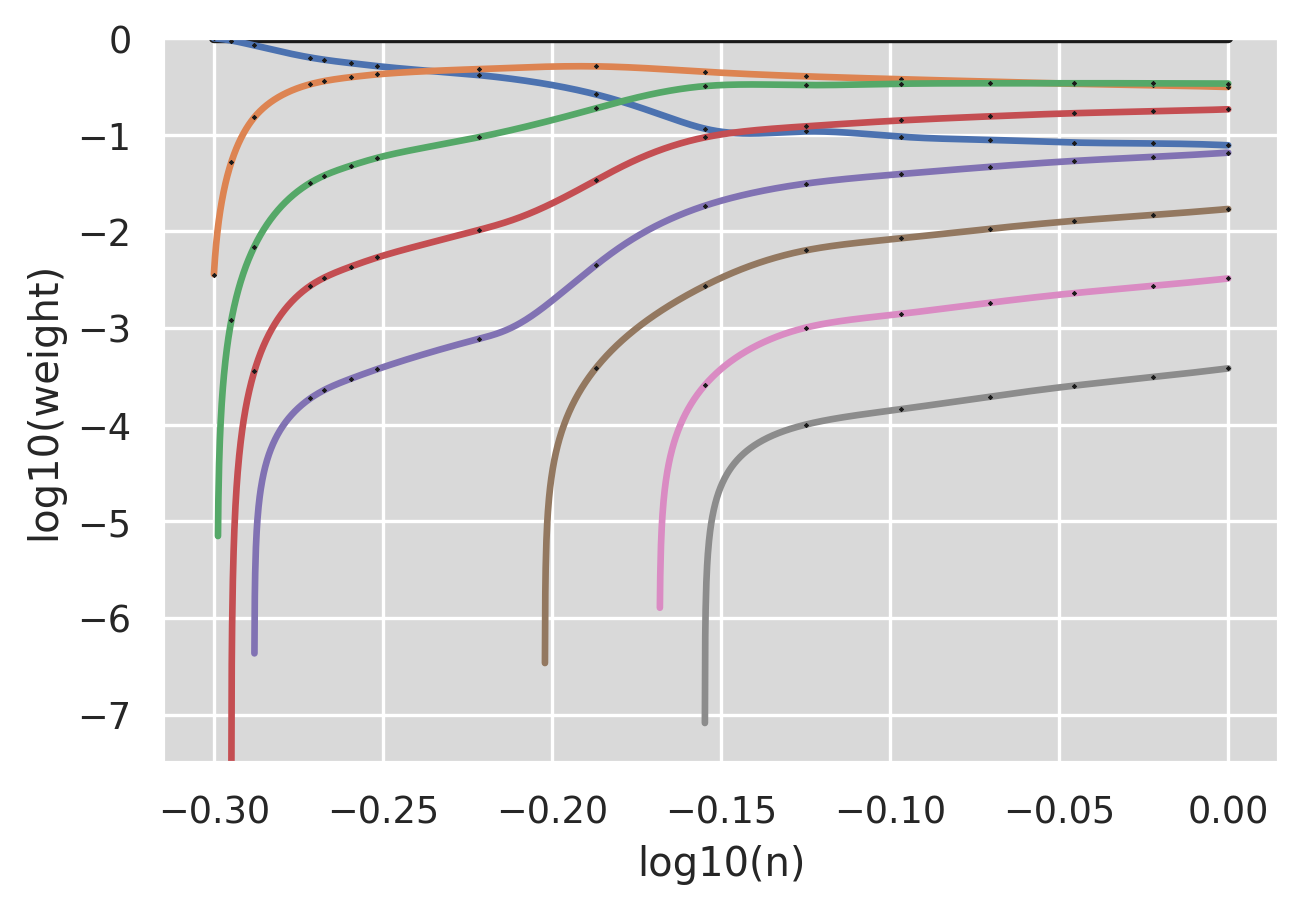

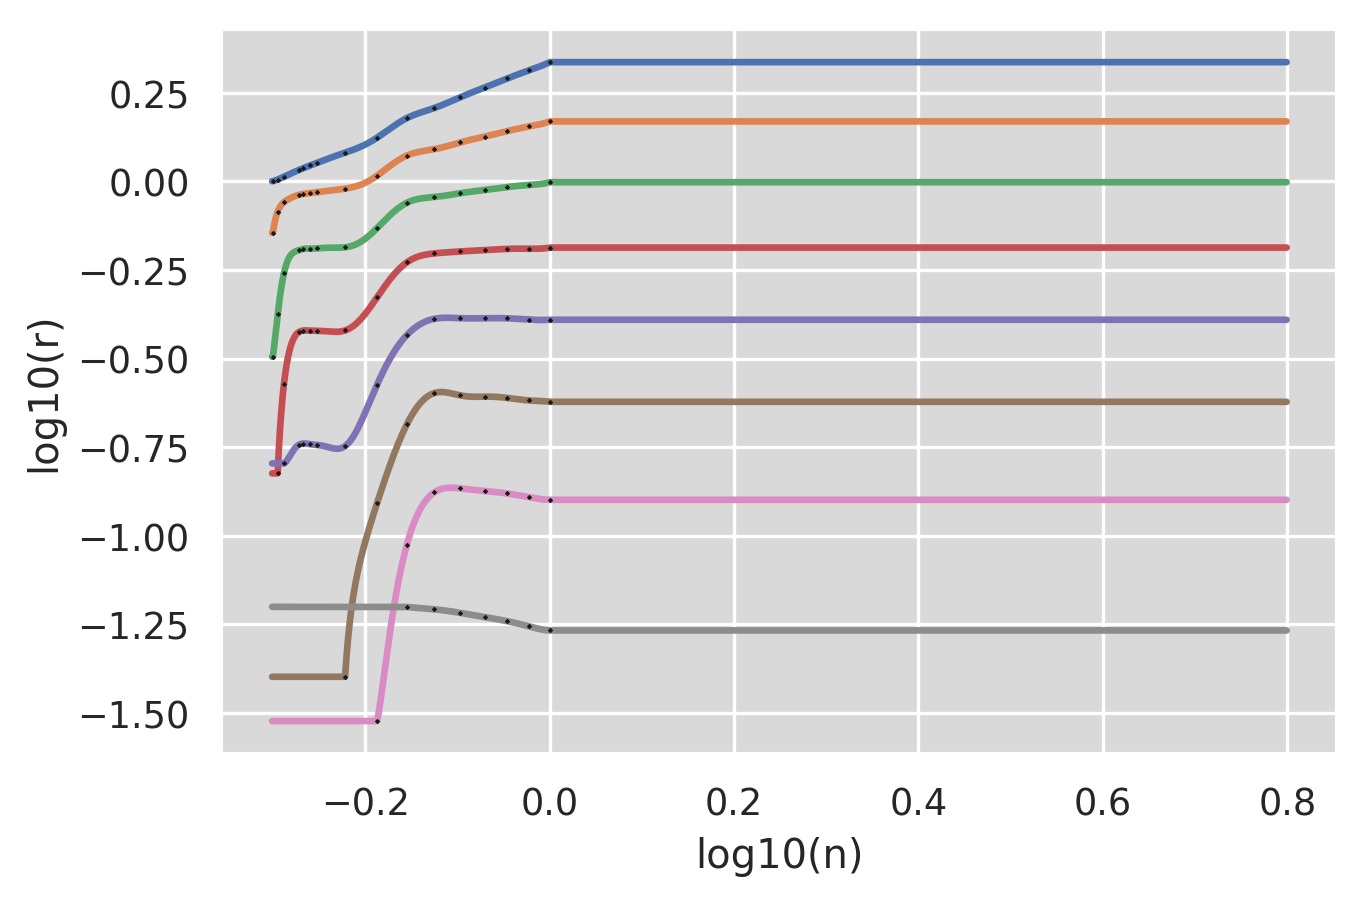

/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10
/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


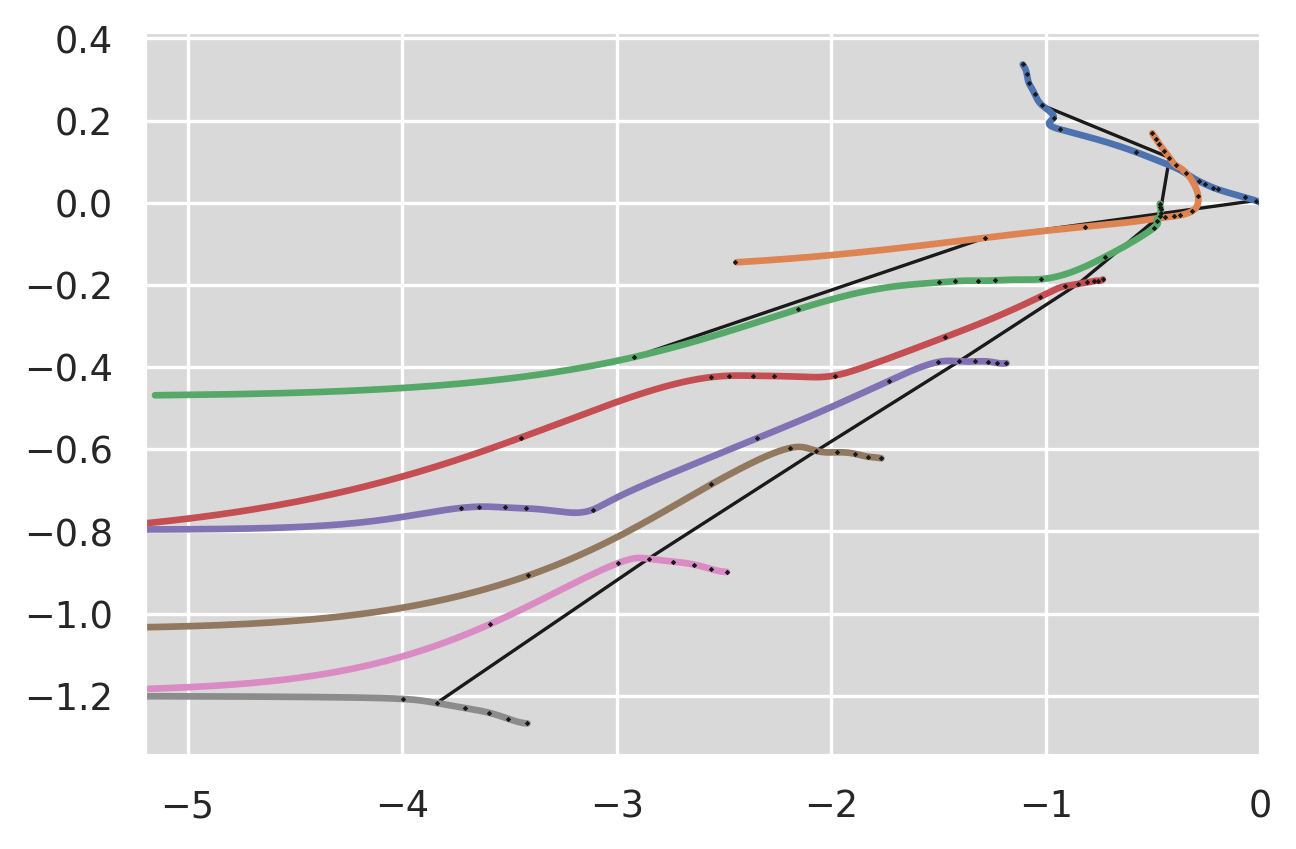

8


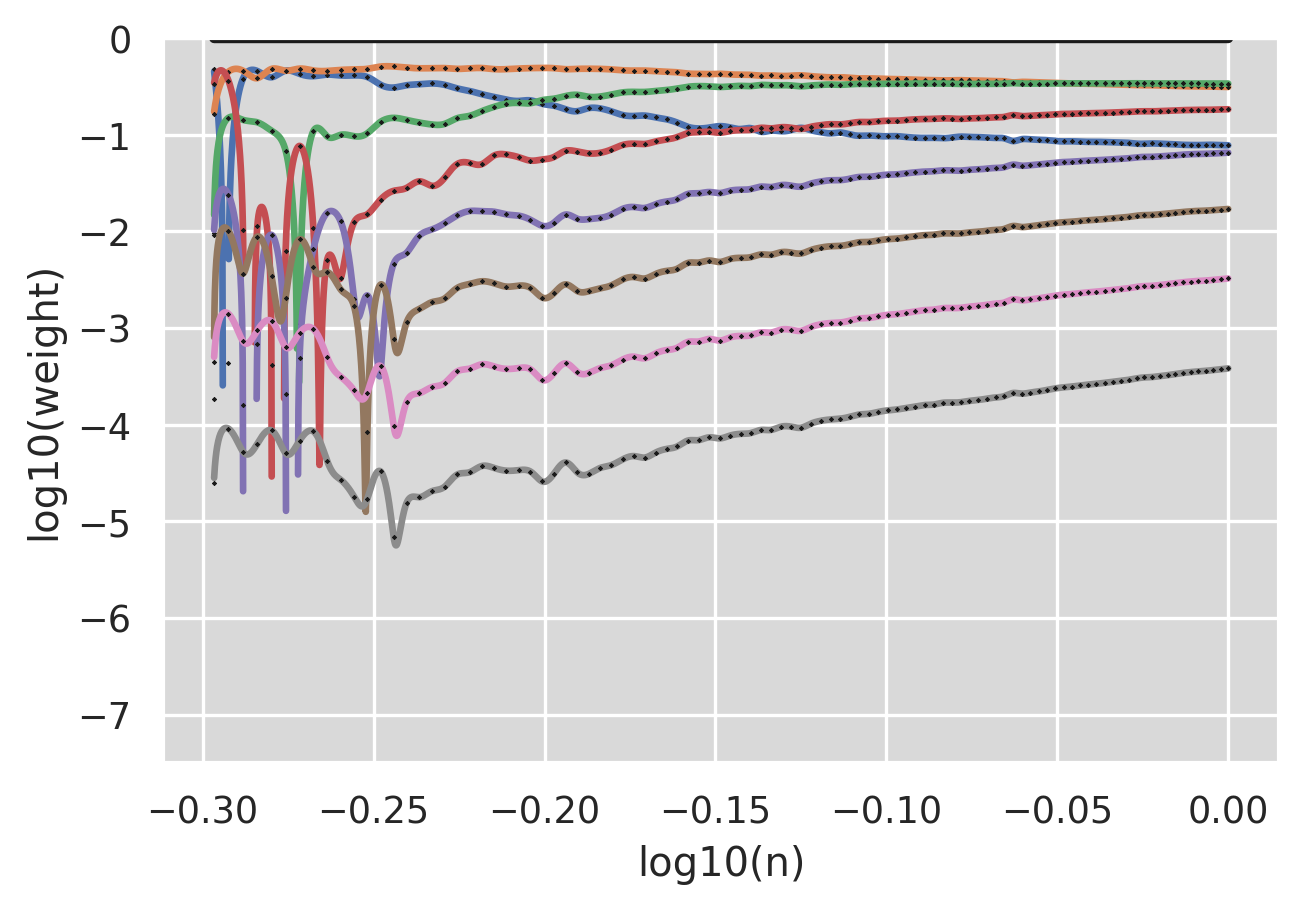

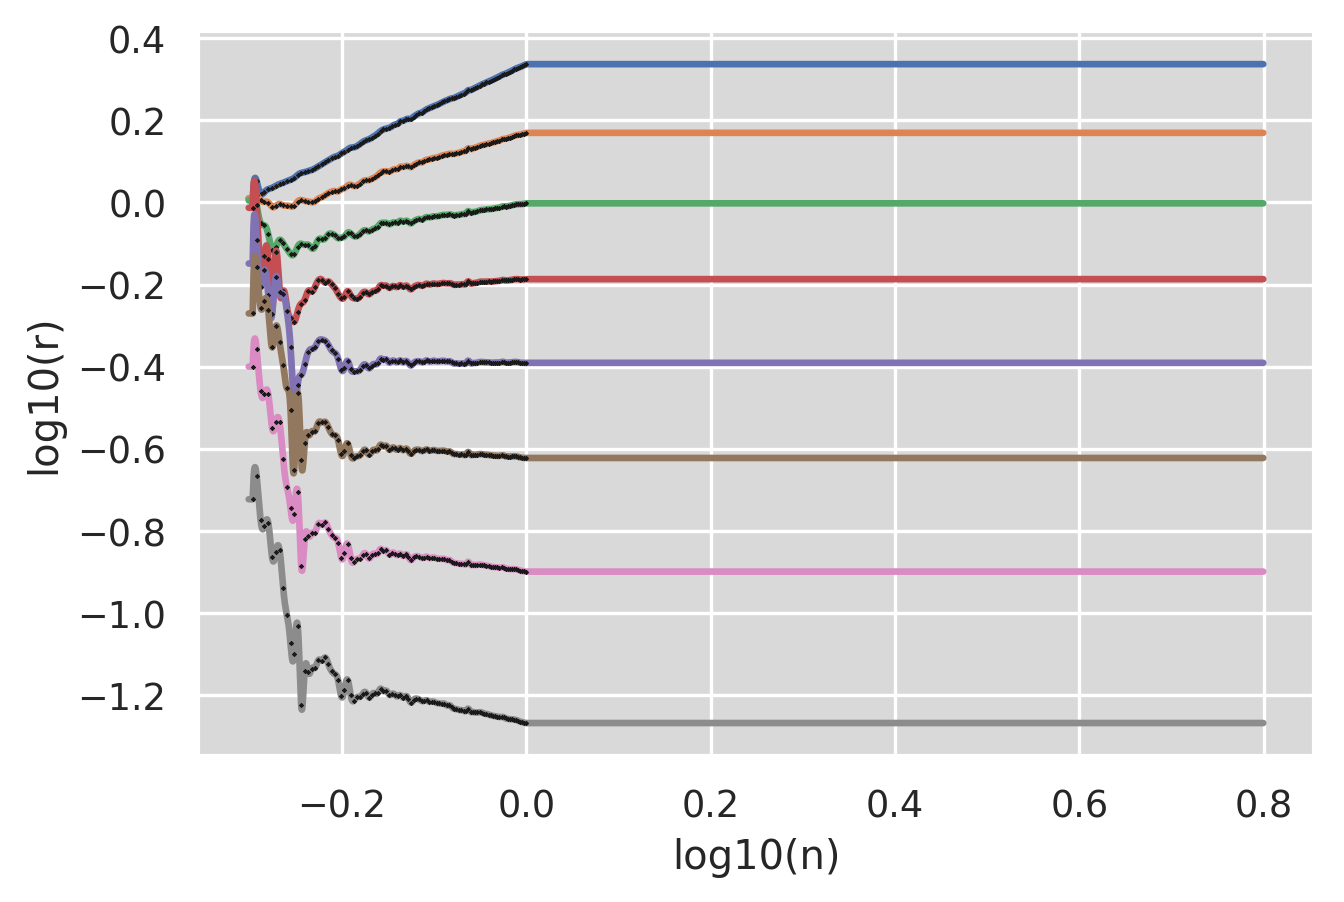

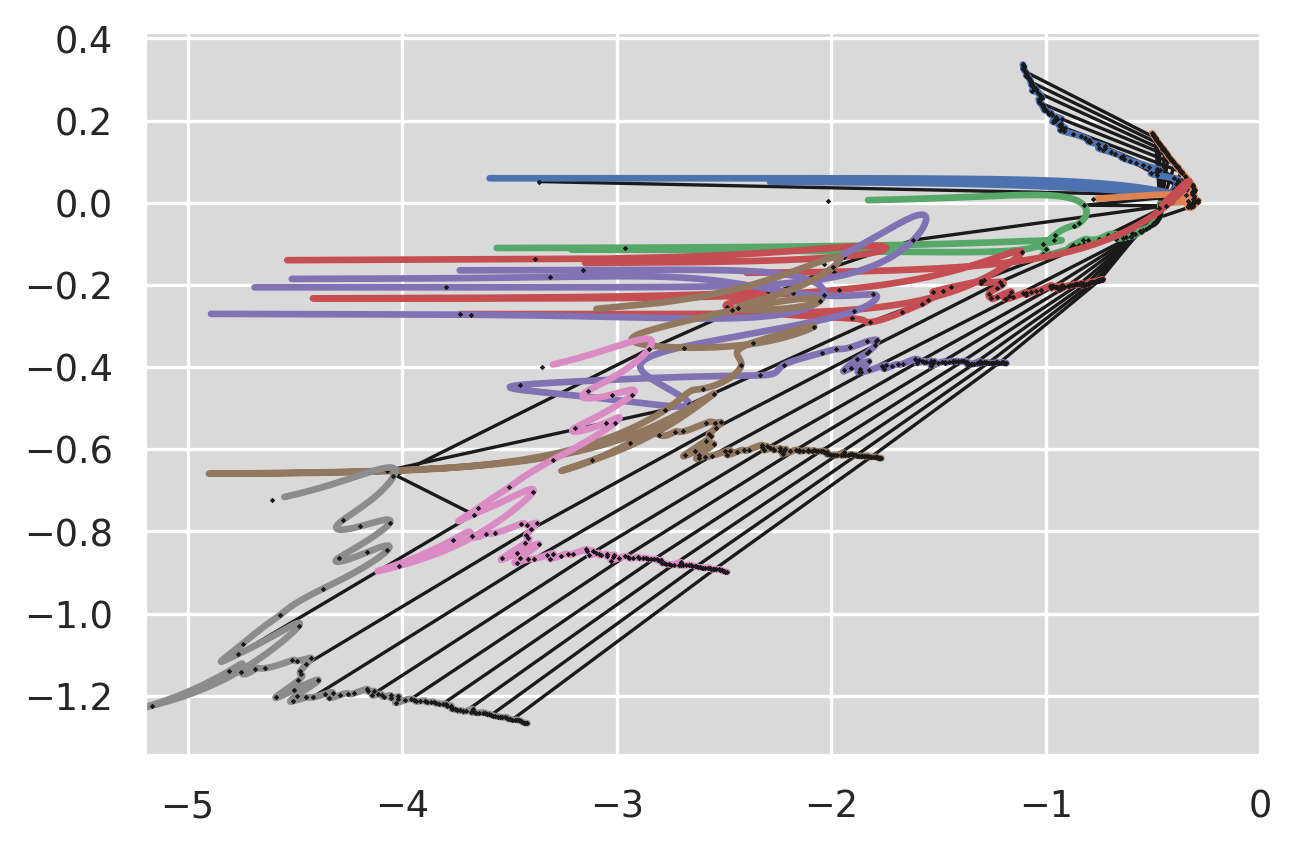

8


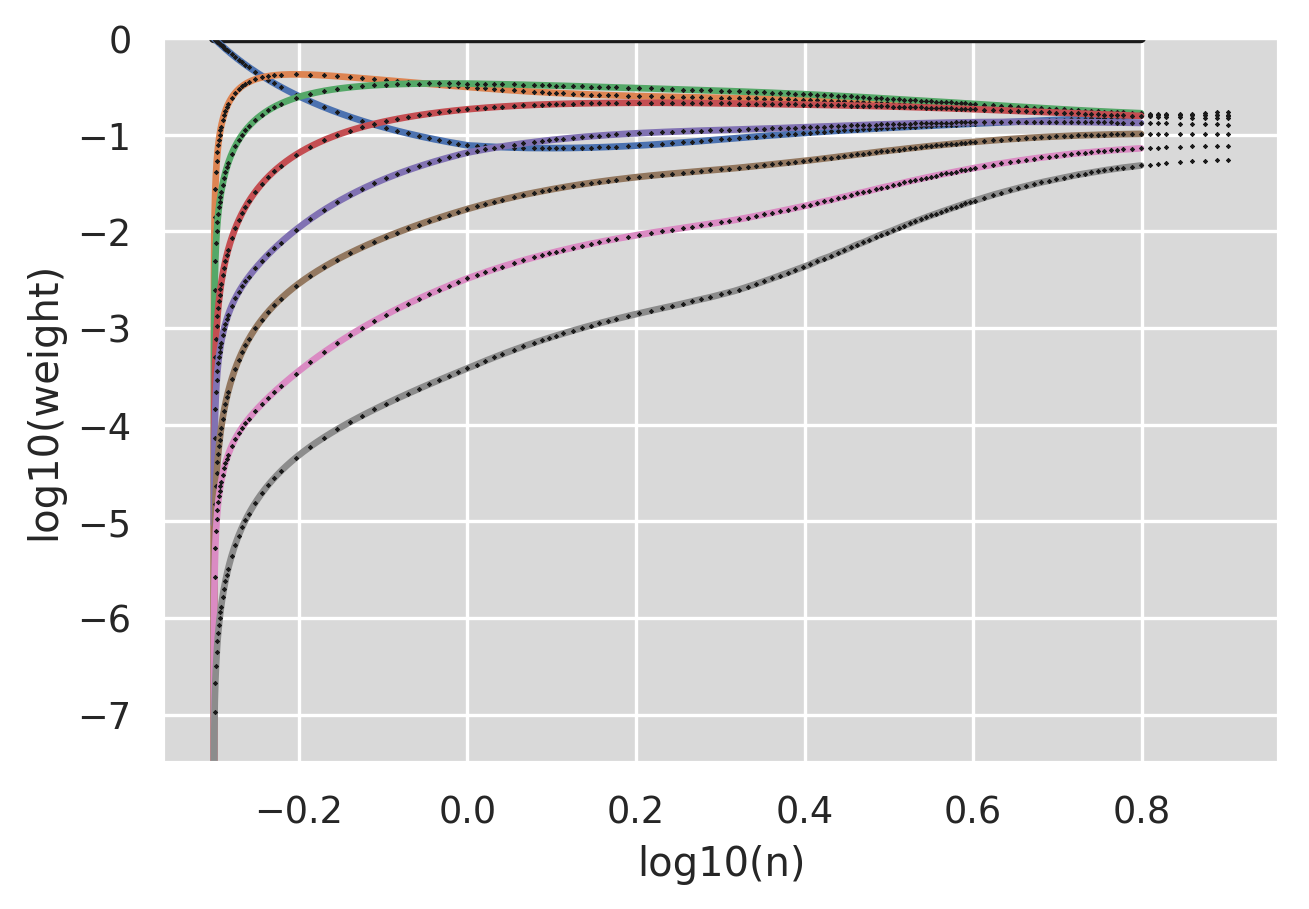

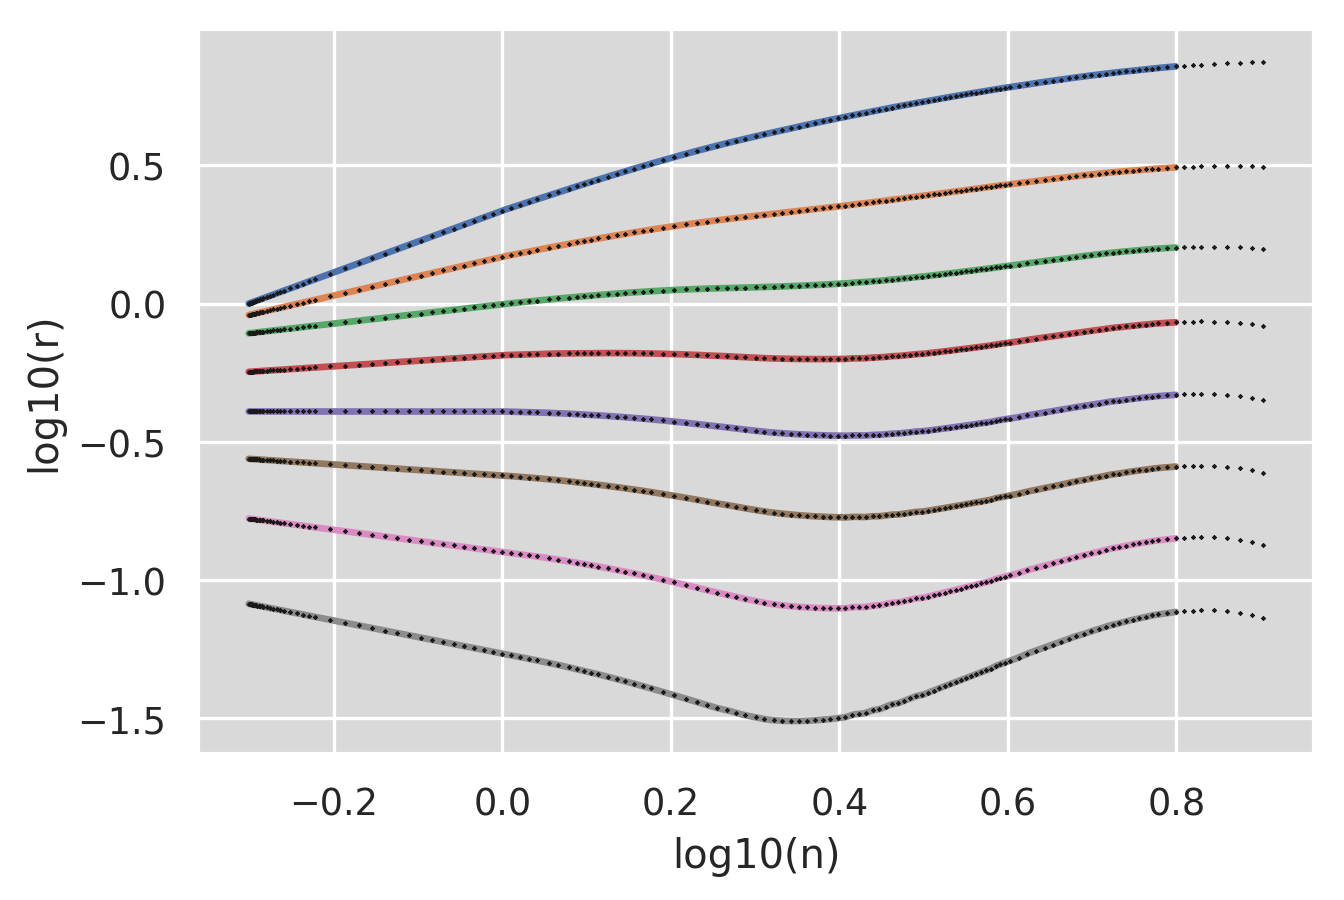

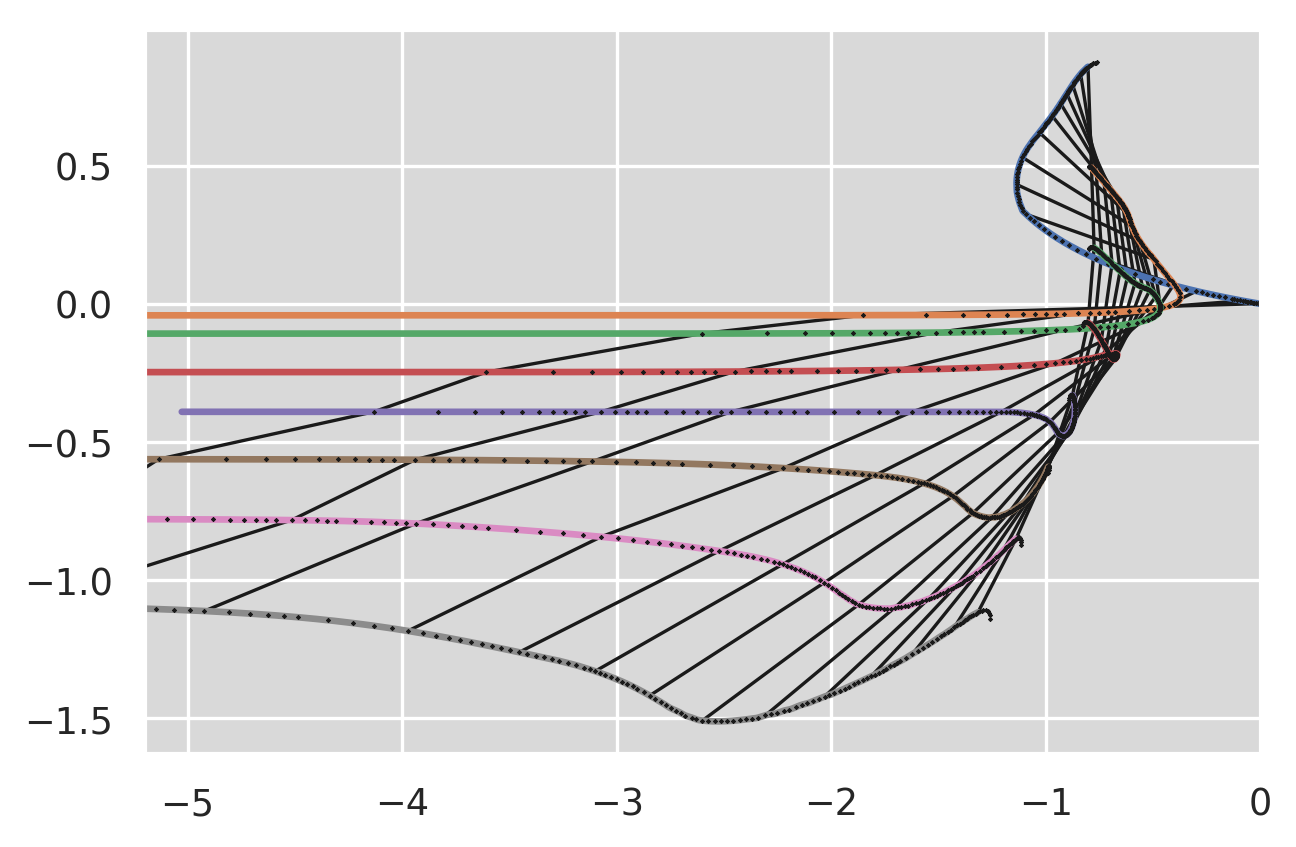

4


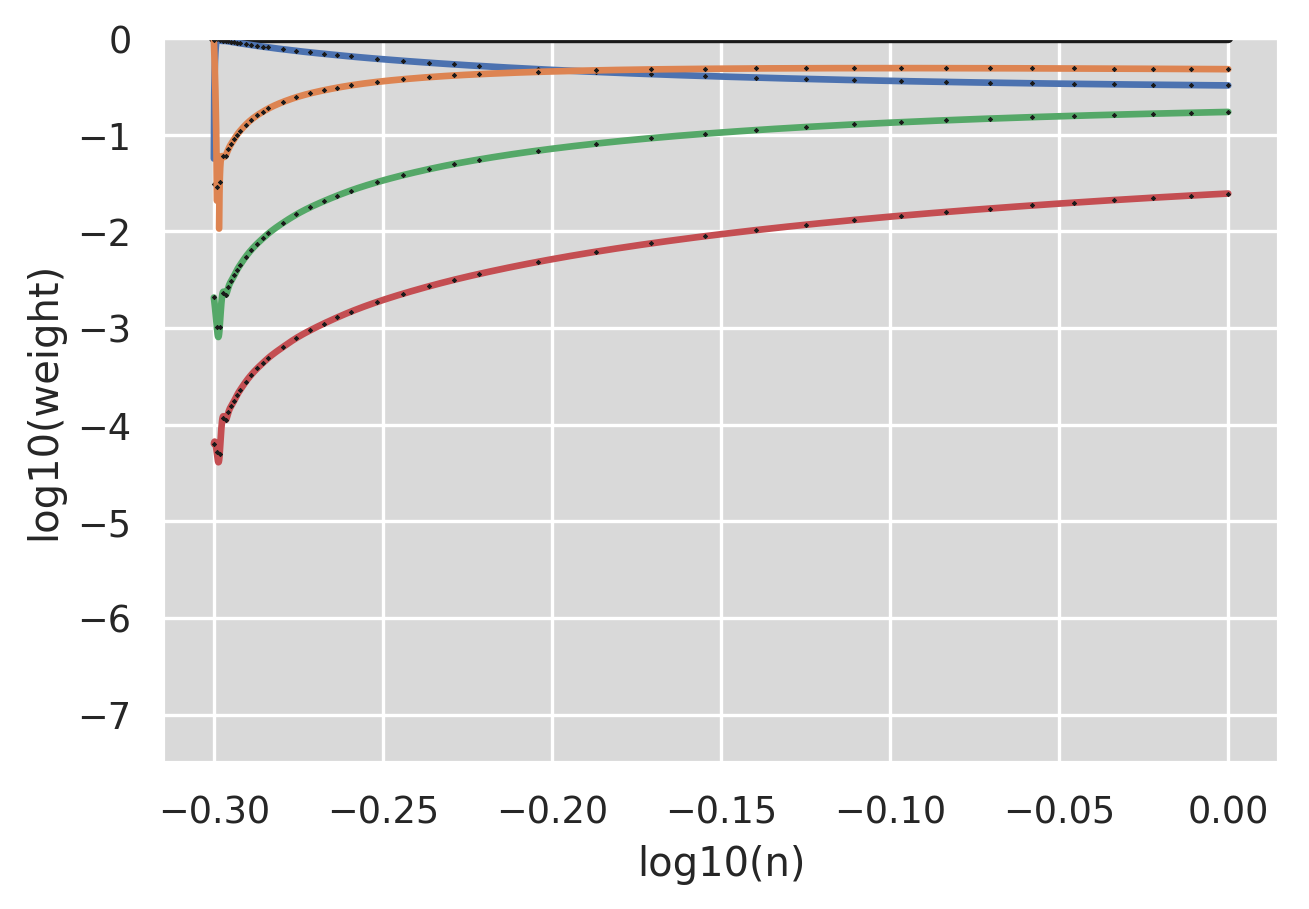

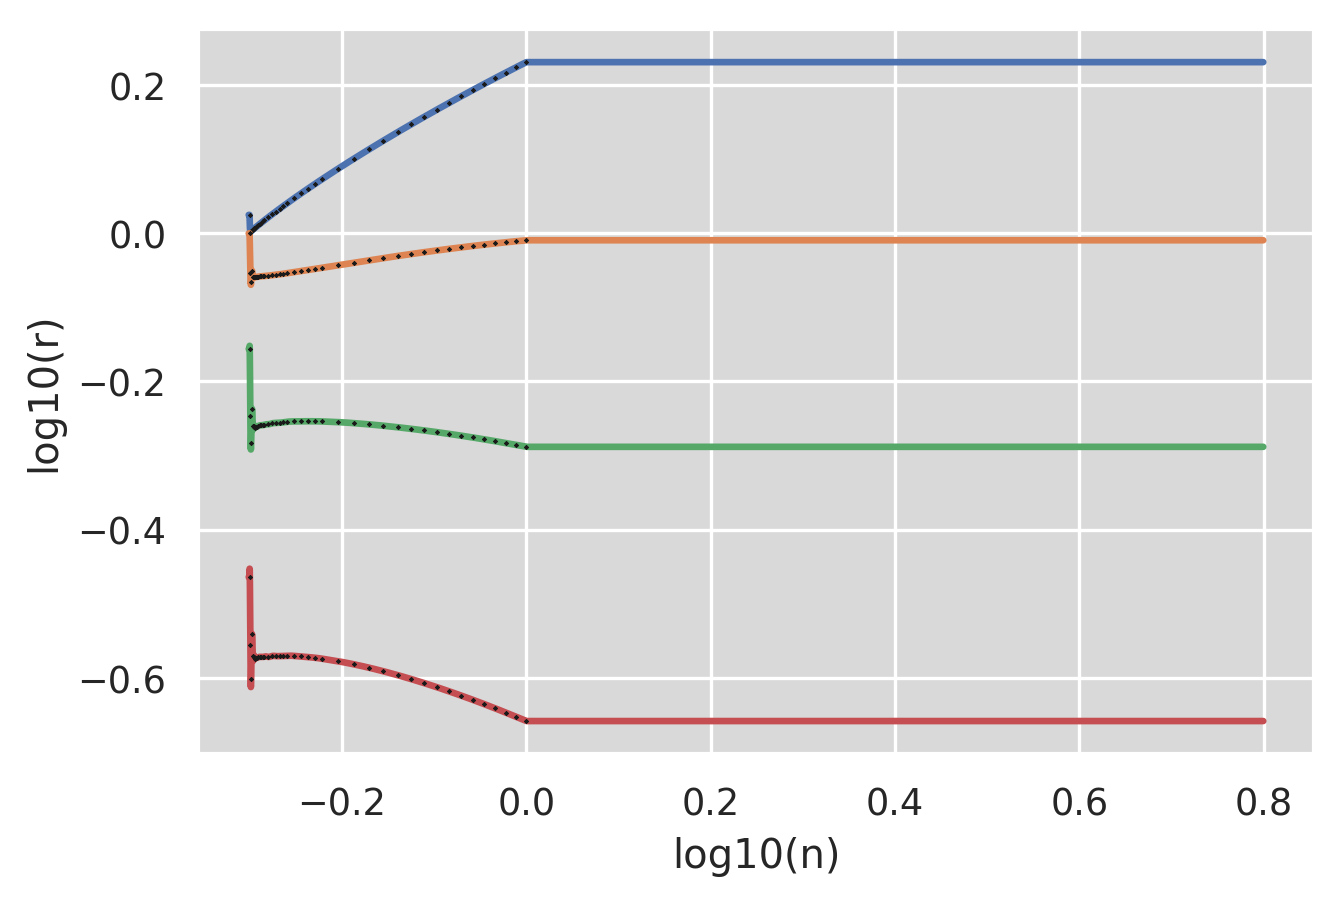

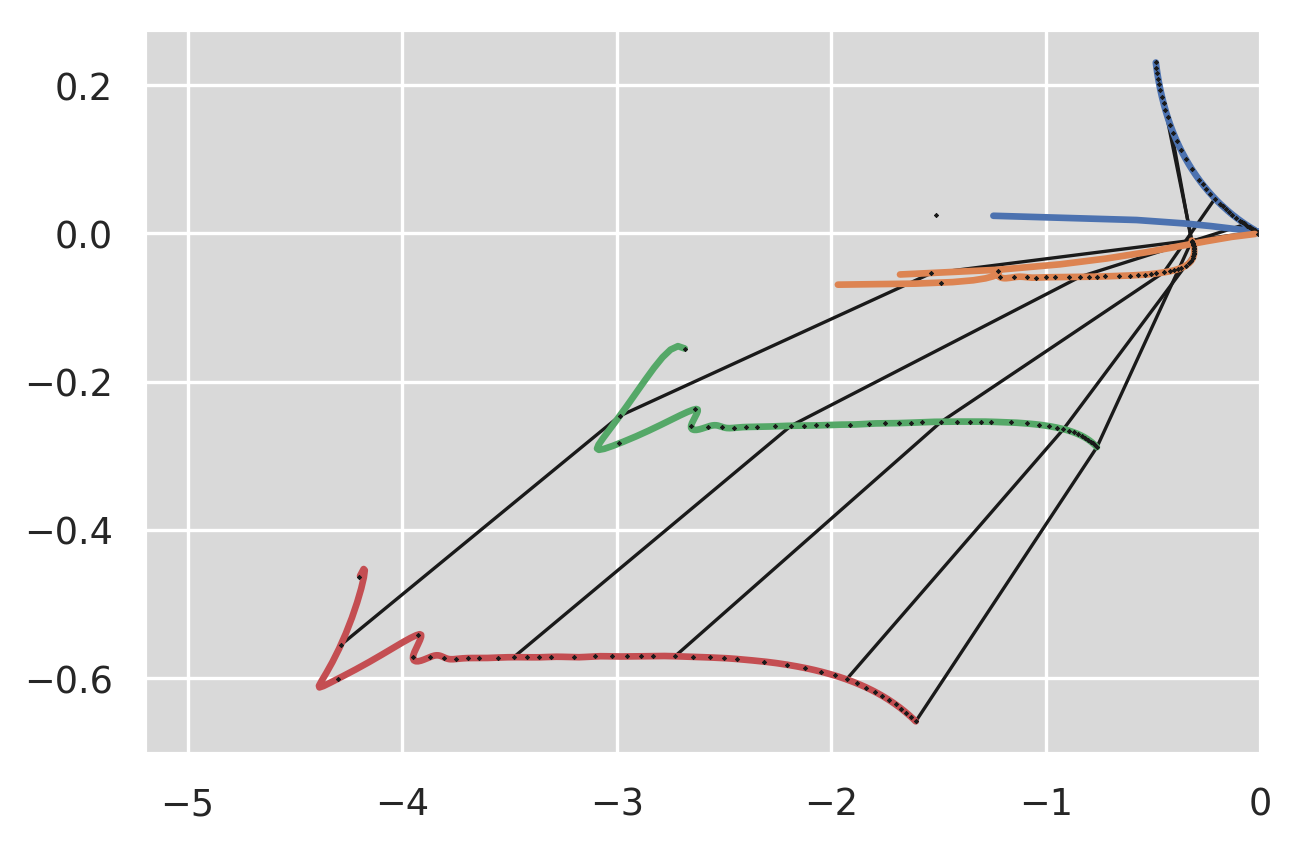

4


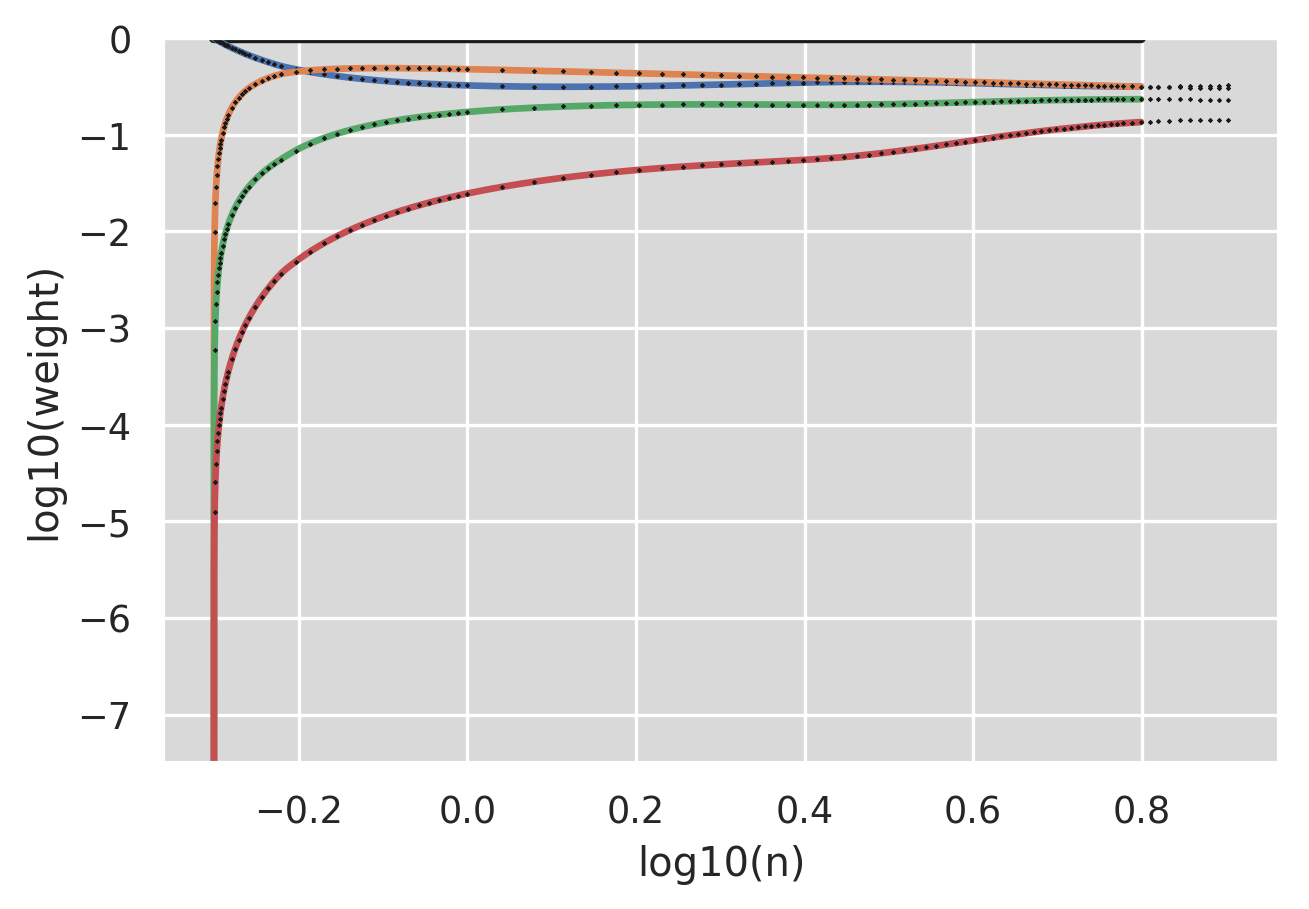

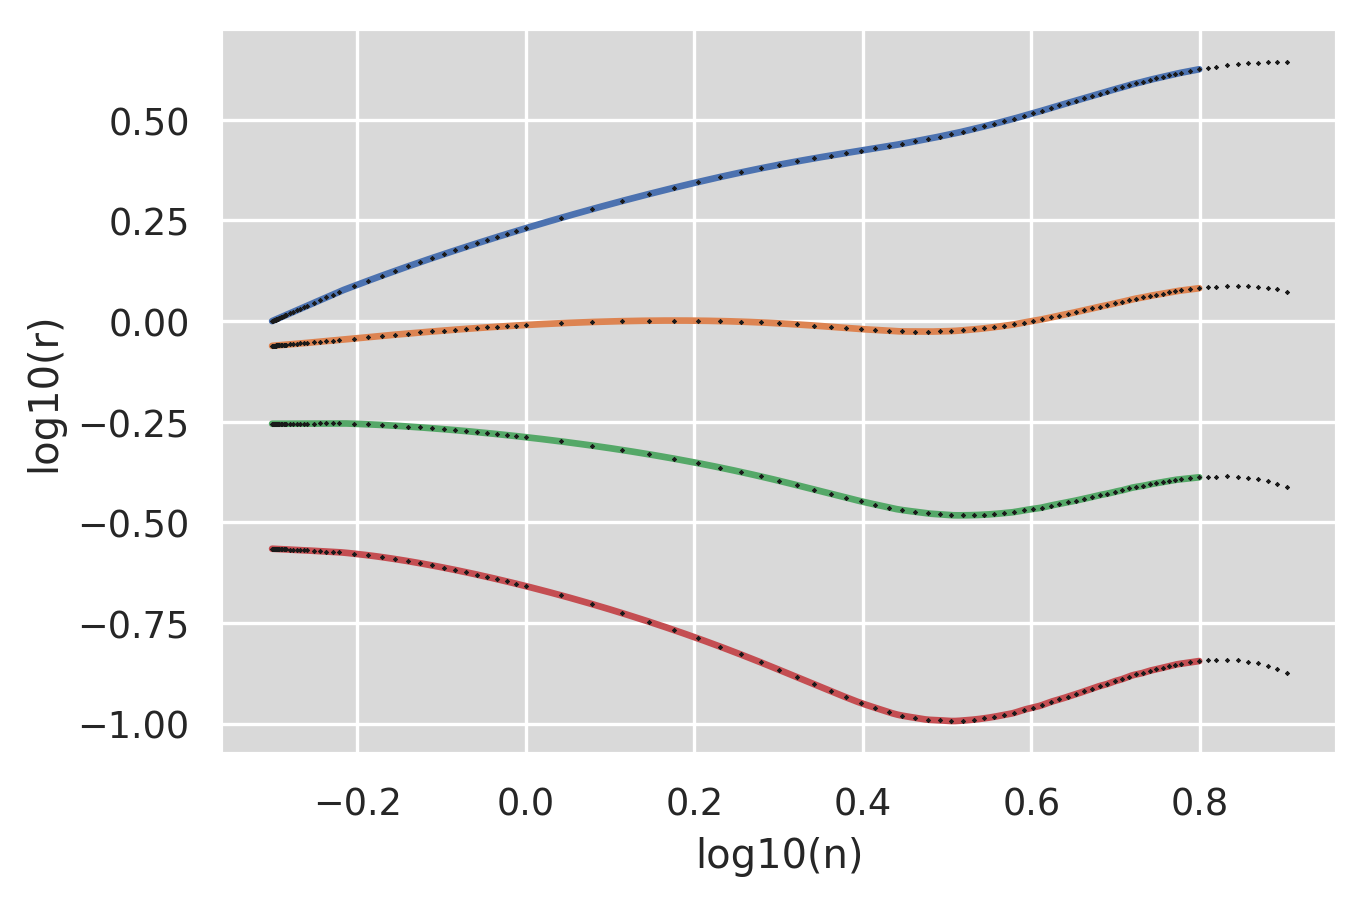

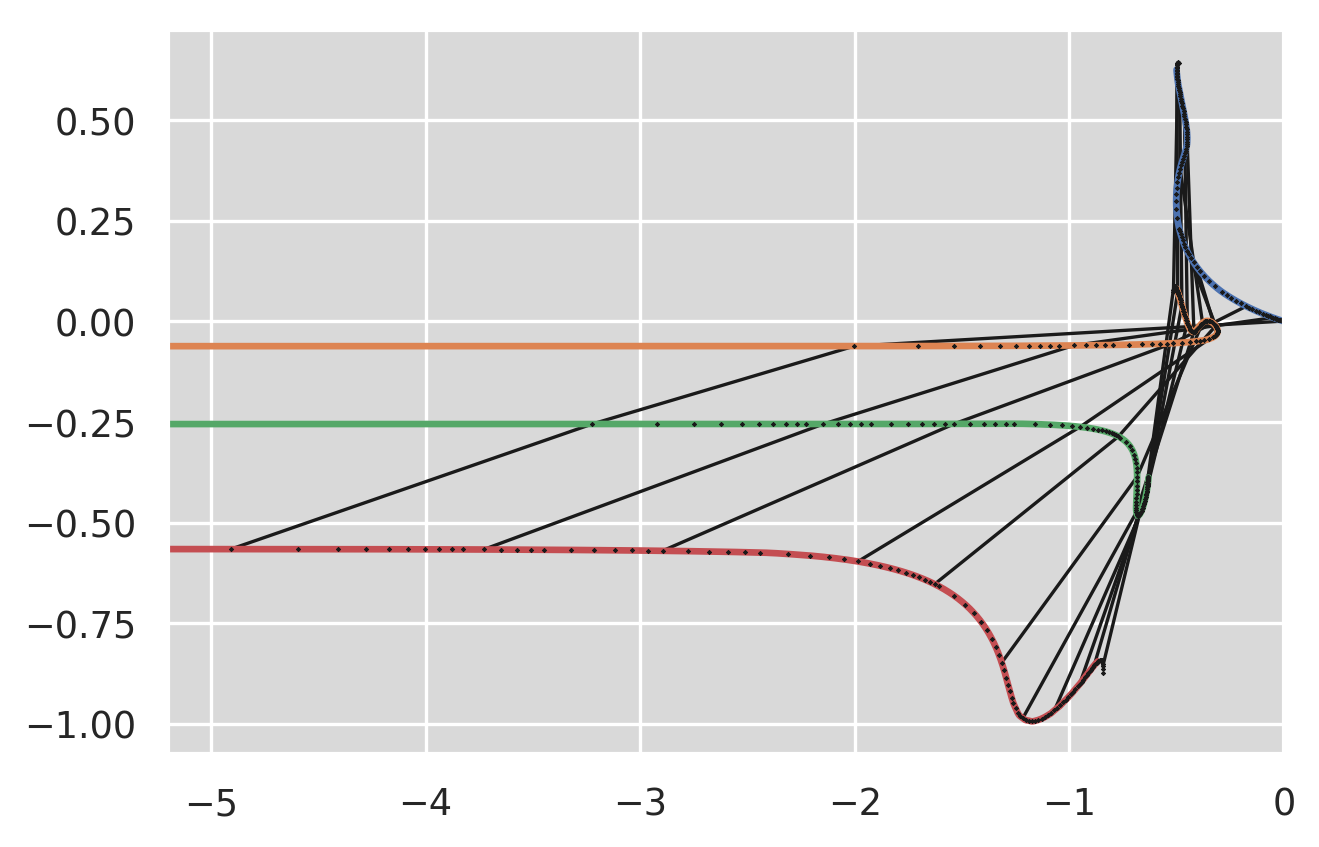

In [49]:
import multiprofit.objects as mpfobj
import multiprofit.fitutils as mpfutil
import multiprofit.multigaussianapproxprofile as mpfmga

# Plot the resulting splines, demonstrating the superiority of the final adopted approach

profilesersic = mpfutil.getcomponents('sersic', {'': np.array([1])}, {'nser': [0.5], 're': [1.0], 'ang': [0], 'axrat': [1]},
                                      isfluxesfracs=False)[0]
paramssersic = profilesersic.getparameters(fixed=False)
# Plot N=8 first
order = 8
for weightvars in weightvarssmrt, weightvarslin, None, weightvarsfour, None:
    print(order)
    mgsersic = mpfmga.MultiGaussianApproximationProfile(
        [mpfobj.FluxParameter('', '', 1.0, '', None)], parameters=paramssersic, weightvars=weightvars, order=order)
    changeorder = weightvars is None and order == 8
    if weightvars is None:
        weightvars = mpfmga.MultiGaussianApproximationProfile.weights['sersic'][order]
    nsers = np.linspace(np.log10(0.5), np.log10(6.3), 10000)
    weightsplines = mgsersic.weightsplines
    sigmasplines = mgsersic.sigmasplines
    weightsums = [np.sum(np.array([weightsplines[i](nserlog) for i in range(order)])) for nserlog in nsers]
    plt.plot(nsers, np.log10(weightsums), 'k-', linewidth=3)
    for i in range(order):
        plt.plot(nsers, np.log10(weightsplines[i](nsers)), linewidth=2)
        plt.plot(weightsplines[i]._data[0], np.log10(weightsplines[i]._data[1]), 'kx', markersize=0.8)
    plt.ylim(-7.5, 0)

    plt.xlabel('log10(n)')
    plt.ylabel('log10(weight)')
    plt.show()

    for i in range(order):
        plt.plot(nsers, np.log10(sigmasplines[i](nsers)), linewidth=2)
        plt.plot(sigmasplines[i]._data[0], np.log10(sigmasplines[i]._data[1]), 'kx', markersize=0.8)
    plt.xlabel('log10(n)')
    plt.ylabel('log10(r)')
    plt.show()

    weightvalues = np.array(list(weightvars.values()))
    for idxn, nser in enumerate(list(weightvars.keys())):
        if idxn % 10 == 1:
            nser = np.log10(nser)
            x = np.array([weightsplines[i](nser) for i in range(order) if weightvalues[idxn][0][i] > 0])
            y = np.array([sigmasplines[i](nser) for i in range(order) if weightvalues[idxn][0][i] > 0])
            plt.plot(np.log10(x), np.log10(y), 'k-', linewidth=1)
    
    for i in range(order):
        plt.plot(np.log10(weightsplines[i](nsers)), np.log10(sigmasplines[i](nsers)), linewidth=2)
        plt.plot(np.log10(weightsplines[i]._data[1]), np.log10(sigmasplines[i]._data[1]), 'kx', markersize=0.8)

    plt.xlim([-5.2, 0])
    plt.show()
    if changeorder:
        order = 4

0.9999999914677243 1.0000000278012995
Init  chisq = -6.260780302914447
ws, re: (array([4.88322199e-01, 1.91082600e-01, 2.86623900e-01, 1.80466900e-02,
       1.06157000e-02, 5.30784999e-03, 1.06157000e-06, 1.06170628e-12]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -7.466856
         Iterations: 24
         Function evaluations: 270
         Gradient evaluations: 30
-7.466856361006104 [-0.14721301 -0.70241584  1.0910987  -1.46816521  2.62828623  8.51733991
 13.8154538 ]
0.9999999914677243 1.000000019382195
n=1.0: (
    normalize(np.array([4.6326306880e-01, 1.7780850485e-01, 2.6868971315e-01, 1.6894641090e-02, 6.8405081968e-02, 4.9380026986e-03, 9.8745465974e-07, 9.8743235810e-13])),
    np.array([1.0000000000e+00, 5.0000000000e-01, 1.5000000000e+00, 2.5000000000e-01, 2.5000000000e+00, 1.2500000000e-01, 6.2500000000e-02, 5.0000000000e+00]),
),


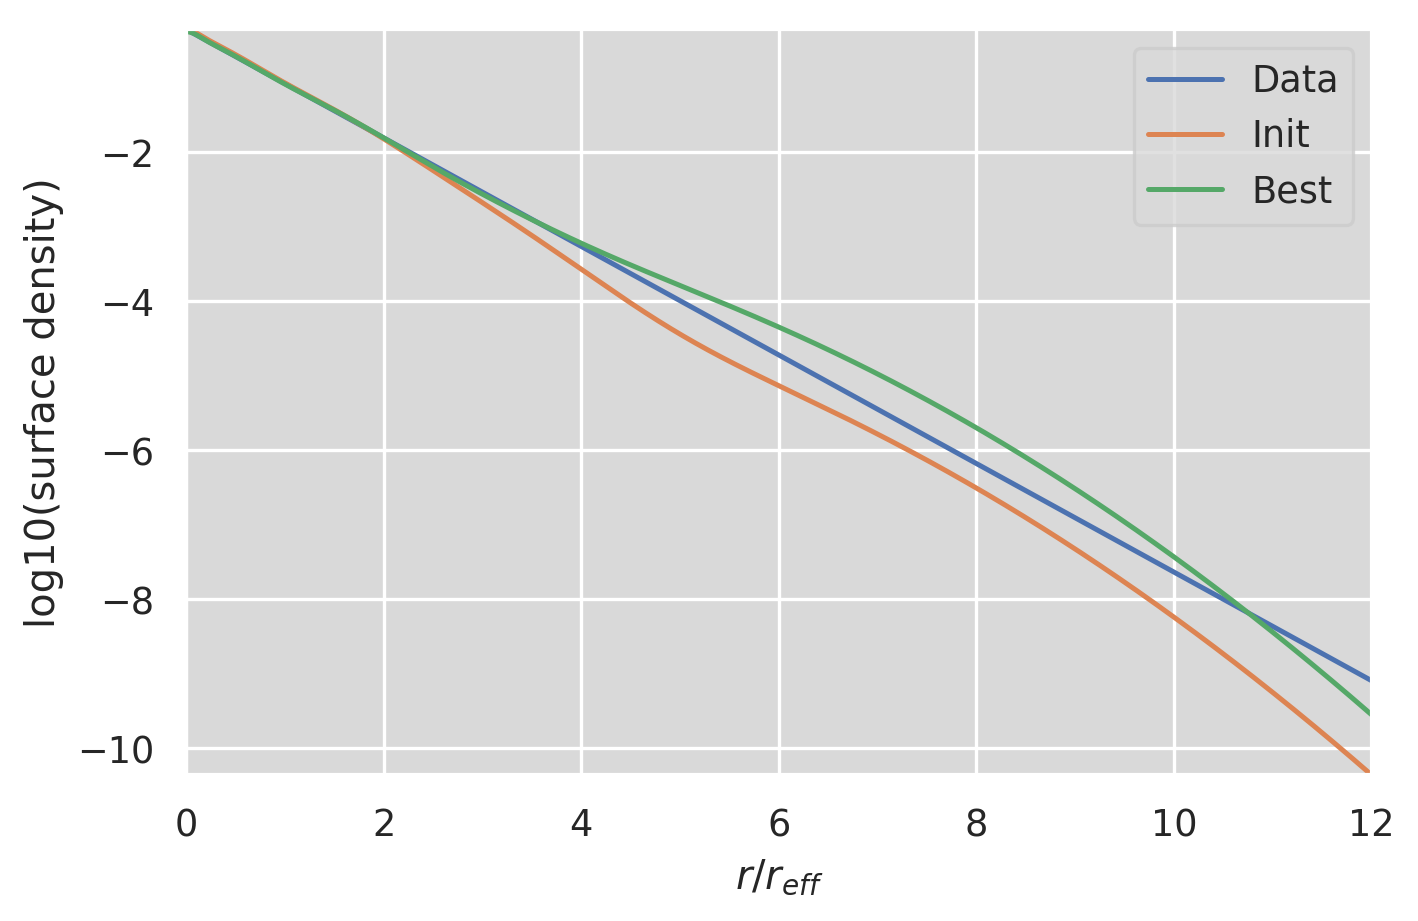

Init  chisq = -7.2805532120223875
ws, re: (array([4.63263069e-01, 1.77808505e-01, 2.68689713e-01, 1.68946411e-02,
       6.84050820e-02, 4.93800270e-03, 9.87454660e-07, 9.87210313e-13]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -7.470686
         Iterations: 9
         Function evaluations: 126
         Gradient evaluations: 14
-7.470686183127671 [-0.10162297 -0.69837099  1.19789546 -1.47372501  2.59819143  8.51735633
 13.81570492]
n=0.975: (
    normalize(np.array([9.1626706222e-13, 6.1602889643e-02, 2.6951724018e-01, 4.7461609794e-01, 1.7451860921e-01, 1.5161413435e-02, 4.5828331709e-03, 9.1641620302e-07])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -7.277147470964736
ws, re: (array([4.74616098e-01, 1.74518609e-01, 2.69517240e-01, 1.51614134e-02,
   

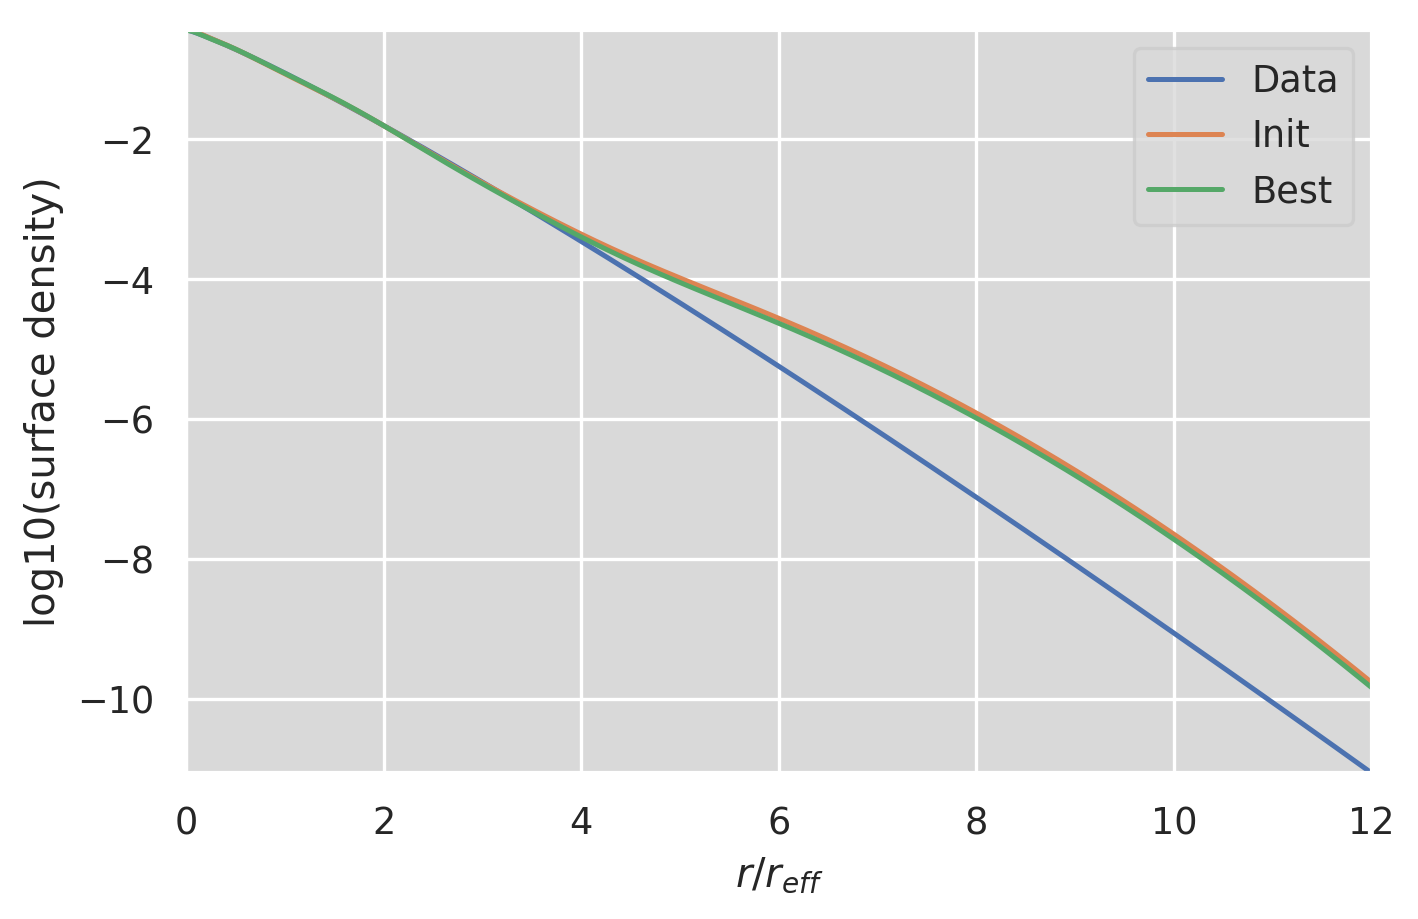

Init  chisq = -7.275630021451911
ws, re: (array([5.29780690e-01, 1.57805637e-01, 2.65306251e-01, 8.45676955e-03,
       3.52779295e-02, 3.37272081e-03, 2.43771538e-09, 2.44249065e-15]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -7.540054
         Iterations: 14
         Function evaluations: 171
         Gradient evaluations: 19
-7.540054049309582 [ 0.186424   -0.67933636  1.9021377  -1.5428405   2.23282772 14.14016877
 13.81570492]
n=0.85: (
    normalize(np.array([2.2204460493e-15, 2.9082342551e-02, 2.6187291002e-01, 5.4647148972e-01, 1.5257127060e-01, 6.8836387727e-03, 3.1183460807e-03, 2.2538582928e-09])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -7.277311945003915
ws, re: (array([5.46471490e-01, 1.52571271e-01, 2.61872910e-01, 6.88363877e-03,
    

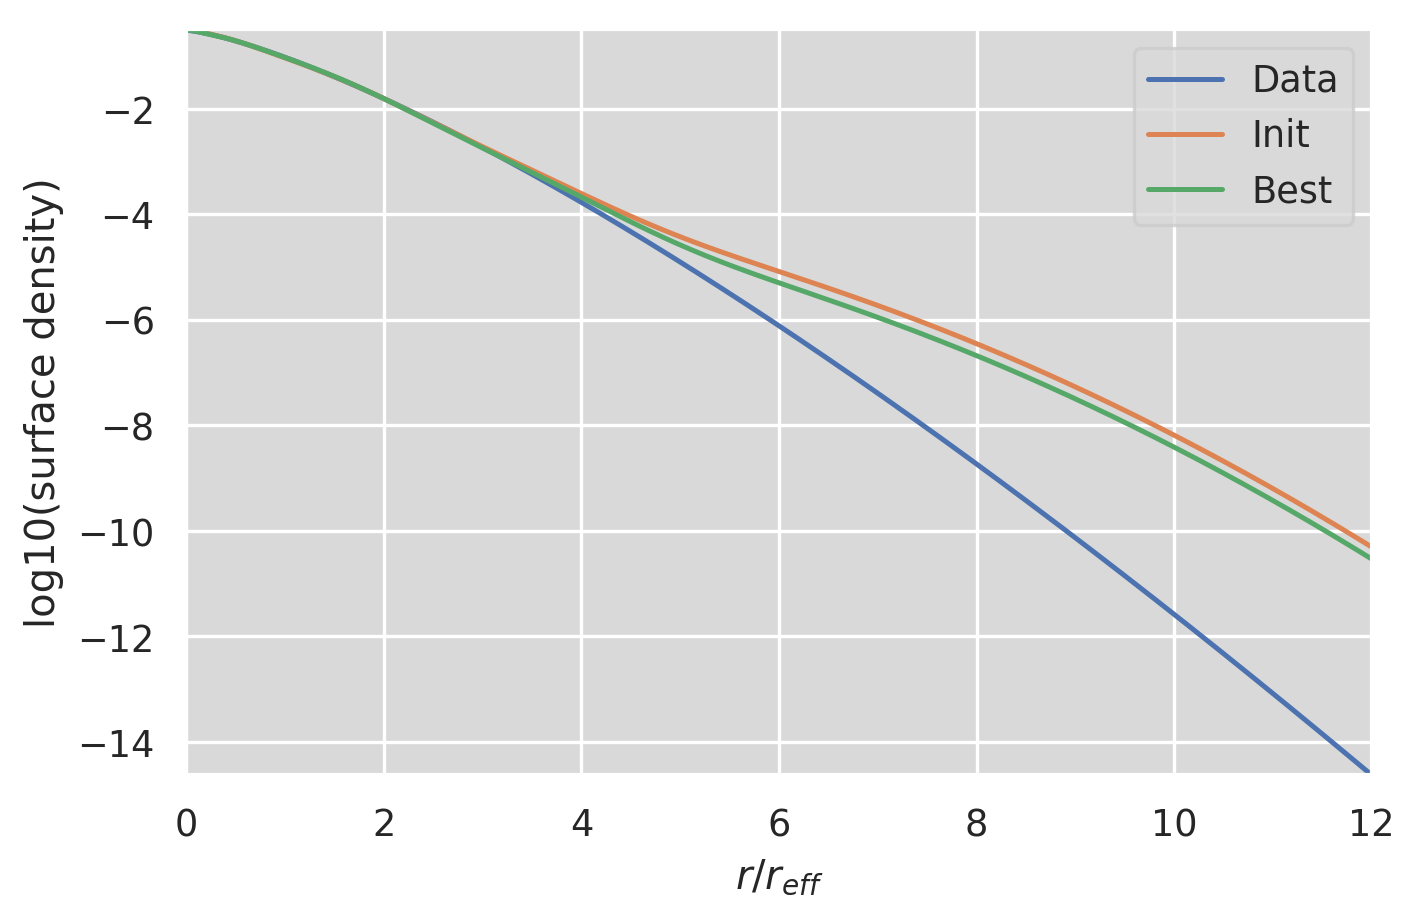

Init  chisq = -7.282741891256691
ws, re: (array([6.28309435e-01, 1.26157988e-01, 2.34724611e-01, 1.36407559e-03,
       7.19111726e-03, 2.25277067e-03, 1.62823026e-09, 1.66533454e-15]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -7.715233
         Iterations: 32
         Function evaluations: 333
         Gradient evaluations: 37
-7.715232748955819 [ 0.63339032 -0.66282745  3.78931249 -2.93366107  0.28374475 14.14020827
 13.81570492]
n=0.725: (
    normalize(np.array([1.5543122345e-15, 2.7403770291e-03, 2.2375418721e-01, 6.5325780924e-01, 1.1792866586e-01, 2.5556961333e-04, 2.0633895521e-03, 1.4913046385e-09])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -7.281820428704315
ws, re: (array([6.53257809e-01, 1.17928666e-01, 2.23754187e-01, 2.55569613e-04,
   

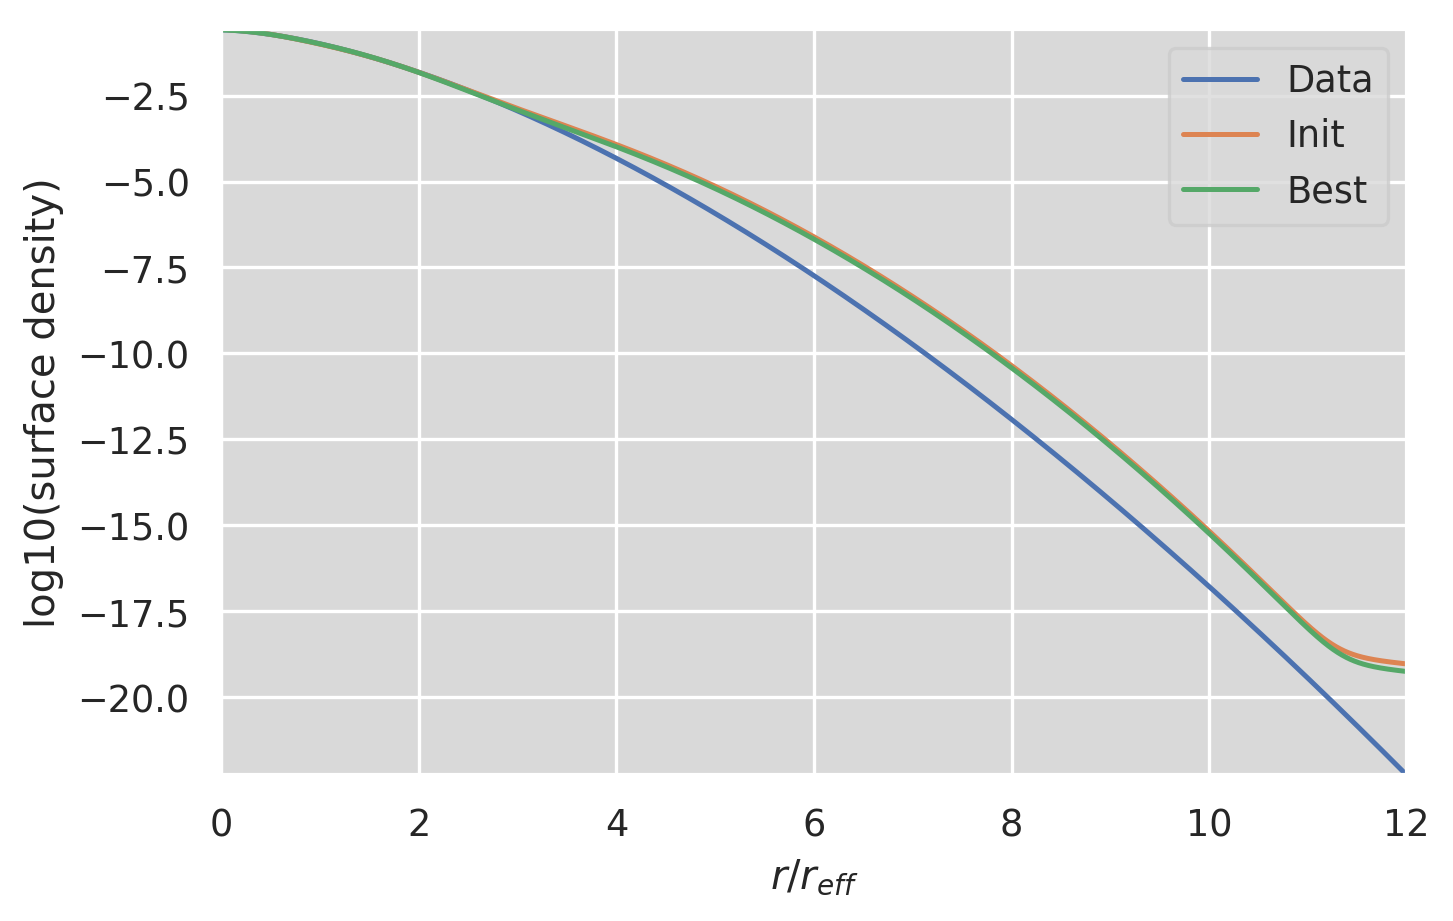

Init  chisq = -7.233974376247706
ws, re: (array([7.87262904e-01, 7.20266206e-02, 1.40283913e-01, 1.01401759e-09,
       4.38359325e-40, 4.26560102e-04, 3.08168865e-10, 3.33066907e-16]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -7.966277
         Iterations: 14
         Function evaluations: 171
         Gradient evaluations: 19
-7.966276751592336 [  1.5559171   -0.67137354   6.52006805 -12.94958927 -82.86577839
  14.14061494  13.81570492]
n=0.6: (
    normalize(np.array([1.1102230246e-16, 1.7435905760e-40, 1.1513978568e-01, 8.2576670228e-01, 5.8923845638e-02, 4.0332918347e-10, 1.6966587237e-04, 1.2257531622e-10])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -7.748263120045122
ws, re: (array([8.25766702e-01, 5.89238456e-02, 1.15139786e-01, 4.03329183e-10

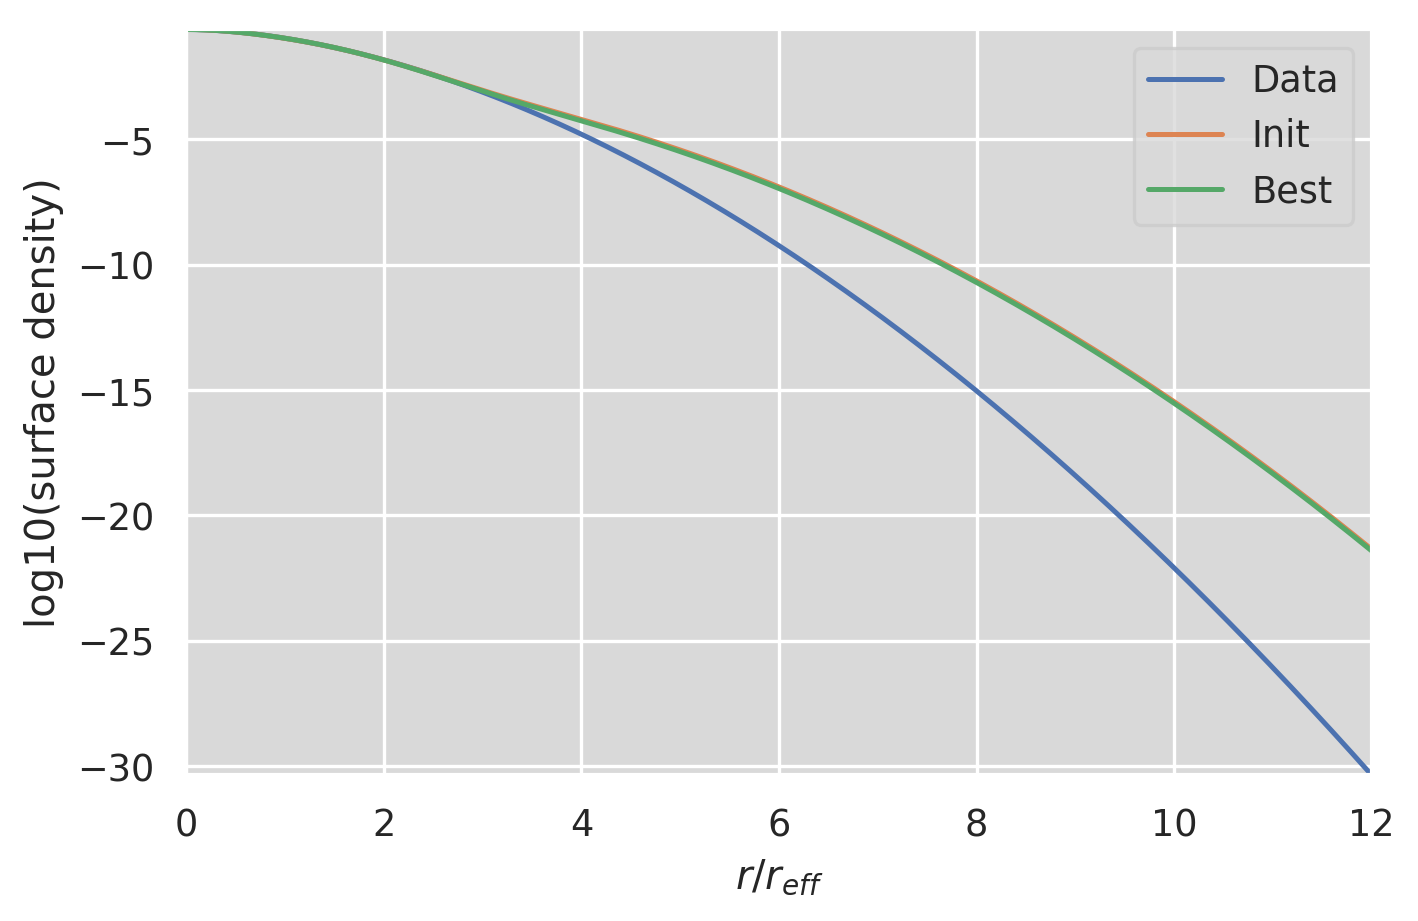

Init  chisq = -7.854199870120401
ws, re: (array([8.91534339e-01, 3.65583155e-02, 7.19073433e-02, 6.30705019e-15,
       2.72653623e-45, 2.65314664e-09, 1.91676902e-15, 0.00000000e+00]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -8.320908
         Iterations: 9
         Function evaluations: 108
         Gradient evaluations: 12
-8.320907540000173 [  2.29915888  -0.67854096  17.11513963 -12.94958954 -82.86577839
  14.14061494  13.81570492]
n=0.55: (
    normalize(np.array([0.0000000000e+00, 2.2939383392e-45, 6.0498382476e-02, 9.0880735395e-01, 3.0694261341e-02, 5.3063605381e-15, 2.2321928946e-09, 1.6126504764e-15])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -8.189671643934613
ws, re: (array([9.08807354e-01, 3.06942613e-02, 6.04983825e-02, 5.30636054e-15

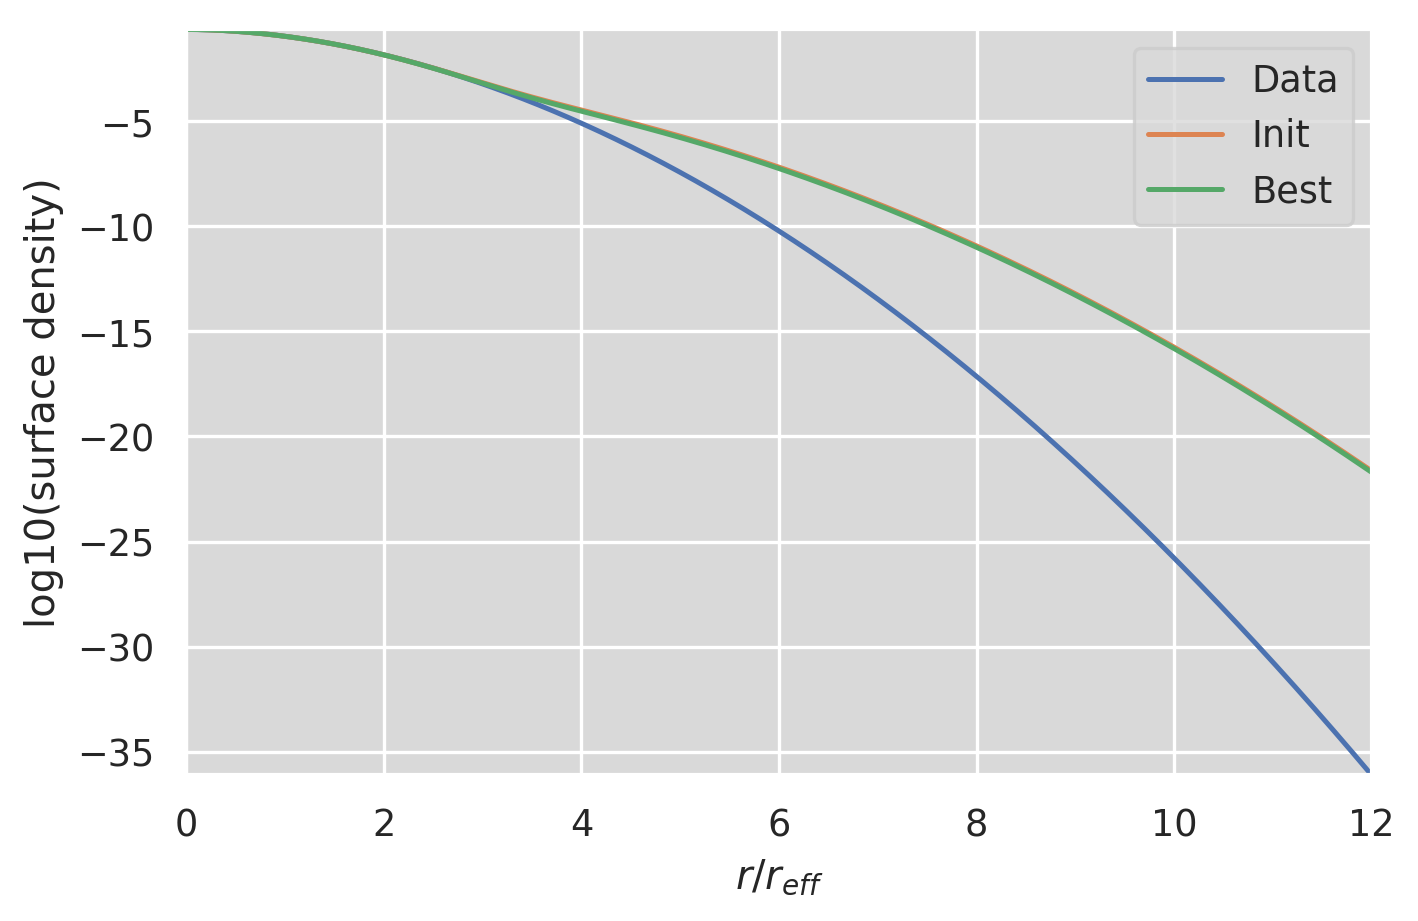

Init  chisq = -8.384918027887945
ws, re: (array([9.44300540e-01, 1.86948957e-02, 3.70045626e-02, 3.24569320e-15,
       1.40311236e-45, 1.36534509e-09, 9.86395224e-16, 0.00000000e+00]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -8.798012
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 11
-8.798012196478561 [  3.01788603  -0.68387596  17.11514218 -12.94958954 -82.86577839
  14.14061494  13.81570492]
n=0.525: (
    normalize(np.array([0.0000000000e+00, 1.1749302801e-45, 3.0986693083e-02, 9.5337564851e-01, 1.5637657266e-02, 2.7178601826e-15, 1.1433049346e-09, 8.2598204302e-16])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -8.437466892234305
ws, re: (array([9.53375649e-01, 1.56376573e-02, 3.09866931e-02, 2.71786018e-15

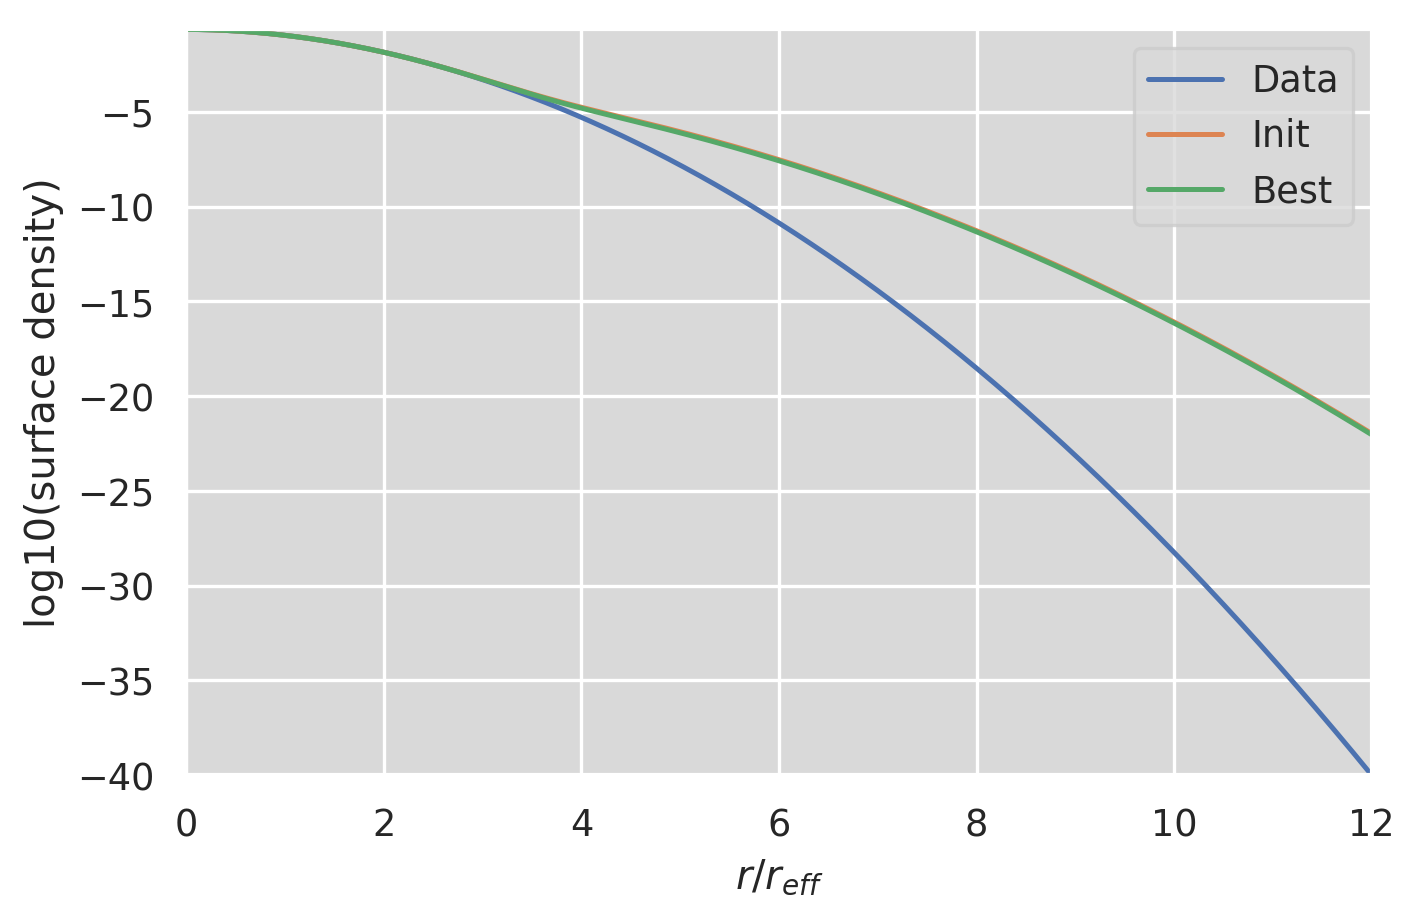

Init  chisq = -9.070243382021799
ws, re: (array([9.73631471e-01, 8.82969920e-03, 1.75388295e-02, 1.53833697e-15,
       6.65022691e-46, 6.47122418e-10, 4.67514380e-16, 0.00000000e+00]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -9.371205
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 11
-9.371205155919395 [  3.76503478  -0.68674138  17.11514496 -12.94958954 -82.86577839
  14.14061494  13.81570492]
n=0.512: (
    normalize(np.array([0.0000000000e+00, 5.7112976952e-46, 1.5062572032e-02, 9.7735774237e-01, 7.5796850378e-03, 1.3211429529e-15, 5.5575679242e-10, 4.0150717183e-16])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -9.13646300273576
ws, re: (array([9.77357742e-01, 7.57968504e-03, 1.50625720e-02, 1.32114295e-15,

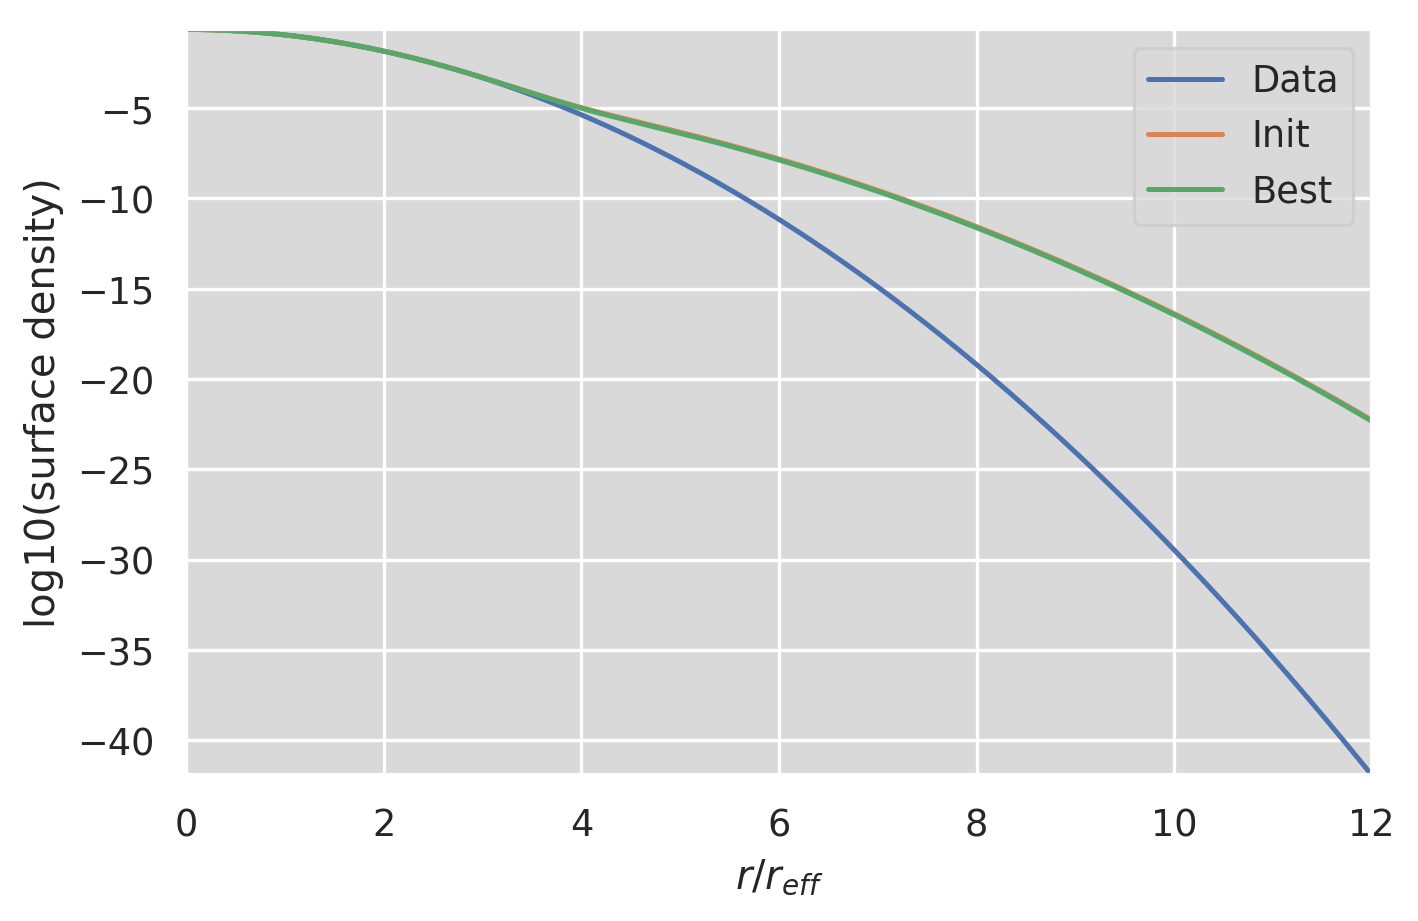

Init  chisq = -9.652641043742028
ws, re: (array([9.86732485e-01, 4.43810612e-03, 8.82940869e-03, 7.74427430e-16,
       3.34784785e-46, 3.25773455e-10, 2.35355430e-16, 0.00000000e+00]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -9.943800
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 11
-9.943799806335813 [  4.46423945  -0.68808539  17.11514862 -12.94958954 -82.86577839
  14.14061494  13.81570492]
n=0.506: (
    normalize(np.array([1.1102230246e-16, 2.8723844527e-46, 7.5754510796e-03, 9.8861760167e-01, 3.8069469731e-03, 6.6444277293e-16, 2.7950690985e-10, 2.0193010758e-16])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),
Init  chisq = -9.723525624196437
ws, re: (array([9.88617602e-01, 3.80694697e-03, 7.57545108e-03, 6.64442773e-16

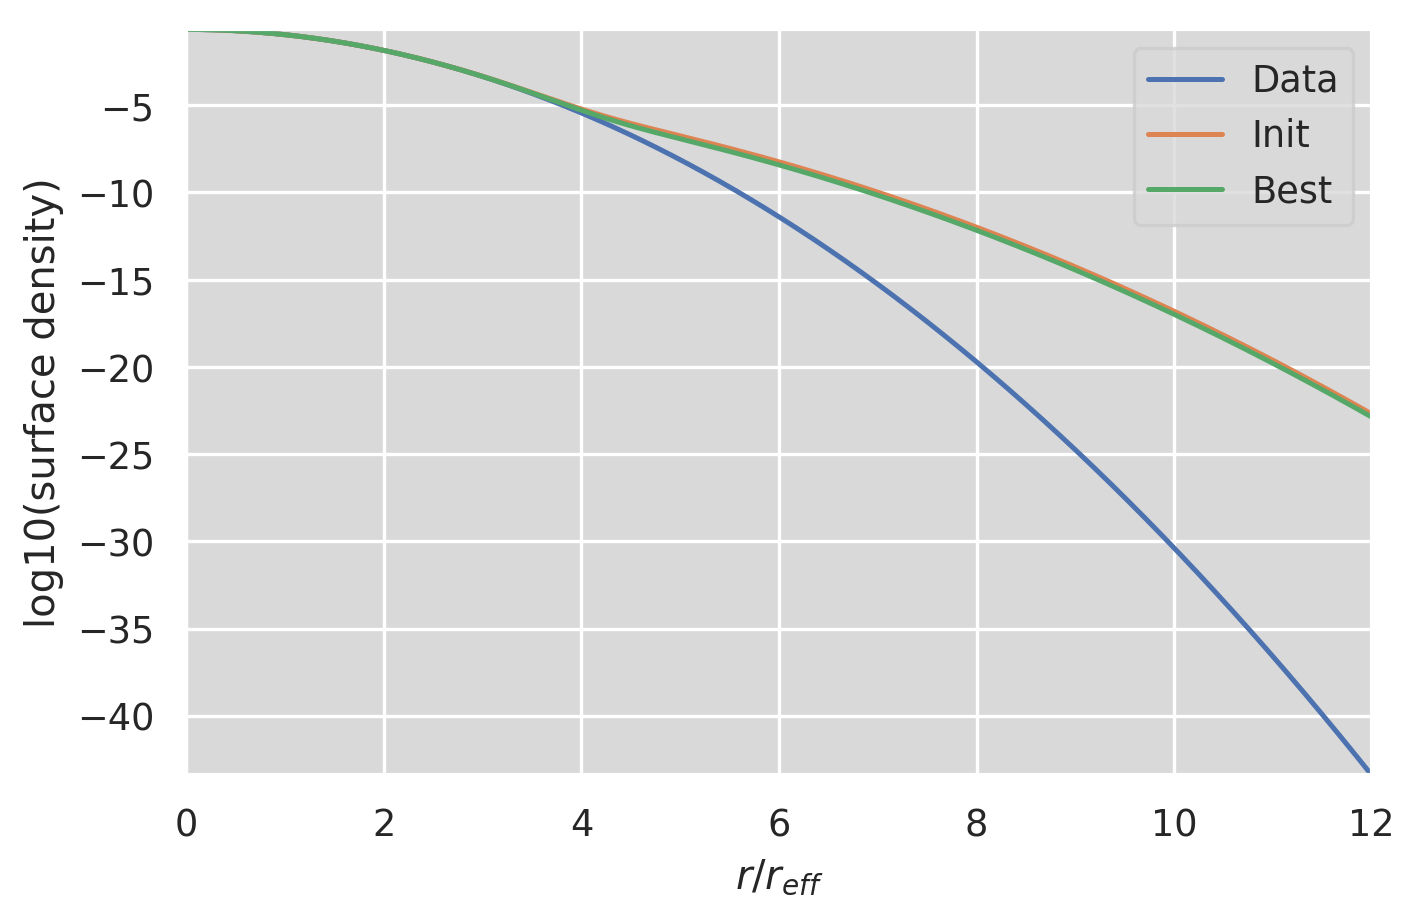

Init  chisq = -9.9434262893508
ws, re: (array([9.96192174e-01, 1.27279641e-03, 2.53502933e-03, 2.22346706e-16,
       9.61204257e-47, 9.35331729e-11, 6.75731547e-17, 0.00000000e+00]), array([1.    , 0.5   , 1.5   , 0.25  , 2.5   , 0.125 , 0.0625, 5.    ]))
Optimization terminated successfully.
         Current function value: -11.475668
         Iterations: 7
         Function evaluations: 108
         Gradient evaluations: 12
-11.475667904350273 [  6.26103522  -0.68921596  17.1151521  -12.94958954 -82.86577839
  14.14061494  13.81570492]
n=0.501: (
    normalize(np.array([0.0000000000e+00, 4.8107190300e-47, 1.2687540354e-03, 9.9809437009e-01, 6.3687582695e-04, 1.1128202177e-16, 4.6812299412e-11, 3.3819602747e-17])),
    np.array([5.0000000000e+00, 2.5000000000e+00, 1.5000000000e+00, 1.0000000000e+00, 5.0000000000e-01, 2.5000000000e-01, 1.2500000000e-01, 6.2500000000e-02]),
),


In [48]:
def radiusfixed(n=1):
    return np.log10(np.array([1, 0.5, 1.5, 0.25, 2.5, 0.125, 0.0625, 5]))

nvals = [
    (
        np.array([
            1.0
        ]),
        (
            normalize(np.array([
                0.46, 0.18, 0.27, 1.7e-2, 1e-2, 5e-3, 1e-6, 1e-12
            ])),
            radiusfixed(),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiusfixed, sort=False)

nvals = [
    (
        np.array(list(reversed([
            0.501, 0.502, 0.503, 0.504, 0.505, 0.506, 0.507, 0.508, 0.509, 0.51, 0.512,
            0.514, 0.516, 0.518, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.56,
            0.57, 0.58, 0.59, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8,
            0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975,
        ]))),
        (
            normalize(np.array([
                4.6326306880e-01, 1.7780850485e-01, 2.6868971315e-01, 1.6894641090e-02,
                6.8405081968e-02, 4.9380026986e-03, 9.8745465974e-07, 9.8743235810e-13
            ])),
            radiusfixed(),
        )
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiusfixed, plotnth=5)

nvals = [
    (
        np.array([
    1.025, 1.05, 1.075, 1.1,
    1.135, 1.165, 1.2, 1.225, 1.25, 1.275, 1.3, 1.333, 1.367, 1.4, 1.433, 1.467,
    1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.8452, 1.893, 1.942, 2.0, 2.044, 2.1,
    2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8,
    2.85, 2.9, 2.95, 3.0, 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5,
    3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.1, 4.2, 4.3, 4.4,
    4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9,
    6.0, 6.15, 6.3, 6.45, 6.6, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0
        ]),
        (
            normalize(np.array([
                4.6326306880e-01, 1.7780850485e-01, 2.6868971315e-01, 1.6894641090e-02,
                6.8405081968e-02, 4.9380026986e-03, 9.8745465974e-07, 9.8743235810e-13
            ])),
            radiusfixed(),
        ),
    )
]
#fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiusfixed, plotnth=5)

### How well does the interpolation work far away from the spline control points?

This is TBD. At the least, the COSMOS analysis shows that it's not terribly bad. On the other hand, you could argue that the Sersic profile isn't physically motivated anyways, so it's not worth worrying too much about reproducing it to arbitrarily small tolerances, except insofar as adding more components minimizes the amplitude of the wiggles in the MGA profile.